In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(SCRIPT_DIR)

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

from utils import show_weights, plot_metrics, plot_embeddings, generate_aug_from_bool_aug, fit_classifiers, evaluate_classifiers
from data.loader import generate_cube_augs
from IPython.display import clear_output

In [2]:
os.chdir('..')

In [3]:
!pwd

/Users/admin/Documents/Research/SSL/matrixssl-inductive


In [4]:
# load invkd, spur validation (for fitting lin classifier) and test data
n = 50000
invkd_dict = generate_cube_data(n=n, v=n, d=25, k=5, aug='add', label='invkd')
spur_dict = generate_cube_data(n=n, v=n, d=25, k=5, aug='add', label='spur')

invkd_val, invkd_val_labels = invkd_dict['val'][0][:(n//2)], invkd_dict['val'][1][:(n//2)]
invkd_test, invkd_test_labels = invkd_dict['val'][0][(n//2):], invkd_dict['val'][1][(n//2):]
spur_val, spur_val_labels = spur_dict['val'][0][:(n//2)], spur_dict['val'][1][:(n//2)]
spur_test, spur_test_labels = spur_dict['val'][0][(n//2):], spur_dict['val'][1][(n//2):]

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# split evaluate_embeddings into fitting linear classifier, and getting test scores

def fit_classifiers(dirs, val, val_labels):
    """
    Fit linear classifier on each of representation functions in dirs, using validation data. 
    Returns: (backbones, classifiers)
        backbones: list of backbones/representation functions, one per directory
        classifiers: list of trained nn.Linear modules, one per directory
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # prepare datasets
    val_dataset = TensorDataset(val, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128)

    backbones = []
    classifiers = []
    for idx, dir in enumerate(dirs):
        # print(f'Run {idx+1}')
        # load embedding function, create linear classifier
        run_dict = torch.load(os.path.join(dir, 'run_dict'))
        weights = run_dict['model_weights']
        emb_dim = run_dict['args'].emb_dim
        backbone = nn.Linear(weights['weight'].shape[1], weights['weight'].shape[0]).to(device)
        backbone.load_state_dict(weights)
        # no weight updates for backbone
        for param in backbone.parameters():
            param.requires_grad = False
        linear = nn.Linear(emb_dim, 1)
        optimizer = optim.SGD(linear.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-5)
        loss_fn = nn.BCEWithLogitsLoss() # reduction = 'mean'
        # fit lin clf on validation data
        for epoch in range(50):
            for idx, (x, y) in enumerate(val_loader):
                x, y, = x.to(device), y.to(device)
                optimizer.zero_grad()
                logits = linear(backbone(x))
                clf_loss = loss_fn(logits.squeeze(), y)
                clf_loss.backward()
                del x, y
                optimizer.step()
            # if epoch % 10 == 0:
            #     print(f"Loss at epoch {epoch}: {clf_loss}")
        backbones.append(backbone)
        classifiers.append(linear)  
    return backbones, classifiers 

def evaluate_classifiers(backbones, classifiers, test, test_labels):
    """
    Evaluate each trained linear classifier in `classifiers` on test data.

    backbones: list of backbones/representation functions
    classifiers: list of trained nn.Linear modules
    Returns: (test_accs, avg_acc)
        test_accs: list of lin clf accuracies on test data for each linear classifier + backbone
        avg_accs: average of accs in test_accs
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_dataset = TensorDataset(test, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128)

    test_accs = []
    for idx, (backbone, linear) in enumerate(zip(backbones, classifiers)):
        # get test set accuracy
        with torch.no_grad():
            correct = 0
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = linear(backbone(x)).flatten()
                out[out == 0] = 1 # also included same 'convention' in labeling - not sure if this makes sense or not.
                pred = (torch.sign(out) + 1)/2
                correct += (pred == y).float().sum()
        test_acc = correct / len(test_dataset)
        test_accs.append(test_acc)
    
    avg_acc = sum(test_accs) / len(test_accs)
    return test_accs, avg_acc

## Visualize covariance matrices of data for each augmentation:

Index: 27307


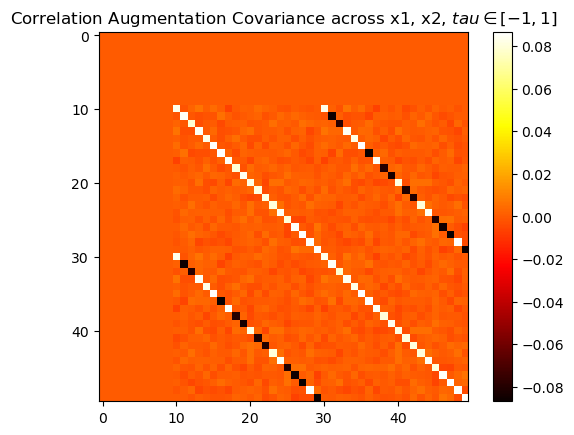

In [54]:
# corr augmentations, tau in [-1, 1]
k = 10
n_samples = 1000
dir = './outputs/bool_corr_invkd/spectral_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
# get random data from x1
idx = torch.randint(low=0, high=x1.shape[0], size=(1,)).item()
print(f'Index: {idx}')
x = x1[idx]
x_pairs = generate_aug_from_bool_aug(x, n_samples, k)
mean = x_pairs.mean(dim=0)
centered = x_pairs - mean
cov = centered.T @ centered / n_samples
plt.imshow(cov, cmap='hot')
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-1, 1]$')
plt.colorbar()
plt.show()

Index: 24346


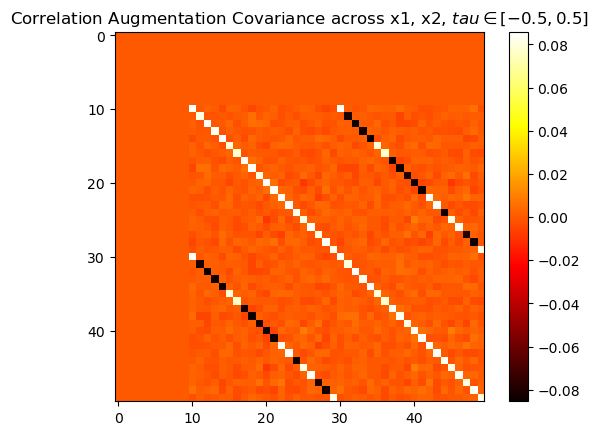

In [50]:
# corr augmentations, tau in [-0.5, 0.5]
k = 10
n_samples = 1000
dir = './outputs/bool_corr_spur/mssla_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
# get random data from x1
idx = torch.randint(low=0, high=x1.shape[0], size=(1,)).item()
print(f'Index: {idx}')
x = x1[idx]
# generate positive pair data
x_pairs = generate_aug_from_bool_aug(x, n_samples, k)
mean = x_pairs.mean(dim=0)
centered = x_pairs - mean
cov = centered.T @ centered / n_samples
plt.imshow(cov, cmap='hot')
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-0.5, 0.5]$')
plt.colorbar()
plt.show()

In [55]:
# plot quantity that is 0 when our assumption holds.. (see obsidian)
k = 10
n_samples = 1000
dir_invkd = './outputs/bool_corr_invkd/mssla_linear_adam_run1'
dir_spur = './outputs/bool_corr_spur/mssla_linear_adam_run1'
run_dict_invkd = torch.load(os.path.join(dir_invkd, 'run_dict'))
run_dict_spur = torch.load(os.path.join(dir_spur, 'run_dict'))
weights_invkd = run_dict_invkd['weights']
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
total = 0
for i in range(centered1.shape[0]):
    outer1 = torch.outer(centered1[i], centered1[i])
    outer2 = torch.outer(centered2[i], centered2[i])
    frob = torch.norm(outer1 - outer2, p='fro')
    total += frob
expected = total / centered1.shape[0]
expected
# cov1 = centered1.T @ centered1
# cov2 = centered2.T @ centered2


tensor(26.5095)

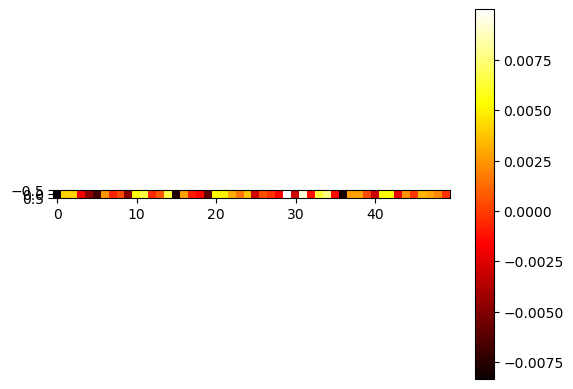

In [58]:
plt.imshow(mean1.unsqueeze(0), cmap='hot')
plt.colorbar()

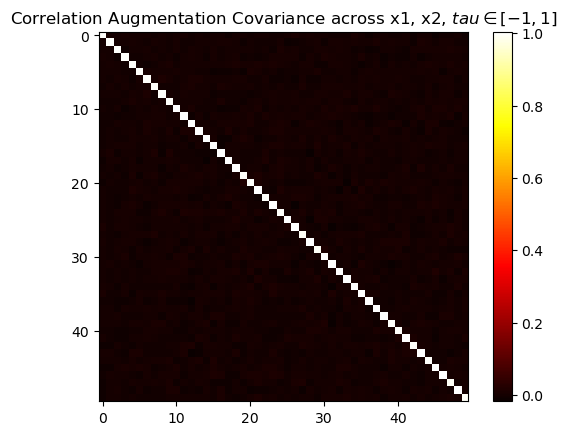

In [16]:
# corr augmentations tau in [-1, 1]
dir = './outputs/bool_corr_invkd/spectral_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
n = x1.shape[0]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
cov = (1/n) * centered1.T @ centered2
plt.imshow(cov, cmap='hot')
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-1, 1]$')
plt.colorbar()
plt.show()


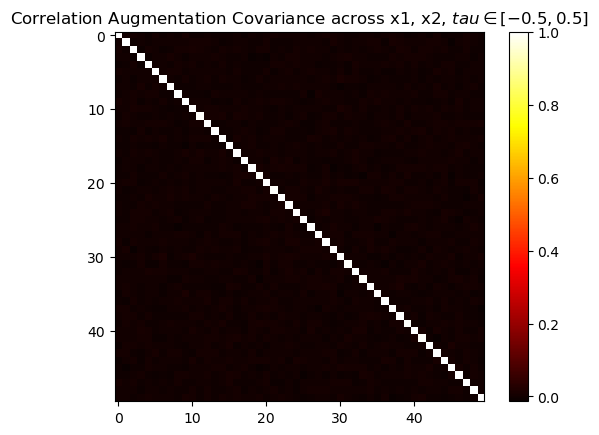

In [18]:
# corr augmentations tau in [-0.5, 0.5]
dir = './outputs/bool_corr_spur/mssla_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
n = x1.shape[0]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
cov = (1/n) * centered1.T @ centered2
plt.imshow(cov, cmap='hot')
plt.colorbar()
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-0.5, 0.5]$')
plt.show()

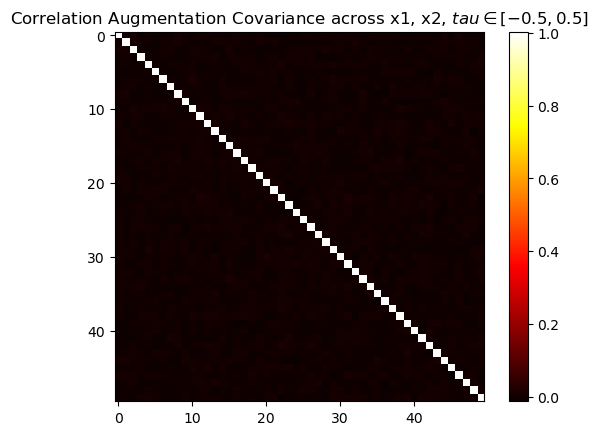

In [17]:
# corr augmentations tau in [-0.5, 0.5]
dir = './outputs/bool_corr_spur/spectral_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
n = x1.shape[0]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
cov = (1/n) * centered1.T @ centered2
plt.imshow(cov, cmap='hot')
plt.colorbar()
plt.title('Correlation Augmentation Covariance across x1, x2, $tau \in [-0.5, 0.5]$')
plt.show()


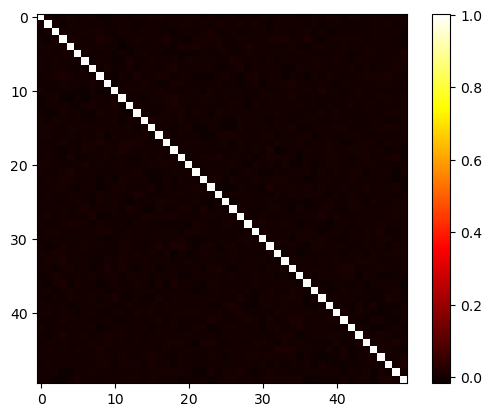

In [7]:
# add augmentations
dir = './outputs/bool_add_invkd/spectral_linear_adam_run1'
run_dict = torch.load(os.path.join(dir, 'run_dict'))
x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][1]
n = x1.shape[0]
mean1, mean2 = x1.mean(dim=0), x2.mean(dim=0)
centered1, centered2 = x1-mean1, x2-mean2
cov = (1/n) * centered1.T @ centered2
plt.imshow(cov, cmap='hot')
plt.colorbar()
plt.show()

In [5]:
x1.shape, mean1.shape

(torch.Size([65536, 50]), torch.Size([50]))

## Aug: Corr

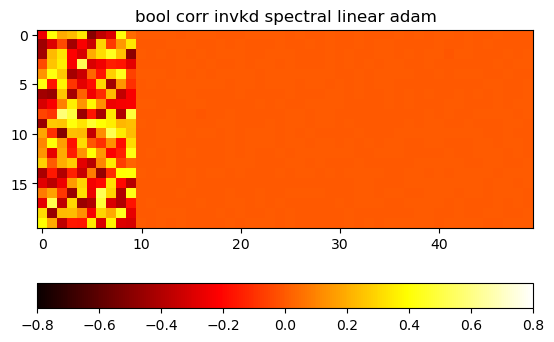

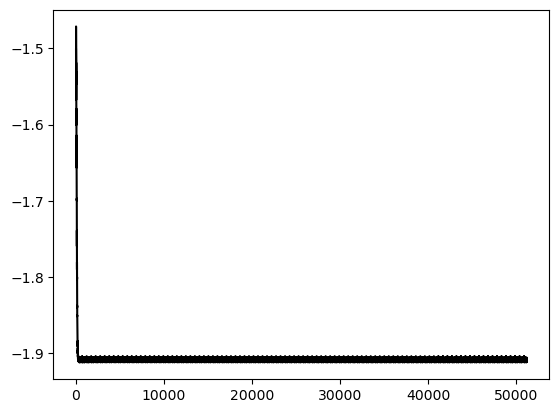

In [79]:
dir = './outputs/bool_corr_invkd/spectral_linear_adam_run1'
show_weights(dir, True, False)

# show_weights(dir, True, False, 'model_weights_2024-04-27_19-53-12',
# 'model_weights_2024-04-27_19-53-46',
# 'model_weights_2024-04-27_19-54-18',
# 'model_weights_2024-04-27_19-54-53',
# 'model_weights_2024-04-27_19-55-29')
plot_metrics('train_losses', True, False, dir)
# tau in [-1, 1]

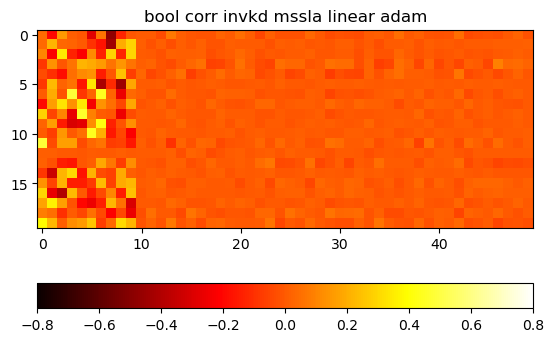

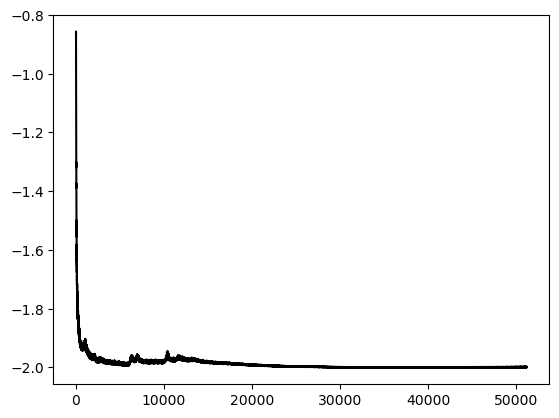

In [80]:
dir = './outputs/bool_corr_invkd/mssla_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)
# tau in [-1, 1]

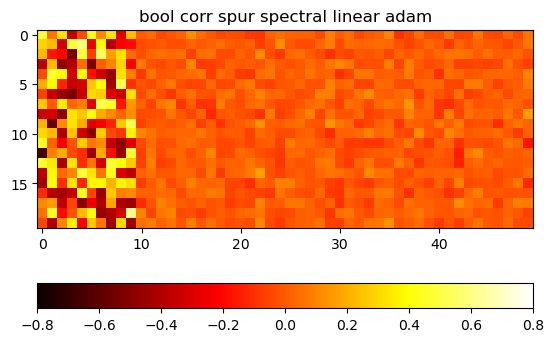

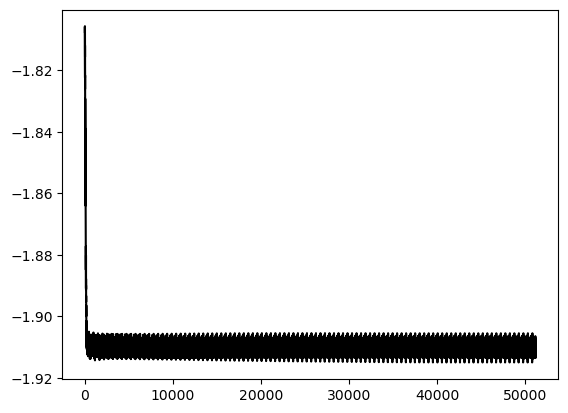

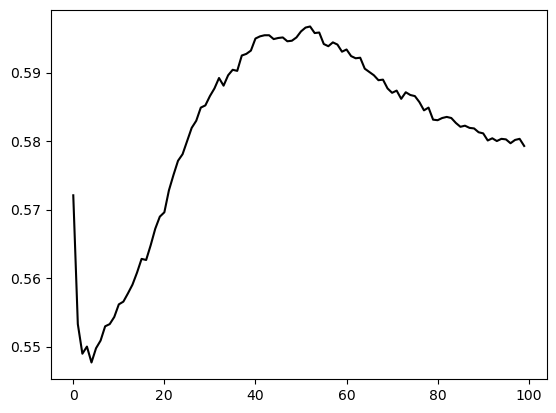

In [76]:
dir = './outputs/bool_corr_spur/spectral_linear_adam_run1'
show_weights(dir, True, False)

# show_weights(dir, True, False,
# 'model_weights_2024-04-27_20-13-01',
# 'model_weights_2024-04-27_20-13-34',
# 'model_weights_2024-04-27_20-14-07',
# 'model_weights_2024-04-27_20-14-40',
# 'model_weights_2024-04-27_20-15-12')
plot_metrics('train_losses', True, False, dir)
plot_metrics('val_accs', True, False, dir)
# tau in [-0.5, 0.5]

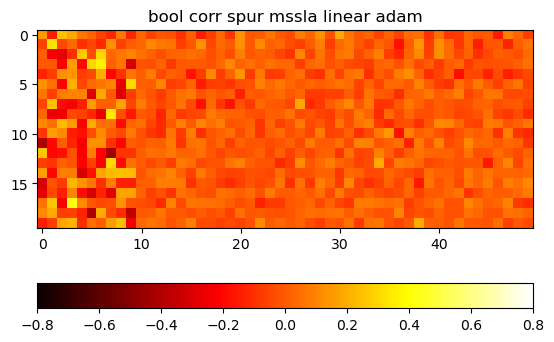

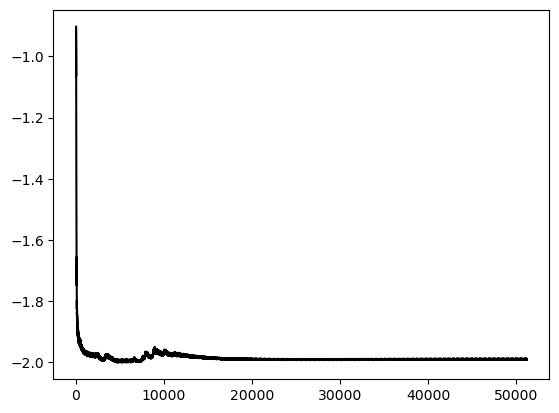

In [77]:
dir = './outputs/bool_corr_spur/mssla_linear_adam_run1'
show_weights(dir, True, False)

plot_metrics('train_losses', True, False, dir)
# plot_metrics('val_accs', True, False, dir)

# tau in [-0.5, 0.5]

## Aug: Add

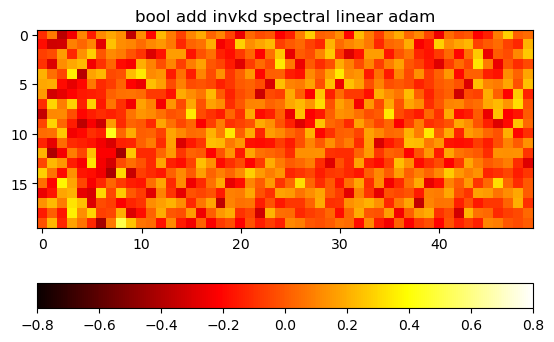

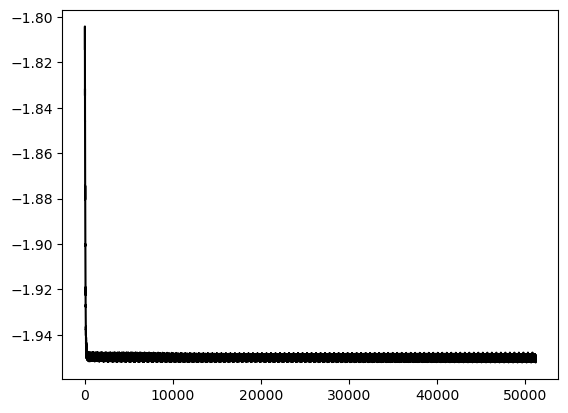

In [81]:
dir = './outputs/bool_add_invkd/spectral_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

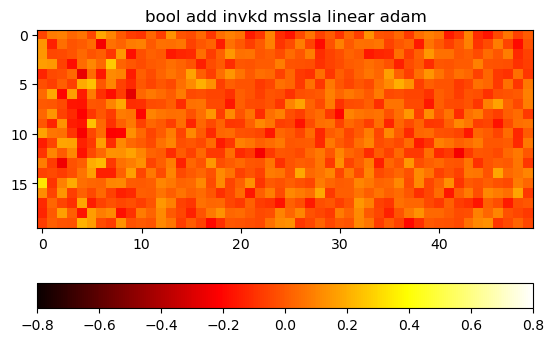

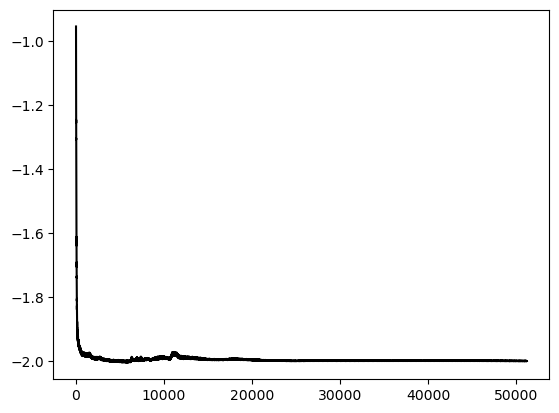

In [82]:
dir = './outputs/bool_add_invkd/mssla_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

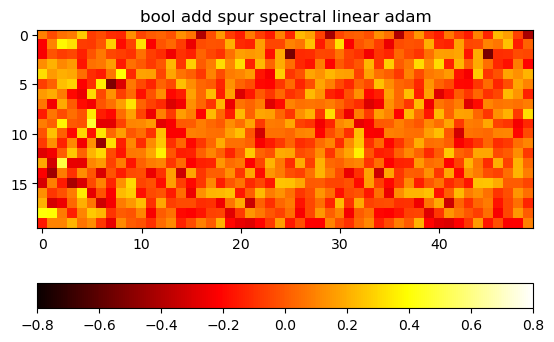

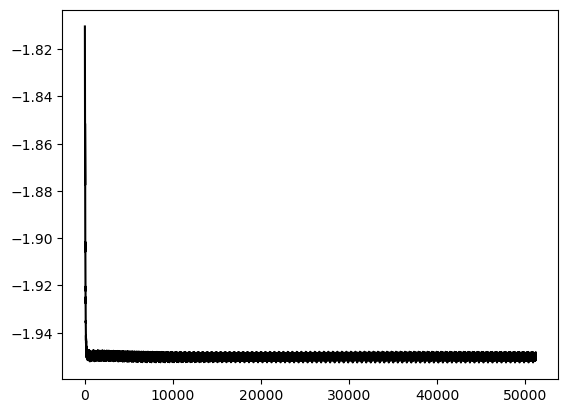

In [71]:
dir = './outputs/bool_add_spur/spectral_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

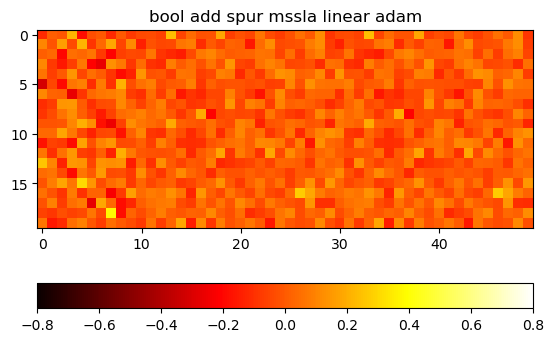

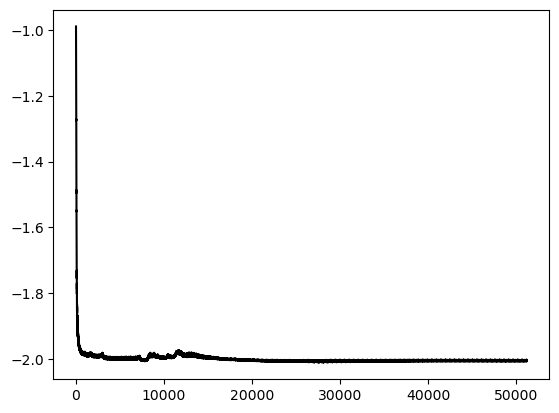

In [70]:
dir = './outputs/bool_add_spur/mssla_linear_adam_run1'
show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

## Hyperparam tuning experiments

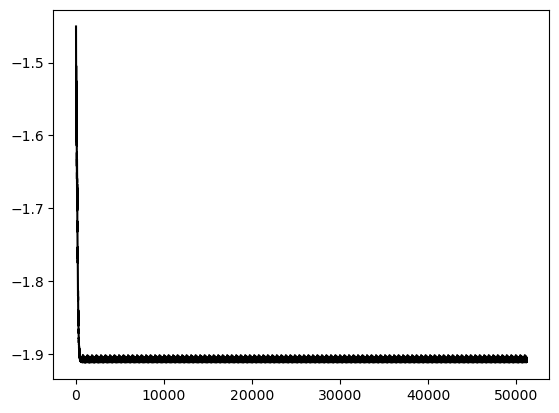

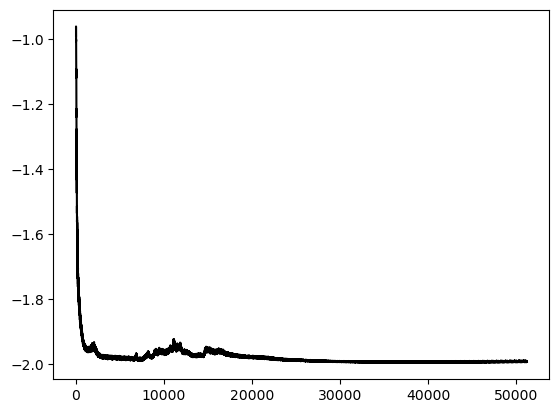

In [86]:
# lr 5e-4, tau in -1, 1
dir = './outputs/bool_corr_invkd/spectral_linear_adam_lr=0.0005_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)
# still quite shaky at the bottom.. for lr = 5e-4, adam

dir = './outputs/bool_corr_invkd/mssla_linear_adam_lr=0.0005_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

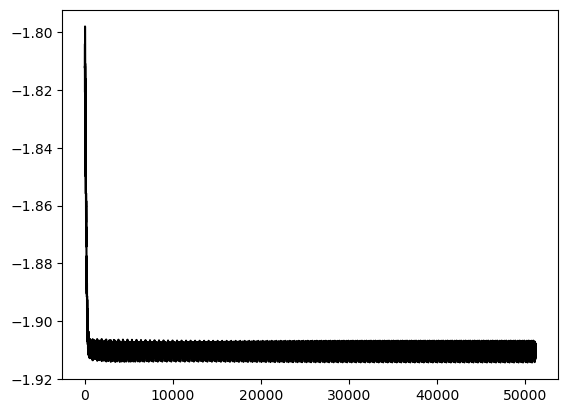

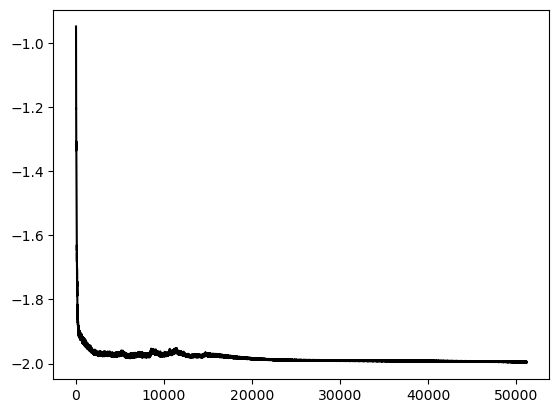

In [87]:
# lr 5e-4, tau in -0.5, 0.5
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0005_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)
# still quite shaky at the bottom.. for lr = 5e-4, adam

dir = './outputs/bool_corr_spur/mssla_linear_adam_lr=0.0005_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

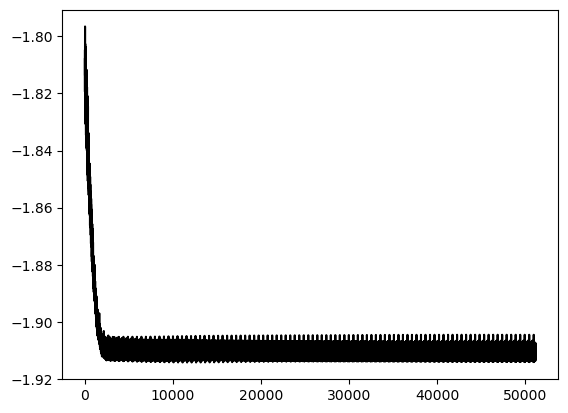

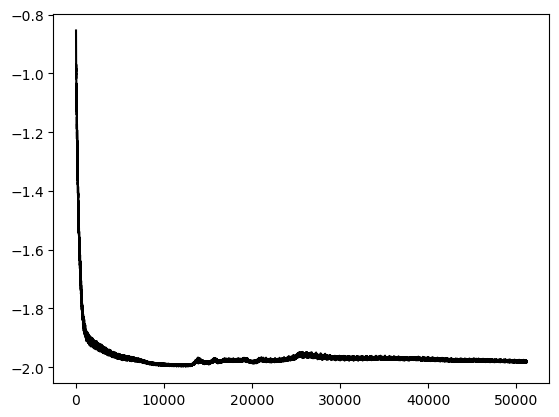

In [88]:
# lr 1e-4, tau in -0.5, 0.5
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0001_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

dir = './outputs/bool_corr_spur/mssla_linear_adam_lr=0.0001_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

In [92]:
!pwd

/Users/admin/Documents/Research/SSL/matrixssl-inductive


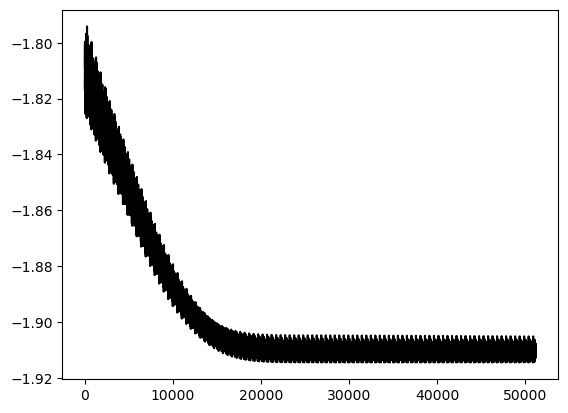

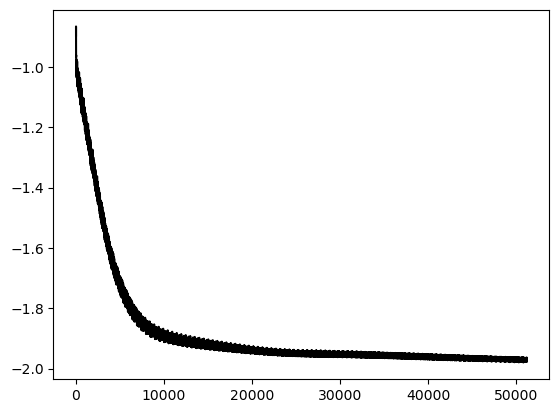

In [93]:
# lr 1e-5, tau in -0.5, 0.5
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=1e-05_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

dir = './outputs/bool_corr_spur/mssla_linear_adam_lr=1e-05_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

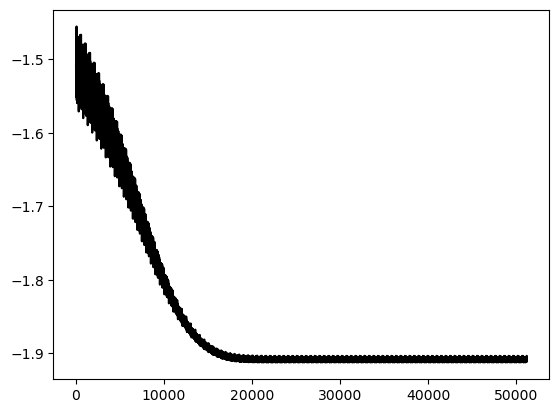

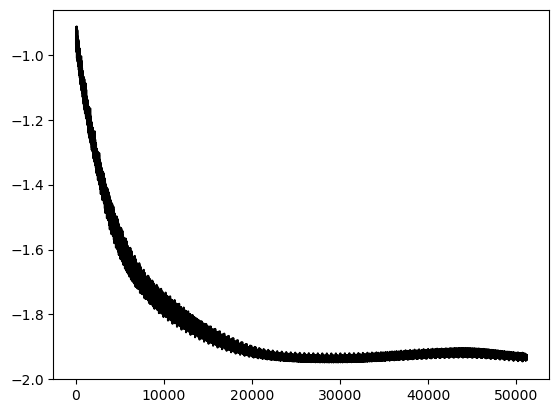

In [94]:
# Lowering learning rate only appears to make things worse
# lr 1e-5, tau in -1, 1
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=1e-05_run2'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

dir = './outputs/bool_corr_spur/mssla_linear_adam_lr=1e-05_run2'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

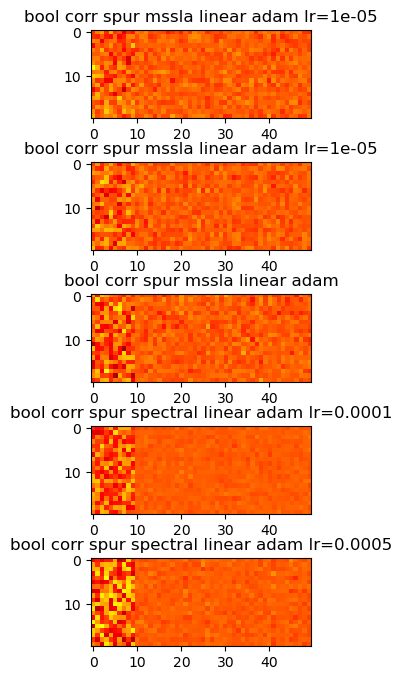

In [4]:
show_weights(
    './outputs/bool_corr_spur/mssla_linear_adam_lr=1e-05_run1',
    './outputs/bool_corr_spur/mssla_linear_adam_lr=1e-05_run2',
    './outputs/bool_corr_spur/mssla_linear_adam_run1',
    './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0001_run1',
    './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0005_run1',
)

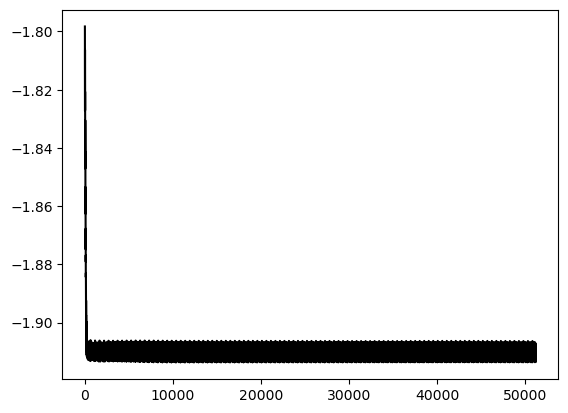

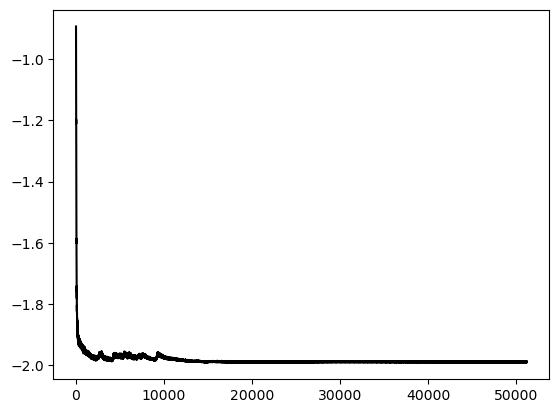

In [6]:
# Weight decay doesn't appear to do anything
# lr 1e-3, tau in +-0.5, , wd=1e-4
dir = './outputs/bool_corr_spur/spectral_linear_adam_wd=0.0001_tau_l=-0.5_tau_u=0.5_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

dir = './outputs/bool_corr_spur/mssla_linear_adam_wd=0.0001_tau_l=-0.5_tau_u=0.5_momentum=0.9_run1'
# show_weights(dir, True, False)
plot_metrics('train_losses', True, False, dir)

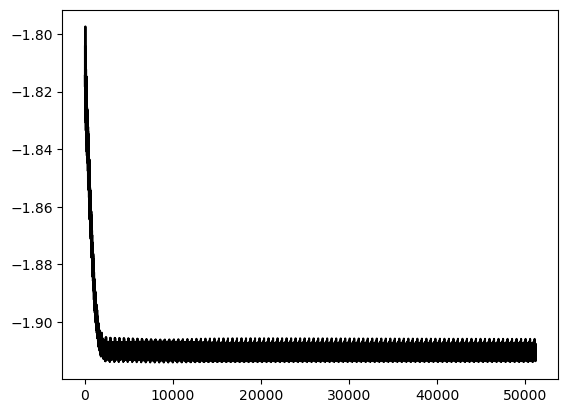

In [7]:
# lr=1e-4, wd=1e-4
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0001_wd=0.0001_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)

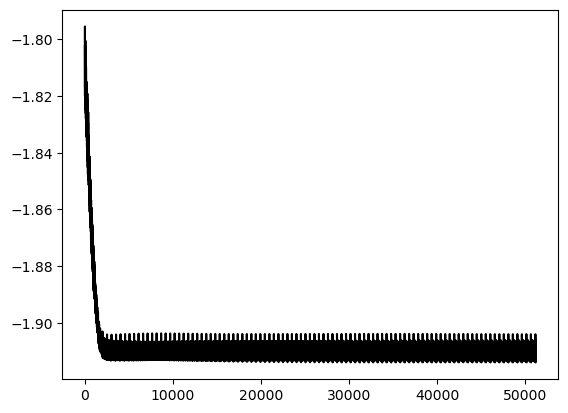

In [8]:
# Increasing weight decay to 1e-3 doesn't seem to do anything either
dir = './outputs/bool_corr_spur/spectral_linear_adam_lr=0.0001_wd=0.001_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)

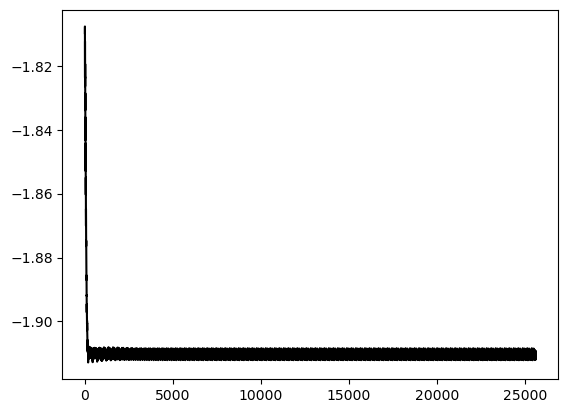

In [9]:
# Increasing batch size helps.. bs=256 for tau +- 0.5, lr=1e-3 wd=1e-5
dir = './outputs/bool_corr_spur/spectral_linear_adam_bs=256_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)

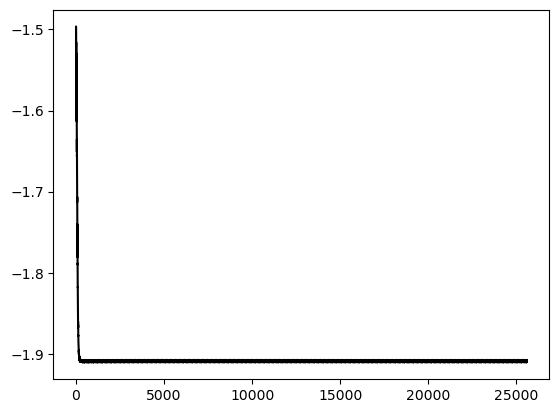

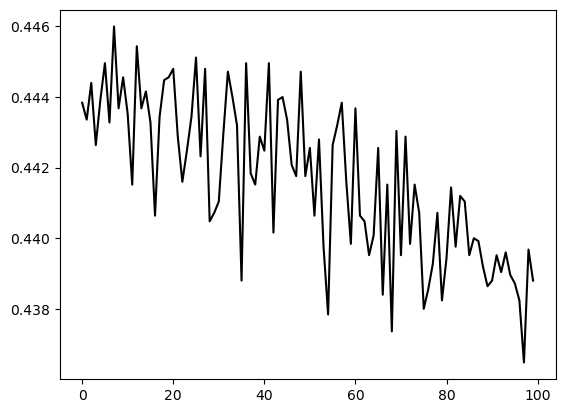

In [12]:
# bs=256 for tau in +-1 lr=1e-3 wd=1e-5
dir = './outputs/bool_corr_spur/spectral_linear_adam_bs=256_tau_l=-1.0_tau_u=1.0_run1'
plot_metrics('train_losses', True, False, dir)
plot_metrics('val_accs', True, False, dir)

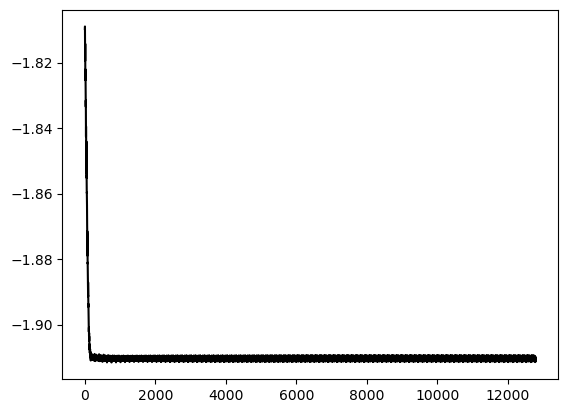

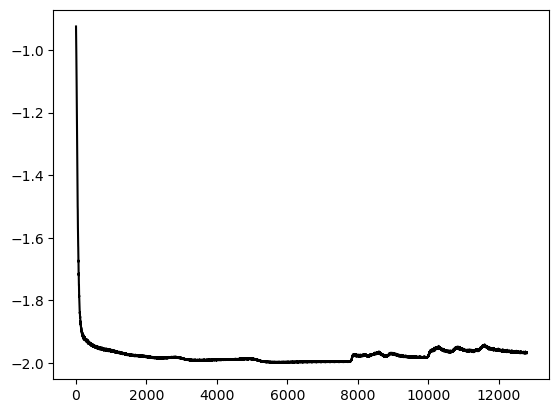

In [10]:
# bs=512 tau +- 0.5 
dir = './outputs/bool_corr_invkd/spectral_linear_adam_bs=512_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)
dir = './outputs/bool_corr_invkd/mssla_linear_adam_bs=512_tau_l=-0.5_tau_u=0.5_run1'
plot_metrics('train_losses', True, False, dir)

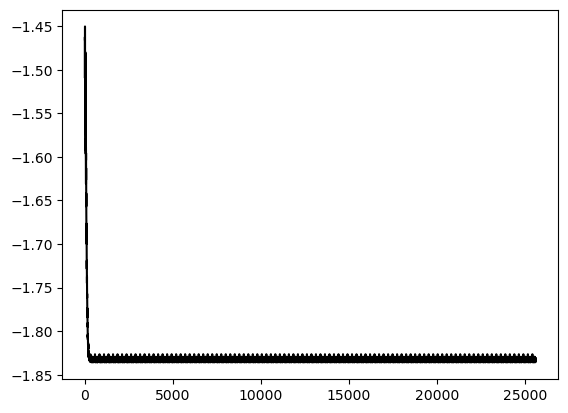

In [8]:
# halving dims (d=25, k=5, embd=10)
dir = './outputs/bool_corr_invkd/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1'
plot_metrics('train_losses', True, False, dir)
dir = './outputs/bool_corr_invkd/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1'
plot_metrics('train_losses', True, False, dir)

## Weight Matrices for Half Dim Runs (embd=10, half dims) 4 runs each

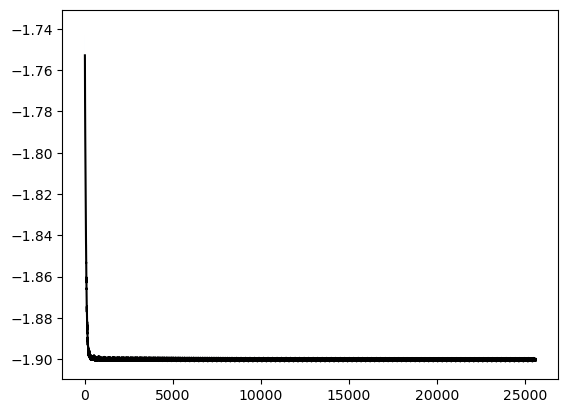

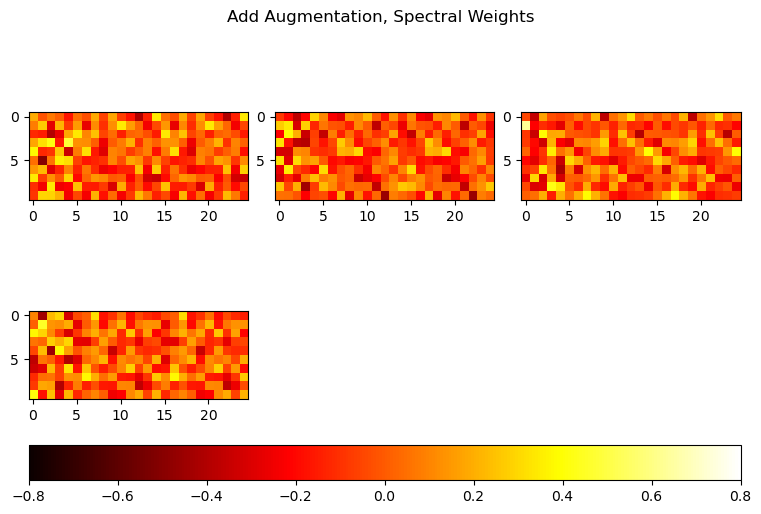

In [7]:
# aug=add, d=25, k=10, embd=10, bs=256, spectral
dirs = [
'./outputs/old/multipletau_embd10/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/old/multipletau_embd10/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/old/multipletau_embd10/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/old/multipletau_embd10/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_metrics(dirs, toplot='train_losses', aggregate=True, plotall=False)
show_weights(dirs, subtitle=False, title='Add Augmentation, Spectral Weights')

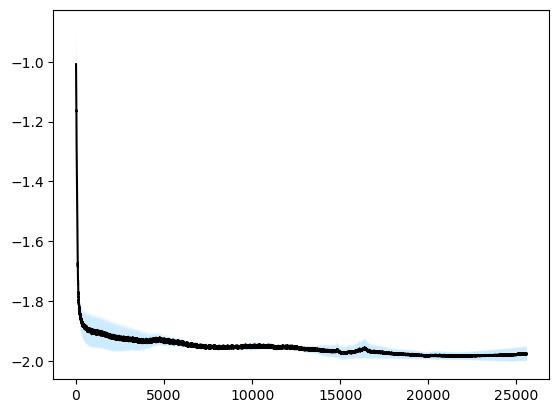

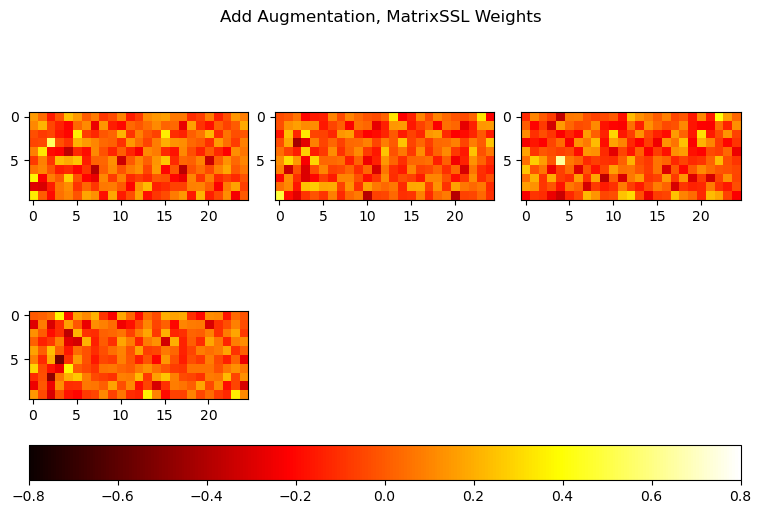

In [8]:
# aug=add, d=25, k=10, embd=10, bs=256, mssla
dirs = [
'./outputs/old/multipletau_embd10/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/old/multipletau_embd10/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/old/multipletau_embd10/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/old/multipletau_embd10/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4'
]
plot_metrics(dirs, toplot='train_losses', aggregate=True, plotall=False)
show_weights(dirs, subtitle=False, title='Add Augmentation, MatrixSSL Weights')

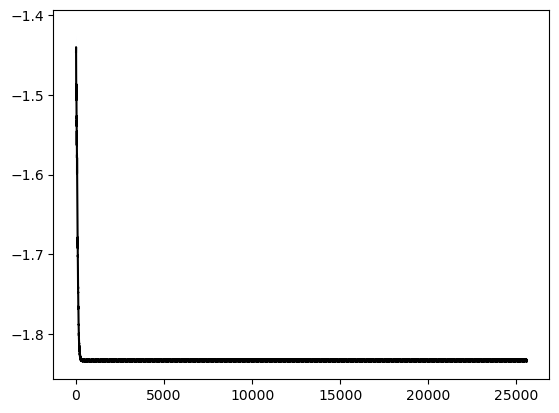

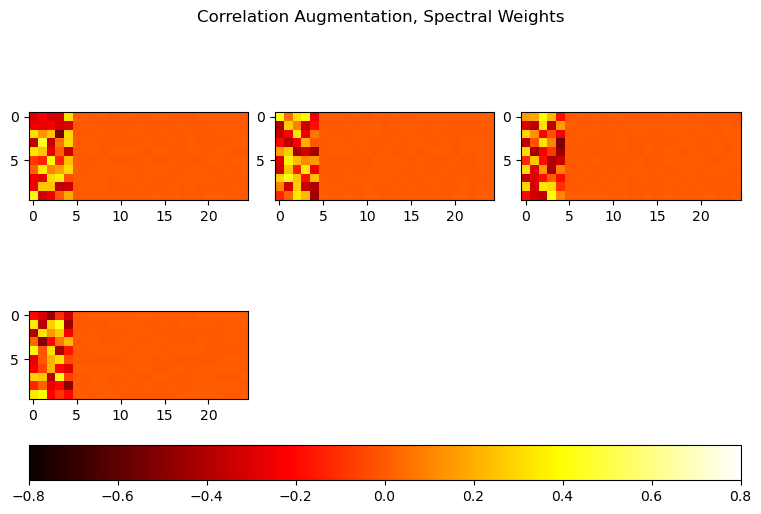

In [10]:
# aug=corr, d=25, k=10, embd=10, bs=256, spectral
dirs = [
'./outputs/old/multipletau_embd10/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/old/multipletau_embd10/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/old/multipletau_embd10/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/old/multipletau_embd10/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4'
]
plot_metrics(dirs, toplot='train_losses', aggregate=True, plotall=False)
show_weights(dirs, subtitle=False, title='Correlation Augmentation, Spectral Weights')

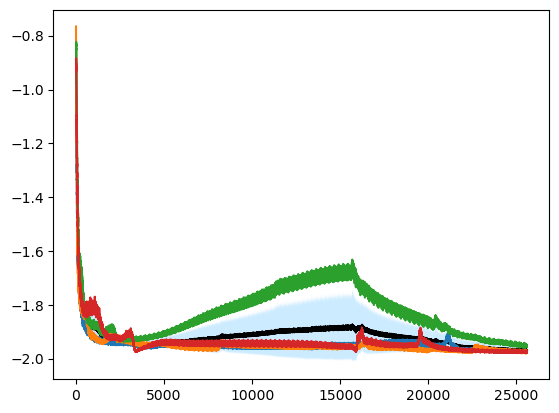

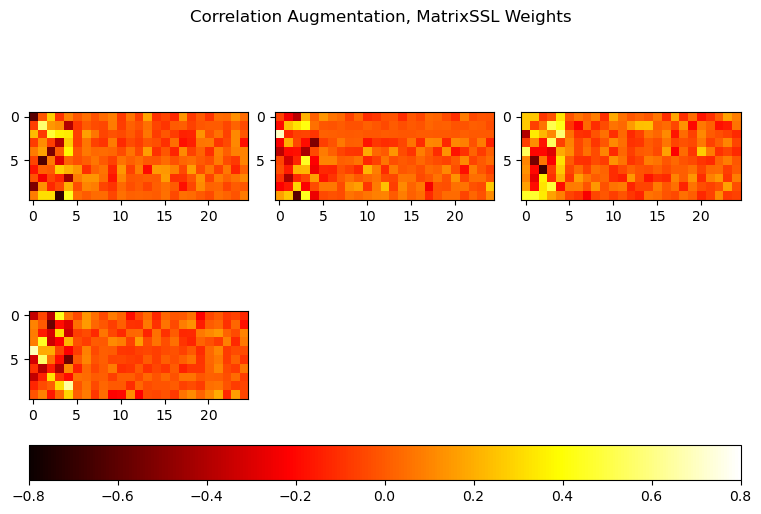

In [12]:
# aug=corr, d=25, k=10, embd=10, bs=256, mssla
dirs = [
'./outputs/old/multipletau_embd10/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/old/multipletau_embd10/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/old/multipletau_embd10/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/old/multipletau_embd10/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_metrics(dirs, toplot='train_losses', aggregate=True, plotall=True)
show_weights(dirs, subtitle=False, title='Correlation Augmentation, MatrixSSL Weights')

## Runs from single tau (from validation code scare)

Norm of 20 rows of Z1: tensor([5.2317, 5.2829, 3.2629, 5.7707, 6.2463, 4.1556, 4.0630, 5.7988, 5.2984,
        6.1979, 4.0702, 6.2182, 4.6822, 5.7751, 5.2846, 4.0808, 4.7194, 5.7919,
        6.5862, 5.8471])
Norm of 20 rows of Z1: tensor([7.1151, 4.4186, 6.1750, 4.4140, 7.8325, 5.8084, 6.7060, 5.9370, 3.8874,
        6.4622, 6.8644, 6.1967, 5.7001, 7.1757, 6.3181, 4.7599, 4.6628, 5.3345,
        7.1586, 4.8395])
Average norm of differences in embeddings (2 runs): 0.9445189237594604, embed dim = 10


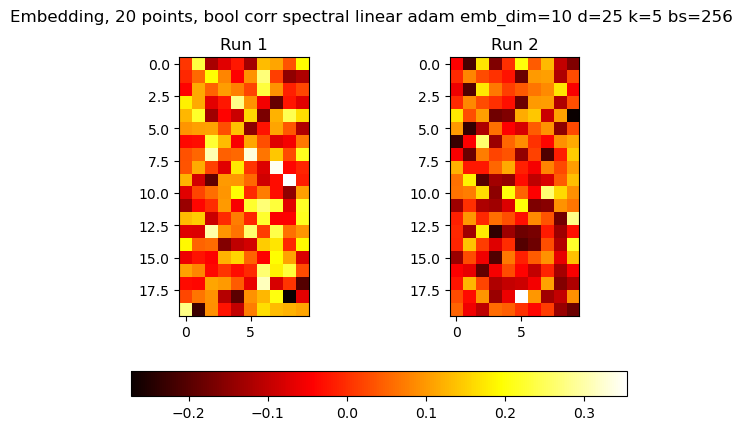

Average Frobenius norm of differences in covariances (2 runs): 2.824920415878296, embed dim = 10


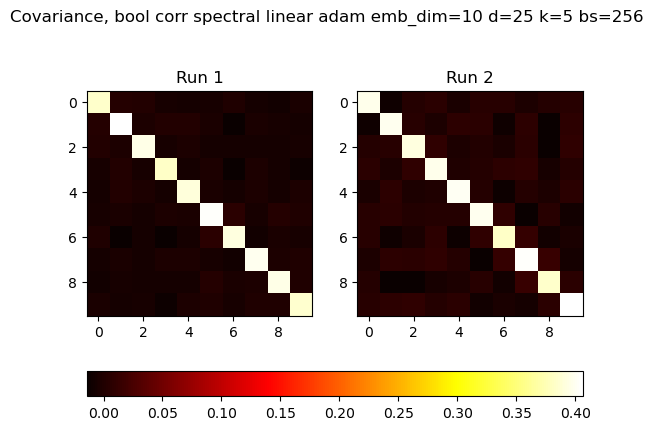

In [6]:
# SPECTRAL BOOL CORR SINGLE TAU
dirs = [
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run5',
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run6',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)

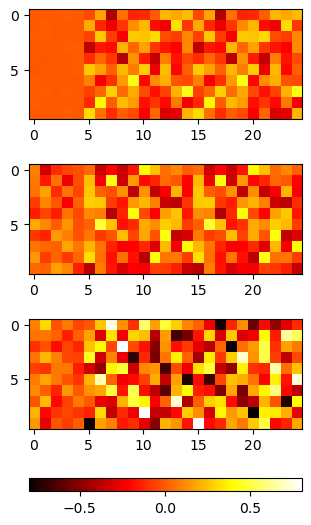

In [12]:
dirs = [
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run5',
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run6',
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run7',
]
show_weights(*dirs, subtitle=False, title=False)

Norm of 20 rows of Z1: tensor([1.9605, 1.9482, 1.9753, 1.9702, 1.9601, 1.9802, 1.9392, 1.9470, 1.9994,
        1.9509, 1.9704, 1.9454, 1.9936, 1.9736, 1.9942, 1.9946, 1.9918, 1.9782,
        2.0029, 1.9805])
Norm of 20 rows of Z1: tensor([1.9235, 1.9594, 1.9319, 1.9546, 1.9437, 1.9200, 1.9300, 1.9302, 1.9663,
        1.9013, 1.9555, 1.9580, 1.9633, 1.9622, 1.9352, 1.9364, 1.9470, 1.9596,
        1.9458, 1.9451])
Average norm of differences in embeddings (2 runs): 0.012446294538676739, embed dim = 10


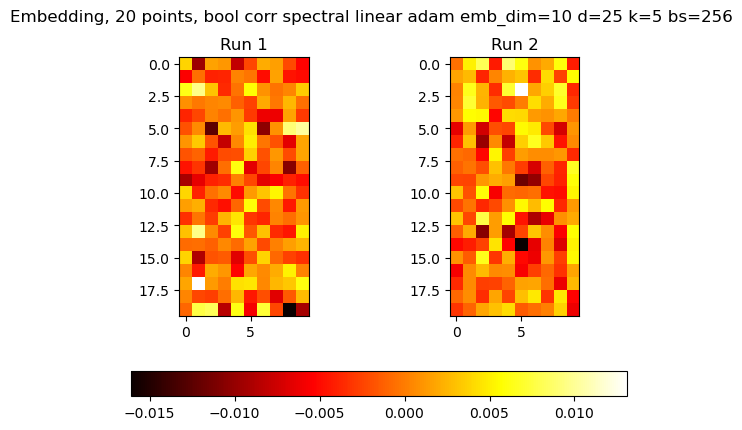

Average Frobenius norm of differences in covariances (2 runs): 0.00014628187636844814, embed dim = 10


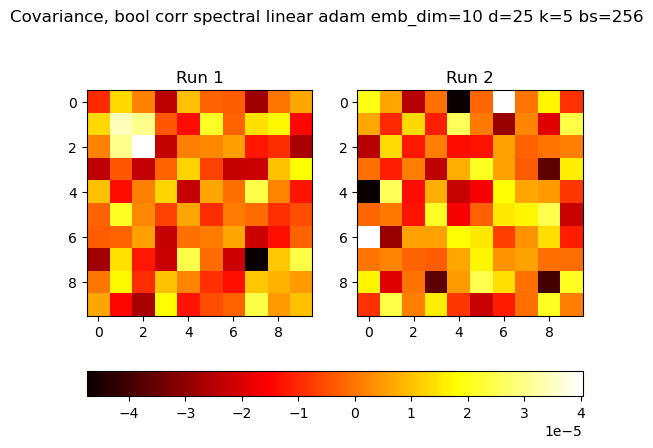

/Users/admin/Documents/Research/SSL/matrixssl-inductive/utils/plotting.py:112: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.1)


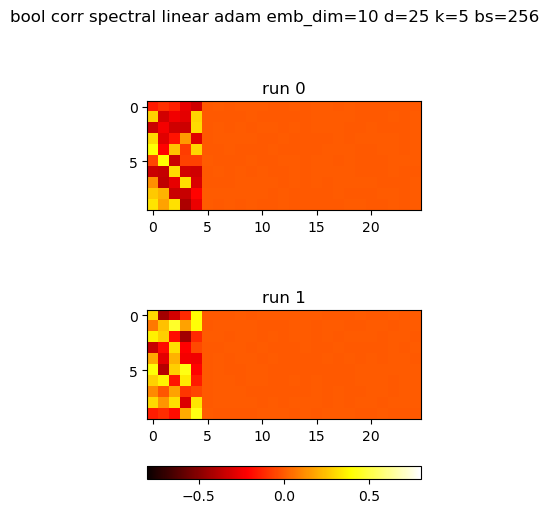

In [5]:
dirs = [
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run8',
'./outputs/bool_corr_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run9',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(*dirs, subtitle=True, title=True)

## Single $\tau$ for all dimensions, embd = h, $\tau \in [-1, 1]$
Ran into unstable solutions, i.e multiple runs converged to different final solutions. I reckon this is because of the same tau being used acros all dimensions

### SPECTRAL

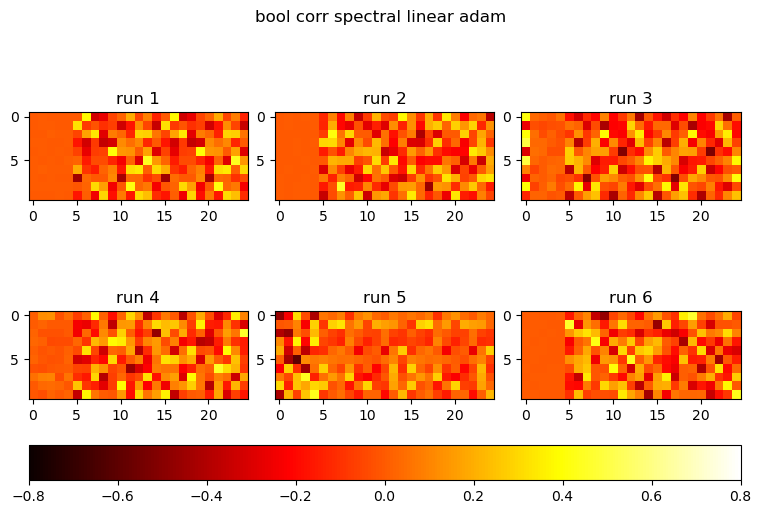

In [11]:
# WEIGHT MATRICES: spectral, embd=10(=h), single tau for all dims
dirs = [
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run1',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run2',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run3',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run4',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run5',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run6',
]
# plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
# plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(dirs, subtitle=True, title=True)

/Users/admin/Documents/Research/SSL/matrixssl-inductive/utils/plotting.py:112: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.1)


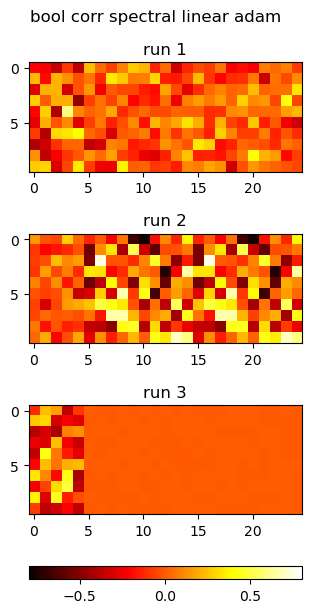

In [4]:
# more spectral runs, to show existence of ignoring augmented dims
dirs = [
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run7',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run8',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run9',
]
# plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
# plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(*dirs, subtitle=True, title=True)

In [6]:
# TEST SCORES: spectral runs, single tau for all dims, embd=h
dirs = [
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run1',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run2',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run3',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run4',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run5',
'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run6',
]
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies for Spectral (Corr, Single Tau for all dims): {[acc.item() for acc in test_accs]}')
print(f'Test accuracy average: {avg_acc}')

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Test accuracies for Spectral (Corr, Single Tau for all dims): [0.6784800291061401, 0.46320000290870667, 0.7399200201034546, 0.5401600003242493, 0.6840000152587891, 0.5114799737930298]
Test accuracy average: 0.6028733253479004


### MSSL

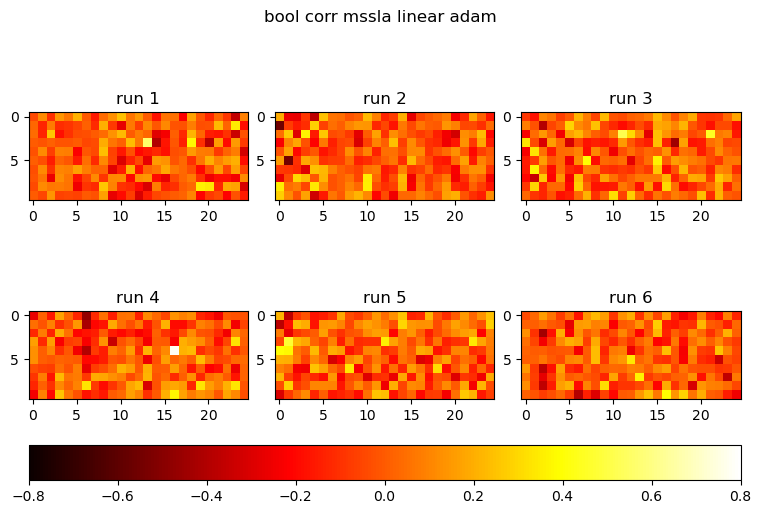

In [10]:
# WEIGHT MATRICES: MSSL, embd=10(=h), single tau for all dims
dirs = [
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run1',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run2',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run3',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run4',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run5',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run6',
]
# plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
# plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(dirs, subtitle=True, title=True)

In [7]:
# TEST SCORES: mssl runs, single tau for all dims, embd=h
dirs = [
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run1',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run2',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run3',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run4',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run5',
'./outputs/without_val/bool_corr_spur/mssla_linear_adam_run6',
]
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies for MSSL (Corr, Single Tau for all dims): {[acc.item() for acc in test_accs]}')
print(f'Test accuracy average: {avg_acc}')

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Test accuracies for MSSL (Corr, Single Tau for all dims): [0.6747599840164185, 0.5906400084495544, 0.6885600090026855, 0.6376399993896484, 0.6716399788856506, 0.4745599925518036]
Test accuracy average: 0.6229666471481323


Suspect multiple solutions may have to do with there being many cases where the sum of the natural boolean values for augmented dimensions are already 0.. Note this is a dataset property, so the specific run here used doesnt matter

In [9]:
k = 5
h = 10
for i in range(6):
    dirname = f'./outputs/without_val/bool_corr_spur/spectral_linear_adam_run{i+1}'
    run_dict = torch.load(os.path.join(dirname, 'run_dict'))
    x1, x2 = run_dict['data']['train'][0], run_dict['data']['train'][0]
    sums1 = torch.sum(x1[:, k:], dim=1)
    sums2 = torch.sum(x2[:, k:], dim=1)
    zerocount1 = torch.sum(sums1 == 0)
    # zerocount2 = torch.sum(sums2 == 0)
    print(f'Run {i+1} has {zerocount1} many zeros out of {x1.shape[0]}')
    # print(sums1[:20] == 0)
    # if i == 1:
    #     break


Run 1 has 8526 many zeros out of 65536
Run 2 has 11457 many zeros out of 65536
Run 3 has 8931 many zeros out of 65536
Run 4 has 11366 many zeros out of 65536
Run 5 has 9336 many zeros out of 65536
Run 6 has 8704 many zeros out of 65536


Norm of 20 rows of Z1: tensor([1.9127, 1.7239, 1.8628, 2.6317, 1.6249, 1.5270, 1.3455, 1.2087, 0.9808,
        1.8598, 1.7726, 1.4879, 0.9806, 1.6942, 2.1309, 0.3308, 2.0550, 2.1921,
        1.1300, 0.9972])
Average norm of differences in embeddings (1 runs): 0.12800082564353943, embed dim = 5


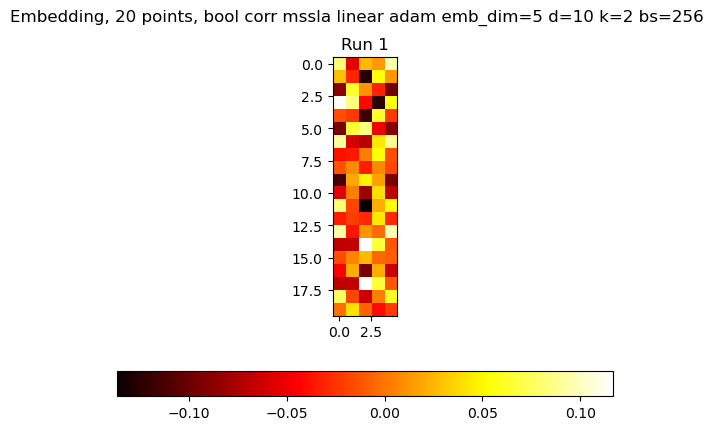

Average Frobenius norm of differences in covariances (1 runs): 0.21737602353096008, embed dim = 5


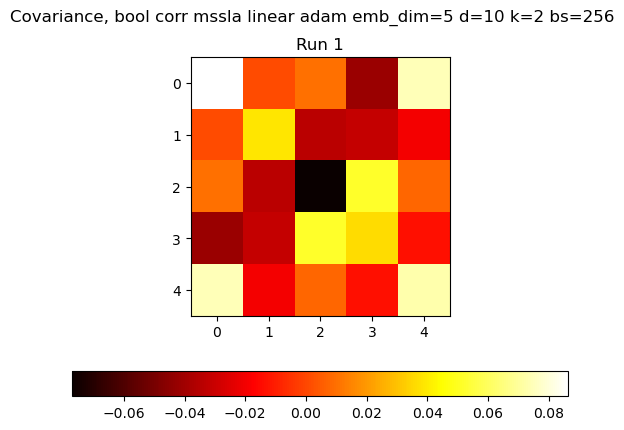

/Users/admin/Documents/Research/SSL/matrixssl-inductive/utils/plotting.py:112: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.1)


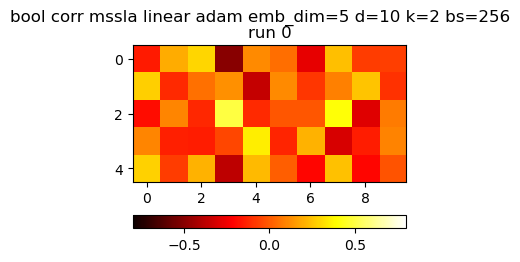

In [14]:
# MSSL BOOL CORR SINGLE TAU
dirs = [
'./outputs/bool_corr_spur/mssla_linear_adam_emb_dim=5_d=10_k=2_bs=256_run1'
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)
show_weights(*dirs, subtitle=True, title=True)

## Different $\tau$ per dimensions, set emb dim = k + h, $\tau \in [-1, 1]$ : Weights +  Test Accs
Changing this back intuitively forces weights to 0 in spectral, avoiding the weird cases we get when we use a single tau for all dimensions (and adjust embedding dimensions to be larger to properly learn spurious sum for bool corr augmentation)

### SPECTRAL
As expected, spectral consistently ignores augmented dimensions and only cares about augmented dimensions

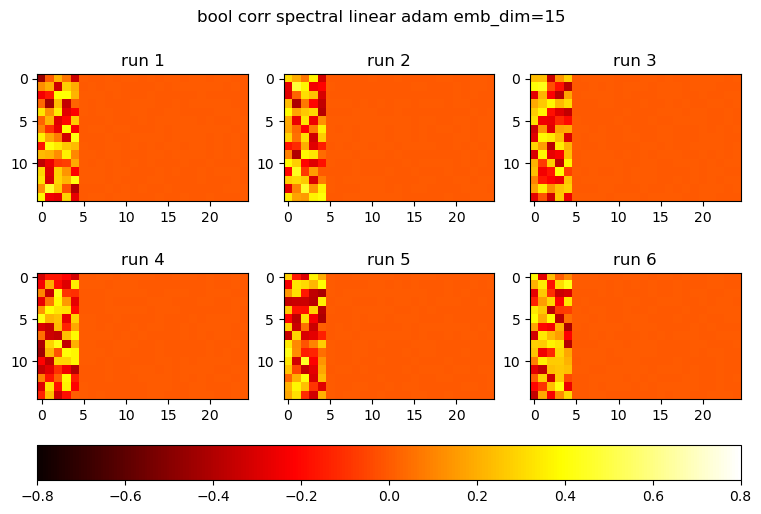

In [9]:
# WEIGHT MATRICES: bool corr, different tau per dimension, embd 15, spectral
dirs = [
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run6'
]
show_weights(dirs, plot_weights=True, subtitle=True, title=True)

In [8]:
# DOWNSTREAM ACCURACY for spectral, embd15, different tau per dimension
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies for Spectral (Corr, Diff Tau across dims, embd=k+h): {[acc.item() for acc in test_accs]}')
print(f'Test accuracy average: {avg_acc}')

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Test accuracies for Spectral (Corr, Diff Tau across dims, embd=k+h): [0.520039975643158, 0.5641599893569946, 0.5297999978065491, 0.5288400053977966, 0.5414800047874451, 0.508679986000061]
Test accuracy average: 0.5321666598320007


Interestingly, spectral is doing almost random guessing downstream!

### MSSL
MSSL learns some amount of the augmented dimensions, but still appears to give most weight to the unaugmented dimensions.

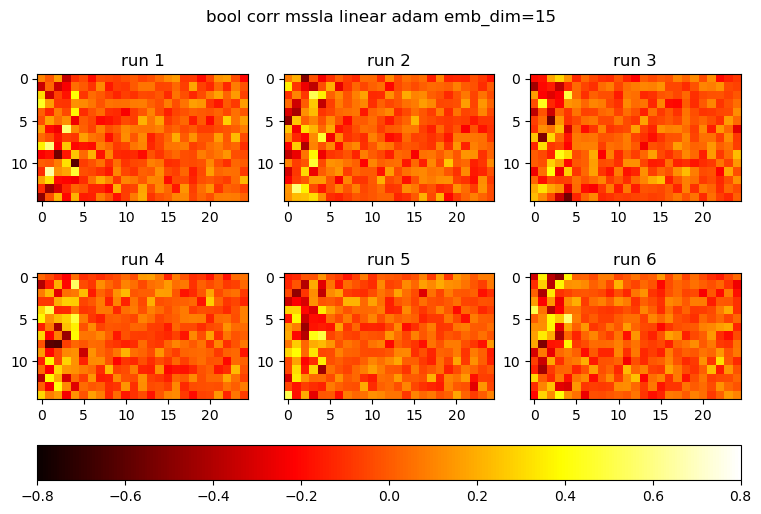

In [12]:
# WEIGHT MATRICES: bool corr, different tau per dimension, embd 15, mssla
dirs = [
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run6'
]
show_weights(dirs, plot_weights=True, subtitle=True, title=True)

In [13]:
# DOWNSTREAM ACCURACY for mssla, embd15, different tau per dimension
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies for MSSL (Corr, Diff Tau across dims, embd=k+h): {[acc.item() for acc in test_accs]}')
print(f'Test accuracy average: {avg_acc}')

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Test accuracies for MSSL (Corr, Diff Tau across dims, embd=k+h): [0.6060799956321716, 0.6015599966049194, 0.5016000270843506, 0.6048799753189087, 0.5853599905967712, 0.6520799994468689]
Test accuracy average: 0.591926634311676


MSSL appears to perform very slightly better downstream than Spectral.

## Varying tau ranges (different tau per dimension): Weights + Test Accs
Given results that we expect (and perhaps better performance from MSSL!), let's investigate whether varying the range of tau can give us better counterexamples, or tell us what varying tau does to representations. Four runs each.

### SPECTRAL

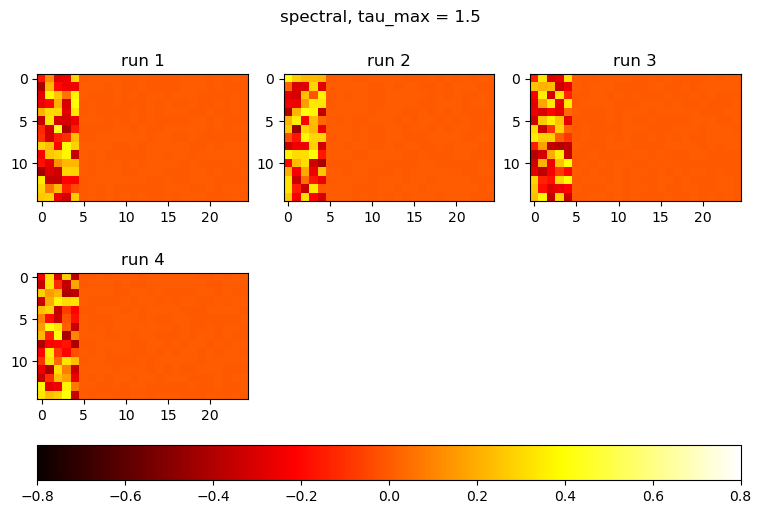

In [18]:
dirs = [
'./outputs/tau_max=1.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=1.5_run1',
'./outputs/tau_max=1.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=1.5_run2',
'./outputs/tau_max=1.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=1.5_run3',
'./outputs/tau_max=1.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=1.5_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 1.5')

In [20]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5547999739646912, 0.4942399859428406, 0.46827998757362366, 0.5093600153923035]
Average acciracy: 0.5066699981689453


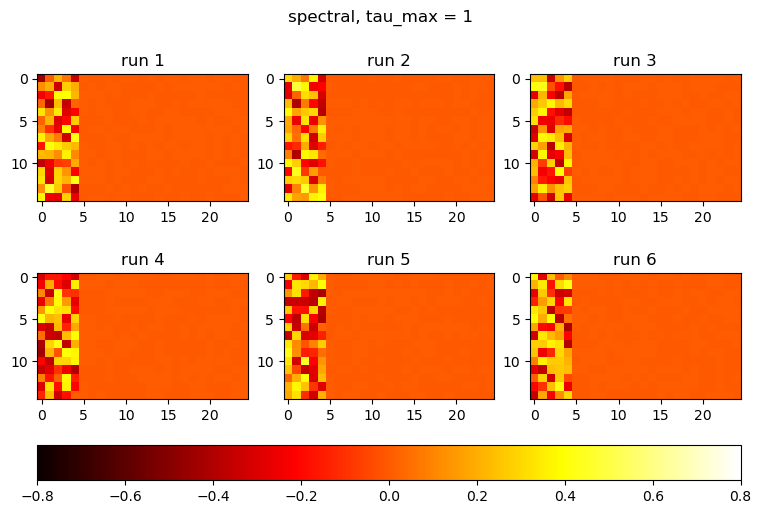

In [21]:
dirs = [
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run6',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 1')

In [22]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5545600056648254, 0.4943599998950958, 0.5552800297737122, 0.5115200281143188, 0.5138400197029114, 0.5763599872589111]
Average acciracy: 0.534320056438446


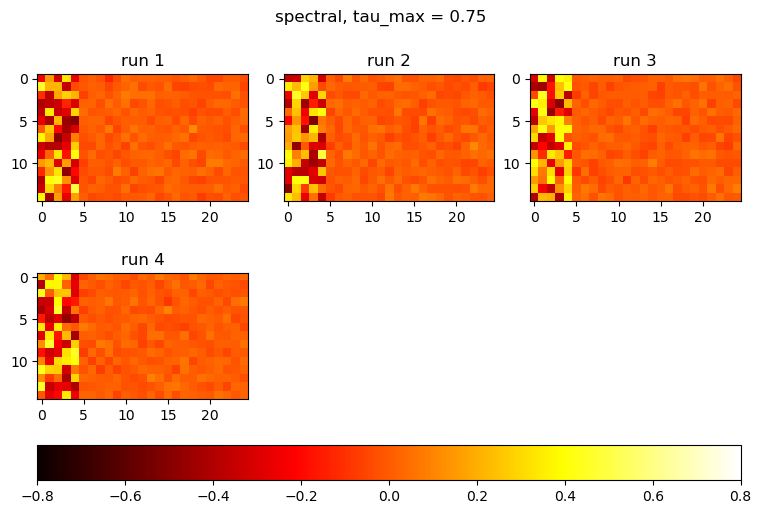

In [23]:
dirs = [
'./outputs/tau_max=0.75/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.75_run1',
'./outputs/tau_max=0.75/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.75_run2',
'./outputs/tau_max=0.75/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.75_run3',
'./outputs/tau_max=0.75/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.75_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.75')

In [24]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5557199716567993, 0.5588399767875671, 0.5929200053215027, 0.5027199983596802]
Average acciracy: 0.5525499582290649


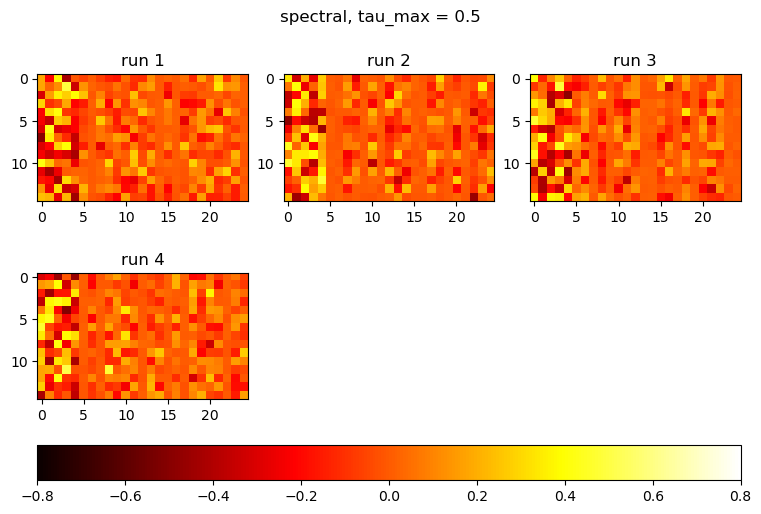

In [25]:
dirs = [
'./outputs/tau_max=0.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.5_run1',
'./outputs/tau_max=0.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.5_run2',
'./outputs/tau_max=0.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.5_run3',
'./outputs/tau_max=0.5/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.5_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.5')

In [26]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5523999929428101, 0.5932400226593018, 0.5820000171661377, 0.593280017375946]
Average acciracy: 0.5802299976348877


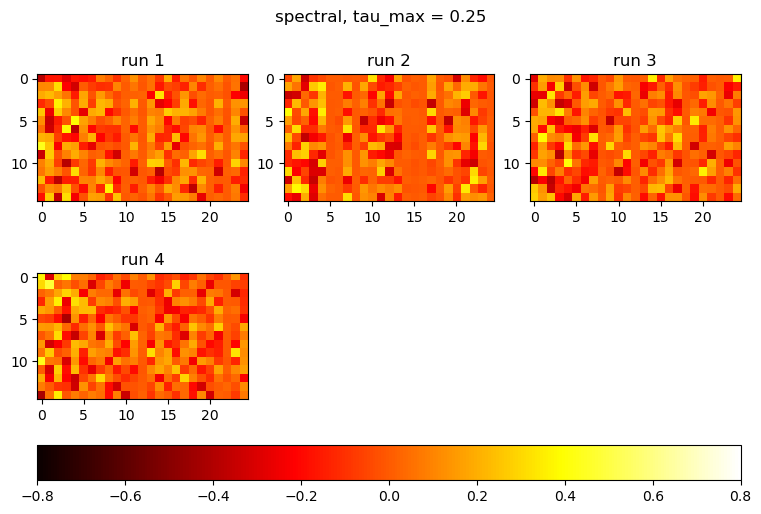

In [27]:
dirs = [
'./outputs/tau_max=0.25/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.25_run1',
'./outputs/tau_max=0.25/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.25_run2',
'./outputs/tau_max=0.25/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.25_run3',
'./outputs/tau_max=0.25/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.25_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.25')

In [28]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5670400261878967, 0.6345599889755249, 0.5628399848937988, 0.6446800231933594]
Average acciracy: 0.6022800207138062


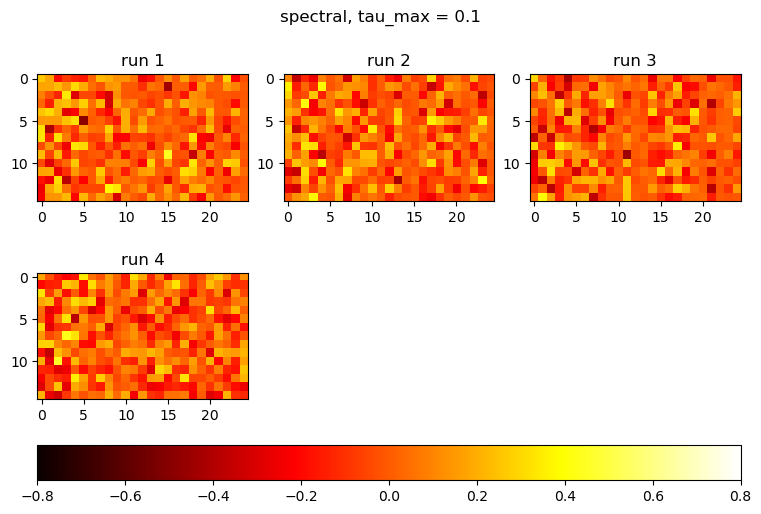

In [29]:
dirs = [
'./outputs/tau_max=0.1/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.1_run1',
'./outputs/tau_max=0.1/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.1_run2',
'./outputs/tau_max=0.1/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.1_run3',
'./outputs/tau_max=0.1/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.1_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.1')

In [30]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.7208799719810486, 0.5481600165367126, 0.5992400050163269, 0.6312400102615356]
Average acciracy: 0.6248799562454224


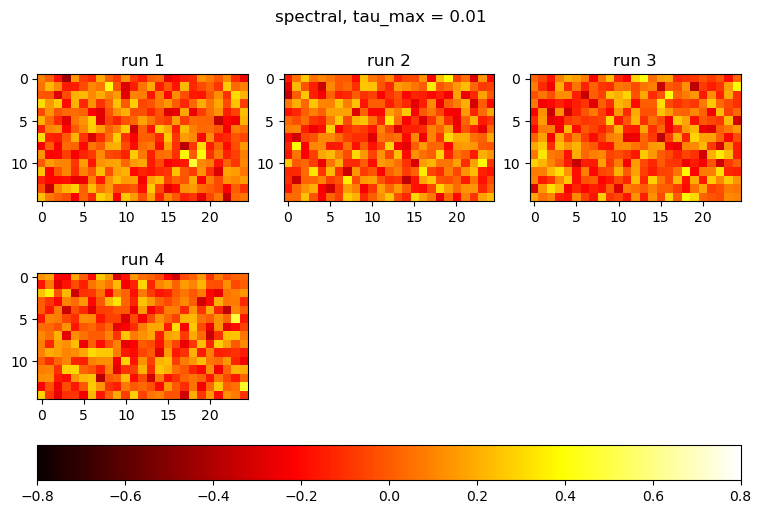

In [31]:
dirs = [
'./outputs/tau_max=0.01/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.01_run1',
'./outputs/tau_max=0.01/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.01_run2',
'./outputs/tau_max=0.01/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.01_run3',
'./outputs/tau_max=0.01/bool_corr_spur/spectral_linear_adam_emb_dim=15_tau_max=0.01_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral, tau_max = 0.01')

In [32]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.561519980430603, 0.7379999756813049, 0.6629199981689453, 0.6312400102615356]
Average acciracy: 0.648419976234436


### MSSL

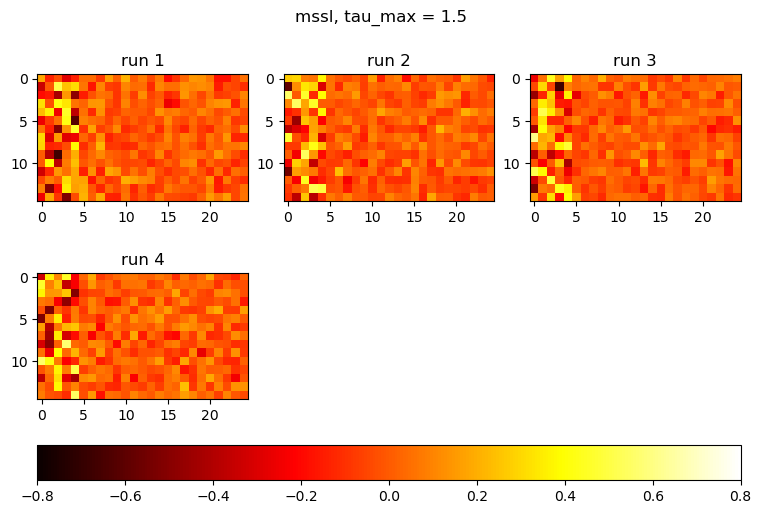

In [33]:
dirs = [
'./outputs/tau_max=1.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=1.5_run1',
'./outputs/tau_max=1.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=1.5_run2',
'./outputs/tau_max=1.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=1.5_run3',
'./outputs/tau_max=1.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=1.5_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 1.5')

In [34]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5290399789810181, 0.6737200021743774, 0.5184000134468079, 0.5665599703788757]
Average acciracy: 0.5719299912452698


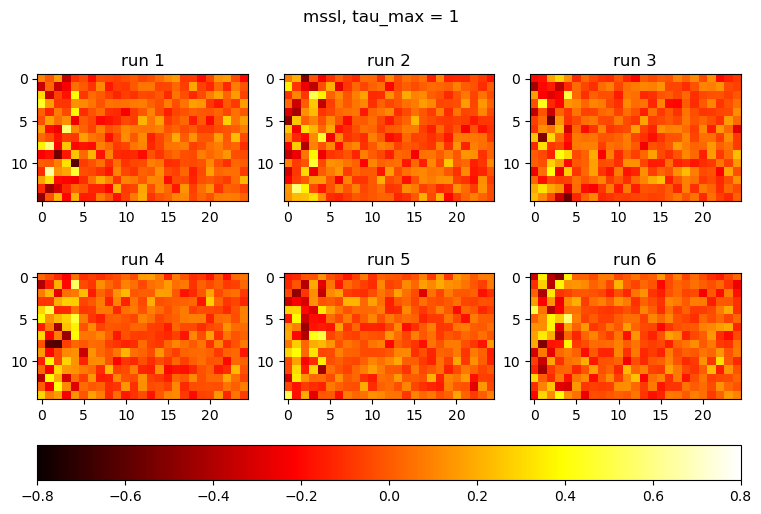

In [37]:
dirs = [
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run6',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 1')

In [38]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.6023600101470947, 0.6073600053787231, 0.5255600214004517, 0.616159975528717, 0.604200005531311, 0.5157600045204163]
Average acciracy: 0.5785666108131409


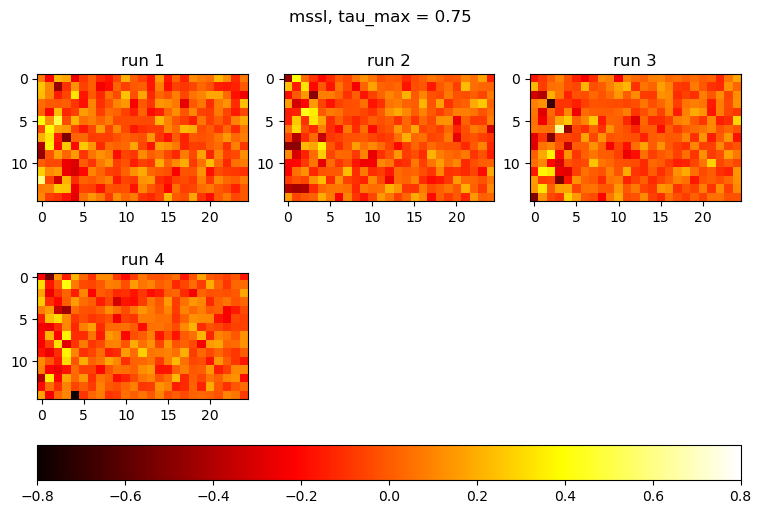

In [39]:
dirs = [
'./outputs/tau_max=0.75/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.75_run1',
'./outputs/tau_max=0.75/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.75_run2',
'./outputs/tau_max=0.75/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.75_run3',
'./outputs/tau_max=0.75/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.75_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.75')

In [40]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5317599773406982, 0.5280399918556213, 0.5484399795532227, 0.5960400104522705]
Average acciracy: 0.551069974899292


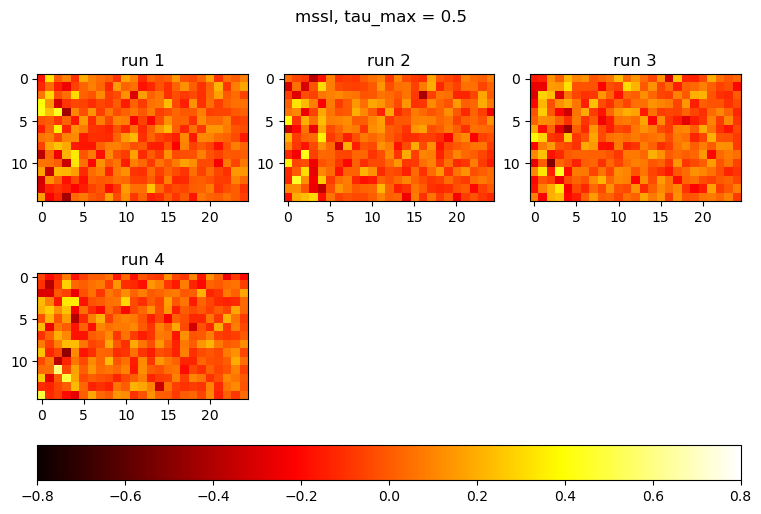

In [41]:
dirs = [
'./outputs/tau_max=0.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.5_run1',
'./outputs/tau_max=0.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.5_run2',
'./outputs/tau_max=0.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.5_run3',
'./outputs/tau_max=0.5/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.5_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.5')

In [42]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5181599855422974, 0.6031200289726257, 0.6420800089836121, 0.47699999809265137]
Average acciracy: 0.5600900053977966


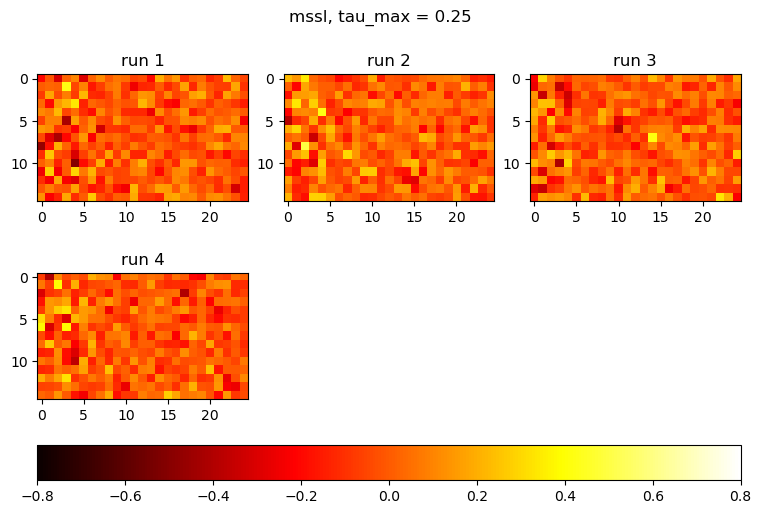

In [43]:
dirs = [
'./outputs/tau_max=0.25/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.25_run1',
'./outputs/tau_max=0.25/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.25_run2',
'./outputs/tau_max=0.25/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.25_run3',
'./outputs/tau_max=0.25/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.25_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.25')

In [44]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.679639995098114, 0.6543200016021729, 0.6047599911689758, 0.6159200072288513]
Average acciracy: 0.6386600136756897


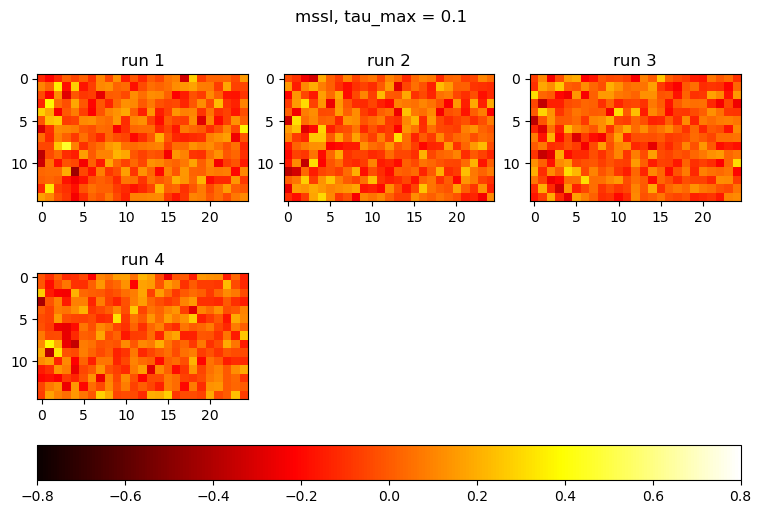

In [45]:
dirs = [
'./outputs/tau_max=0.1/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.1_run1',
'./outputs/tau_max=0.1/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.1_run2',
'./outputs/tau_max=0.1/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.1_run3',
'./outputs/tau_max=0.1/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.1_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.1')

In [46]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5942800045013428, 0.5461999773979187, 0.622160017490387, 0.6134799718856812]
Average acciracy: 0.5940300226211548


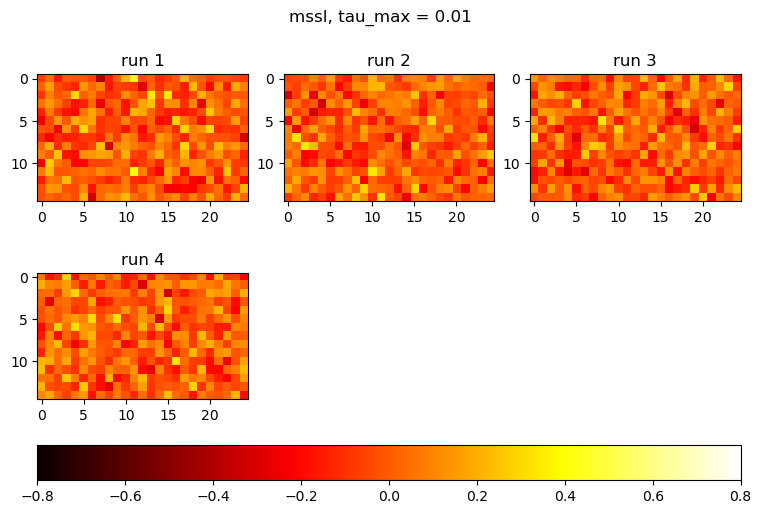

In [47]:
dirs = [
'./outputs/tau_max=0.01/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.01_run1',
'./outputs/tau_max=0.01/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.01_run2',
'./outputs/tau_max=0.01/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.01_run3',
'./outputs/tau_max=0.01/bool_corr_spur/mssla_linear_adam_emb_dim=15_tau_max=0.01_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl, tau_max = 0.01')

In [48]:
backbones, classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
test_accs, avg_acc = evaluate_classifiers(backbones, classifiers,  test=spur_test, test_labels=spur_test_labels)

print(f'Test accuracies: {[acc.item() for acc in test_accs]}')
print(f'Average acciracy: {avg_acc}')

Test accuracies: [0.5418800115585327, 0.6626399755477905, 0.5189200043678284, 0.5922399759292603]
Average acciracy: 0.5789200067520142


## Weights + Test Accs for Different Tasks (embd=15)

### CORR, tau_max = 1.0 for all runs.

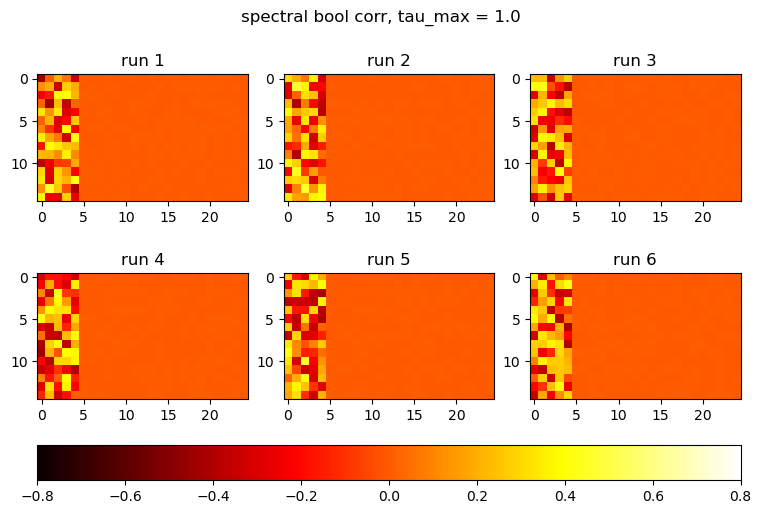

In [9]:
# CORR SPECTRAL
dirs = [
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run6',
]
# plot_metrics(dirs, plotall=True)
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral bool corr, tau_max = 1.0')

In [6]:
# DOWNSTREAM ACCURACIES
# LABEL = SUM OF AUGMENTED DIMS
spur_backbones, spur_classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
spur_test_accs, spur_avg_acc = evaluate_classifiers(spur_backbones, spur_classifiers,  test=spur_test, test_labels=spur_test_labels)
print('LABEL = SUM OF AUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in spur_test_accs]}')
print(f'Average accuracy: {spur_avg_acc}')
print()
# LABEL = SUM OF UNAUGMENTED DIMS
invkd_backbones, invkd_classifiers = fit_classifiers(dirs, val=invkd_val, val_labels=invkd_val_labels)
invkd_test_accs, invkd_avg_acc = evaluate_classifiers(invkd_backbones, invkd_classifiers,  test=invkd_test, test_labels=invkd_test_labels)
print('LABEL = SUM OF UNAUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in invkd_test_accs]}')
print(f'Average accuracy: {invkd_avg_acc}')

LABEL = SUM OF AUGMENTED DIMS:
Test accuracies : [0.4875999987125397, 0.5377200245857239, 0.5005599856376648, 0.5202000141143799, 0.5120000243186951, 0.5593199729919434]
Average accuracy: 0.5195667147636414

LABEL = SUM OF UNAUGMENTED DIMS:
Test accuracies : [0.8766800165176392, 0.7461199760437012, 0.7759199738502502, 0.842519998550415, 0.7680799961090088, 0.8768399953842163]
Average accuracy: 0.8143600821495056


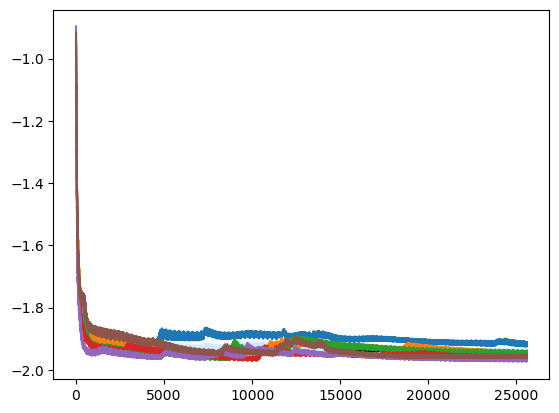

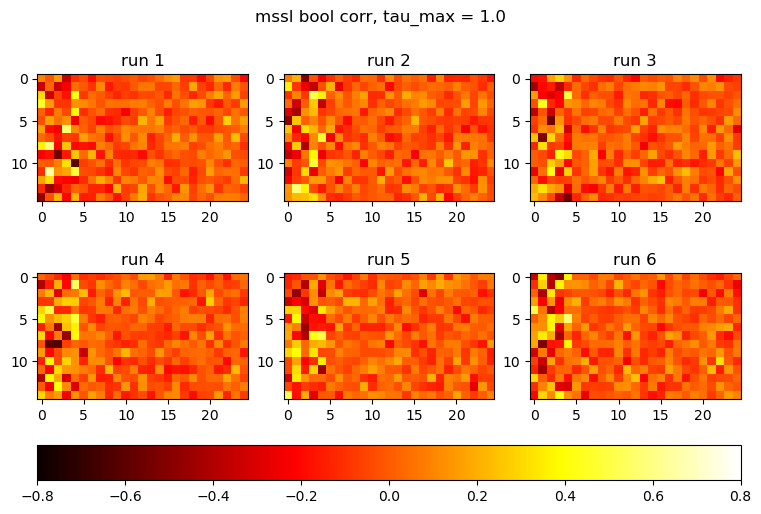

In [10]:
# CORR MSSL
dirs = [
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run6',
]
plot_metrics(dirs, plotall=True)
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl bool corr, tau_max = 1.0')

In [8]:
# DOWNSTREAM ACCURACIES
# LABEL = SUM OF AUGMENTED DIMS
spur_backbones, spur_classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
spur_test_accs, spur_avg_acc = evaluate_classifiers(spur_backbones, spur_classifiers,  test=spur_test, test_labels=spur_test_labels)
print('LABEL = SUM OF AUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in spur_test_accs]}')
print(f'Average accuracy: {spur_avg_acc}')
print()
# LABEL = SUM OF UNAUGMENTED DIMS
invkd_backbones, invkd_classifiers = fit_classifiers(dirs, val=invkd_val, val_labels=invkd_val_labels)
invkd_test_accs, invkd_avg_acc = evaluate_classifiers(invkd_backbones, invkd_classifiers,  test=invkd_test, test_labels=invkd_test_labels)
print('LABEL = SUM OF UNAUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in invkd_test_accs]}')
print(f'Average accuracy: {invkd_avg_acc}')

LABEL = SUM OF AUGMENTED DIMS:
Test accuracies : [0.6043599843978882, 0.4215199947357178, 0.5161200165748596, 0.6203600168228149, 0.5295199751853943, 0.5489599704742432]
Average accuracy: 0.5401400327682495

LABEL = SUM OF UNAUGMENTED DIMS:
Test accuracies : [0.6850399971008301, 0.6628000140190125, 0.7857599854469299, 0.7444000244140625, 0.7803599834442139, 0.7808399796485901]
Average accuracy: 0.7398666739463806


### ADD

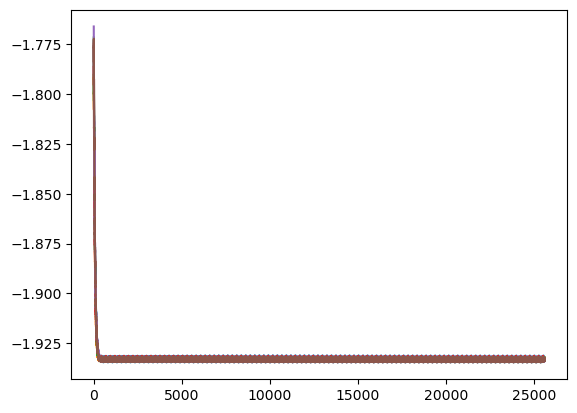

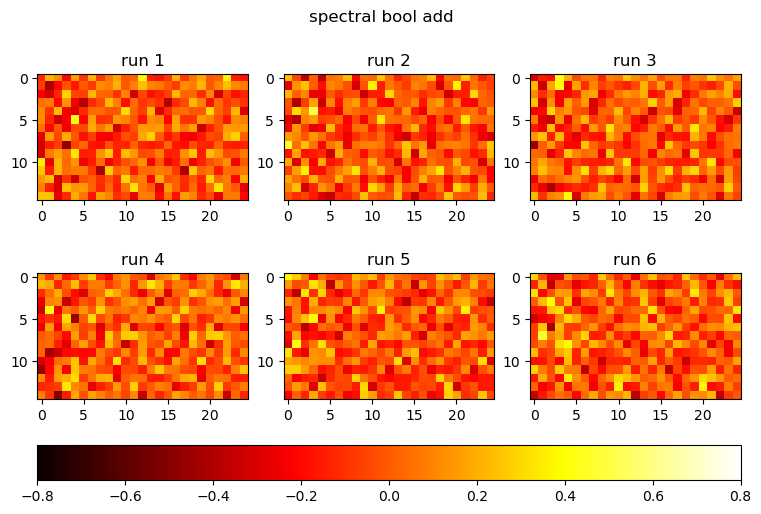

In [11]:
# ADD SPECTRAL
dirs = [
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run6',
]
# plot_metrics(dirs, plotall=True)
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral bool add')

In [10]:
# DOWNSTREAM ACCURACIES
# LABEL = SUM OF AUGMENTED DIMS
spur_backbones, spur_classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
spur_test_accs, spur_avg_acc = evaluate_classifiers(spur_backbones, spur_classifiers,  test=spur_test, test_labels=spur_test_labels)
print('LABEL = SUM OF AUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in spur_test_accs]}')
print(f'Average accuracy: {spur_avg_acc}')
print()
# LABEL = SUM OF UNAUGMENTED DIMS
invkd_backbones, invkd_classifiers = fit_classifiers(dirs, val=invkd_val, val_labels=invkd_val_labels)
invkd_test_accs, invkd_avg_acc = evaluate_classifiers(invkd_backbones, invkd_classifiers,  test=invkd_test, test_labels=invkd_test_labels)
print('LABEL = SUM OF UNAUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in invkd_test_accs]}')
print(f'Average accuracy: {invkd_avg_acc}')

LABEL = SUM OF AUGMENTED DIMS:
Test accuracies : [0.7996000051498413, 0.5635600090026855, 0.5551999807357788, 0.6101599931716919, 0.7182400226593018, 0.6324399709701538]
Average accuracy: 0.6465333104133606

LABEL = SUM OF UNAUGMENTED DIMS:
Test accuracies : [0.756600022315979, 0.7221999764442444, 0.8037599921226501, 0.5916000008583069, 0.6546400189399719, 0.6895599961280823]
Average accuracy: 0.70305997133255


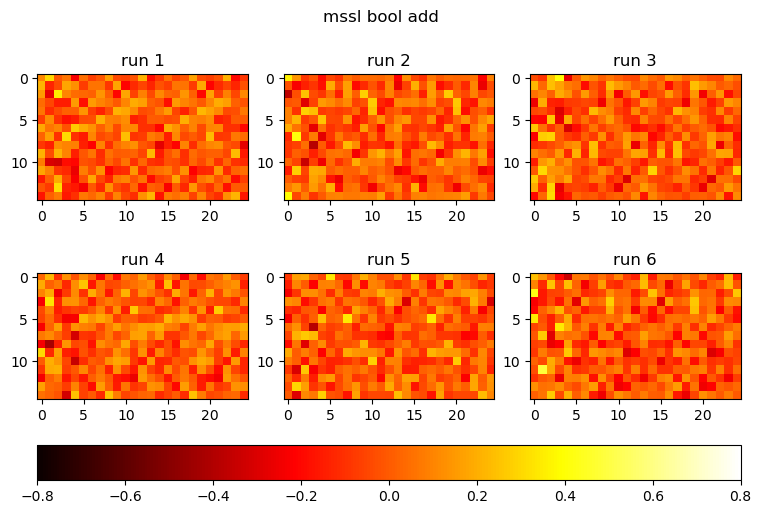

In [13]:
# ADD MSSL
dirs = [
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_add_spur/mssla_linear_adam_emb_dim=15_run6',
]
# plot_metrics(dirs, plotall=True)
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl bool add')

In [12]:
# DOWNSTREAM ACCURACIES
# LABEL = SUM OF AUGMENTED DIMS
spur_backbones, spur_classifiers = fit_classifiers(dirs, val=spur_val, val_labels=spur_val_labels)
spur_test_accs, spur_avg_acc = evaluate_classifiers(spur_backbones, spur_classifiers,  test=spur_test, test_labels=spur_test_labels)
print('LABEL = SUM OF AUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in spur_test_accs]}')
print(f'Average accuracy: {spur_avg_acc}')
print()
# LABEL = SUM OF UNAUGMENTED DIMS
invkd_backbones, invkd_classifiers = fit_classifiers(dirs, val=invkd_val, val_labels=invkd_val_labels)
invkd_test_accs, invkd_avg_acc = evaluate_classifiers(invkd_backbones, invkd_classifiers,  test=invkd_test, test_labels=invkd_test_labels)
print('LABEL = SUM OF UNAUGMENTED DIMS:')
print(f'Test accuracies : {[acc.item() for acc in invkd_test_accs]}')
print(f'Average accuracy: {invkd_avg_acc}')

LABEL = SUM OF AUGMENTED DIMS:
Test accuracies : [0.6386399865150452, 0.6719200015068054, 0.5733199715614319, 0.614359974861145, 0.6316800117492676, 0.6641600131988525]
Average accuracy: 0.6323466897010803

LABEL = SUM OF UNAUGMENTED DIMS:
Test accuracies : [0.6172800064086914, 0.8413599729537964, 0.7060400247573853, 0.7021200060844421, 0.5052400231361389, 0.6226400136947632]
Average accuracy: 0.6657800078392029


## Plot Assumptions (for embd=15)

Norm of 20 rows of Z1 for run 1: tensor([2.3334, 2.3352, 2.3327, 2.3746, 2.3212, 2.3535, 2.3532, 2.3725, 2.3260,
        2.3555, 2.3402, 2.3520, 2.3428, 2.3682, 2.3074, 2.3143, 2.2865, 2.3818,
        2.3341, 2.3545])
Average norm of differences in embeddings (6 runs): 0.016252363100647926, embed dim = 15
Average normalized contribution to norm of augmented dimensions for each run: [tensor(0.7474), tensor(0.6300), tensor(0.6994), tensor(0.6629), tensor(0.6223), tensor(0.7160)]


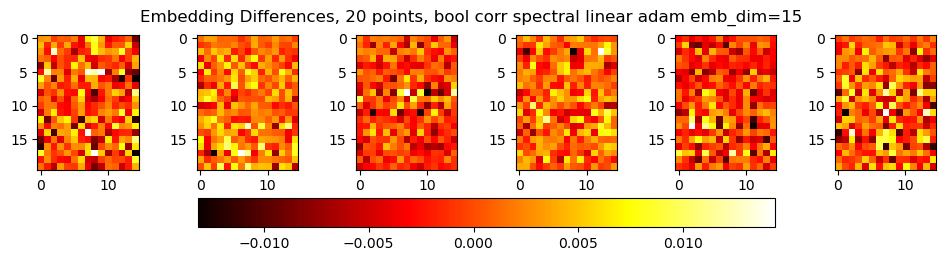

Norm of 100 rows of Z1 for run 1: tensor([2.3333, 2.3127, 2.3471, 2.3487, 2.3567, 2.3333, 2.3346, 2.2892, 2.3429,
        2.3352, 2.3517, 2.4085, 2.3054, 2.3381, 2.2875, 2.3974, 2.3195, 2.3706,
        2.3271, 2.3199, 2.3345, 2.3410, 2.3102, 2.3223, 2.3965, 2.3070, 2.3446,
        2.3647, 2.3289, 2.3772, 2.3302, 2.3548, 2.3735, 2.3628, 2.3579, 2.3186,
        2.3263, 2.3666, 2.3302, 2.3085, 2.3519, 2.3400, 2.3804, 2.3555, 2.3256,
        2.3470, 2.3658, 2.3512, 2.3194, 2.4116, 2.3723, 2.3280, 2.3638, 2.3481,
        2.3482, 2.3499, 2.3716, 2.4040, 2.3920, 2.3246, 2.3407, 2.3118, 2.3548,
        2.3642, 2.3627, 2.3323, 2.3495, 2.3024, 2.3869, 2.3361, 2.3709, 2.2890,
        2.3528, 2.3315, 2.3770, 2.3323, 2.3295, 2.3456, 2.3381, 2.3618, 2.3582,
        2.3850, 2.3255, 2.3018, 2.3285, 2.3333, 2.3382, 2.3576, 2.3597, 2.3055,
        2.3346, 2.3909, 2.3268, 2.3664, 2.3097, 2.3330, 2.3374, 2.3340, 2.3371,
        2.3015])
Average Frobenius norm of differences in covariances (6 runs): 0.0002

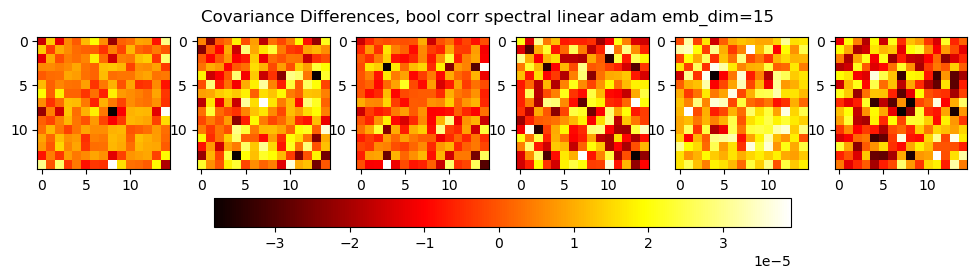

In [4]:
# SPECTRAL CORR
dirs = [
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/spectral_linear_adam_emb_dim=15_run6',
]
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

Norm of 20 rows of Z1 for run 1: tensor([3.3936, 3.1132, 2.9115, 2.5323, 2.4782, 2.5228, 3.1377, 2.1670, 3.0571,
        2.5740, 3.3371, 2.7518, 3.2195, 3.2912, 3.1542, 3.3431, 3.4626, 3.2979,
        2.4883, 2.6073])
Average norm of differences in embeddings (6 runs): 1.3221406936645508, embed dim = 15
Average normalized contribution to norm of augmented dimensions for each run: [tensor(0.6873), tensor(0.7329), tensor(0.7535), tensor(0.6660), tensor(0.6124), tensor(0.7201)]


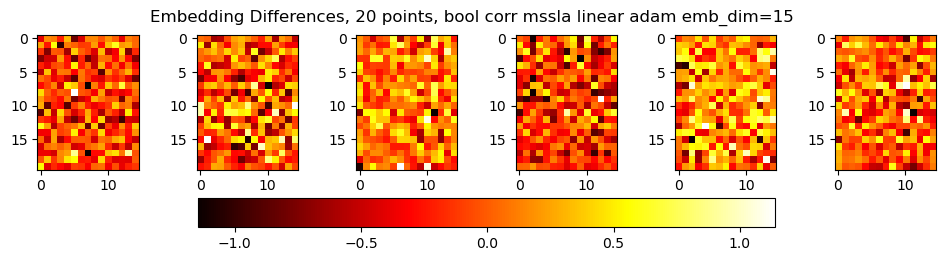

Norm of 100 rows of Z1 for run 1: tensor([3.6525, 2.7874, 3.1134, 2.5151, 3.7669, 2.6060, 2.8708, 3.3856, 3.5874,
        2.3653, 2.7586, 2.5580, 3.7634, 2.8387, 2.6066, 2.7552, 3.0442, 3.7020,
        2.6262, 3.1949, 3.3897, 3.2054, 2.8046, 3.4417, 2.7572, 2.7678, 2.4060,
        2.9776, 2.5876, 3.2978, 2.7575, 2.6352, 2.4812, 3.1337, 3.0986, 3.1742,
        2.8300, 3.2420, 3.1607, 2.6700, 3.2348, 3.9244, 2.9712, 2.9000, 3.4162,
        2.6406, 2.5598, 3.1607, 2.8676, 3.2714, 2.5063, 3.8457, 2.6725, 2.4811,
        2.4946, 2.9955, 2.6171, 3.2954, 3.4949, 2.7942, 2.5051, 3.1554, 3.0747,
        2.1939, 2.8964, 2.7059, 2.9723, 2.5300, 3.1149, 3.5595, 3.1656, 2.5892,
        3.1358, 3.6000, 4.5308, 2.4967, 3.8860, 2.3941, 3.1287, 2.9457, 3.2492,
        2.6064, 3.0268, 2.8179, 2.4910, 2.9354, 3.6411, 3.5177, 3.1119, 2.5693,
        3.1549, 2.9442, 3.3559, 3.3060, 2.6408, 2.5889, 3.5881, 2.5616, 2.2904,
        3.4032])
Average Frobenius norm of differences in covariances (6 runs): 0.0206

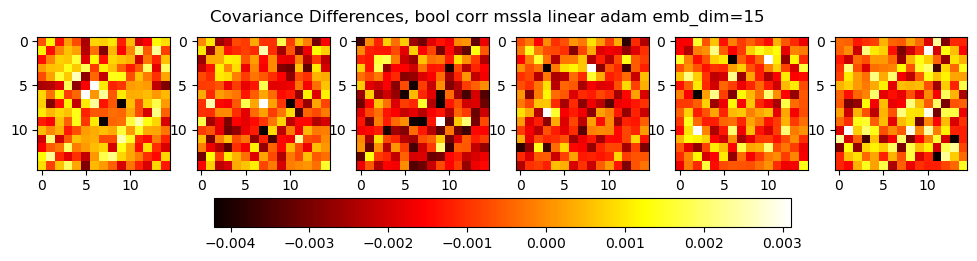

In [5]:
# MSSL CORR 
dirs = [
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run6',
]
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

Norm of 20 rows of Z1 for run 1: tensor([2.9601, 3.2972, 3.6766, 3.0396, 2.7475, 3.6995, 3.2402, 3.6878, 3.4575,
        3.7162, 3.6456, 3.4895, 3.6990, 3.3119, 3.2694, 3.7154, 3.2341, 3.2743,
        2.5537, 2.7035])
Average norm of differences in embeddings (6 runs): 0.010163584724068642, embed dim = 15
Average normalized contribution to norm of augmented dimensions for each run: [tensor(0.7496), tensor(0.7987), tensor(0.6701), tensor(0.6847), tensor(0.5966), tensor(0.7484)]


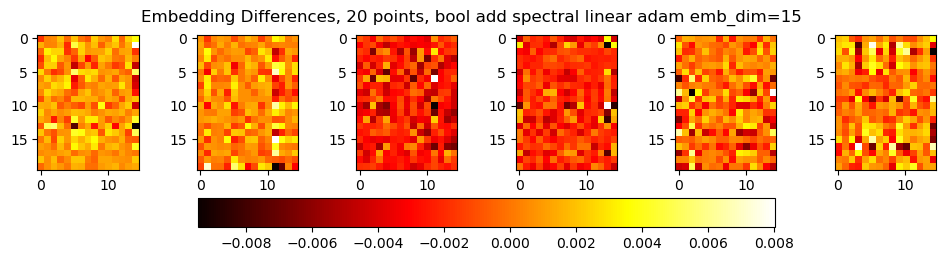

Norm of 100 rows of Z1 for run 1: tensor([3.2985, 3.2030, 3.3700, 2.7850, 3.5363, 3.0088, 2.7914, 2.6467, 3.2554,
        2.7729, 2.5508, 3.6872, 3.5237, 3.2844, 3.9194, 2.3669, 2.9568, 3.4531,
        2.6946, 2.8727, 3.2500, 3.5451, 3.1220, 3.4929, 3.2957, 3.0770, 3.2336,
        3.4898, 3.1038, 2.9524, 3.2379, 3.6452, 2.7998, 2.9424, 2.5927, 3.0702,
        3.0169, 3.8365, 3.3565, 3.0356, 2.7752, 3.6109, 3.2318, 3.8889, 3.5377,
        3.4145, 2.9792, 3.0232, 3.0412, 3.4192, 3.0475, 3.4090, 3.5243, 3.4771,
        3.0194, 3.5233, 2.5731, 3.1239, 3.2288, 3.3235, 2.6747, 3.4139, 3.2725,
        3.2855, 2.9966, 2.9878, 2.9808, 3.6664, 2.7489, 3.2696, 2.8220, 3.0198,
        3.4100, 2.7912, 3.2707, 3.5250, 2.9633, 3.5120, 3.4044, 3.0295, 2.4367,
        3.2905, 2.9563, 3.2374, 3.0704, 3.4176, 2.9126, 3.2568, 2.7238, 3.4147,
        3.2735, 3.1571, 2.7443, 3.7069, 3.2101, 3.2389, 3.2691, 2.5216, 3.2353,
        3.2284])
Average Frobenius norm of differences in covariances (6 runs): 0.0002

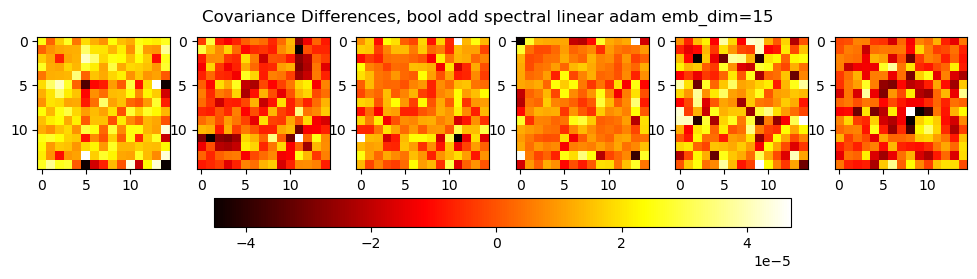

In [6]:
# SPECTRAL ADD
dirs = [
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_add_spur/spectral_linear_adam_emb_dim=15_run6',
]
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

Average norm of differences in embeddings (4 runs): 0.009822060354053974, embed dim = 10


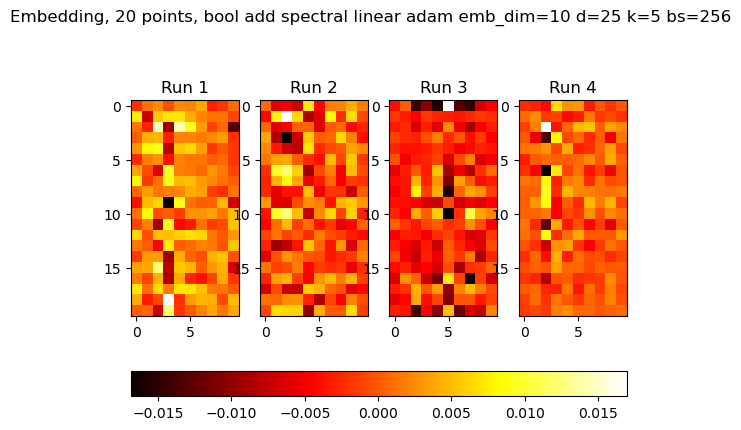

Average Frobenius norm of differences in covariances (4 runs): 0.00014511648623738438, embed dim = 10


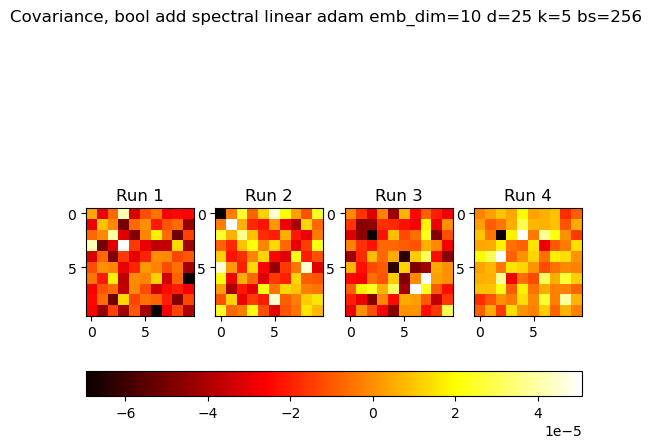

In [ ]:
# SPECTRAL ADD
dirs = [
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)

Average norm of differences in embeddings (4 runs): 0.09455543011426926, embed dim = 10


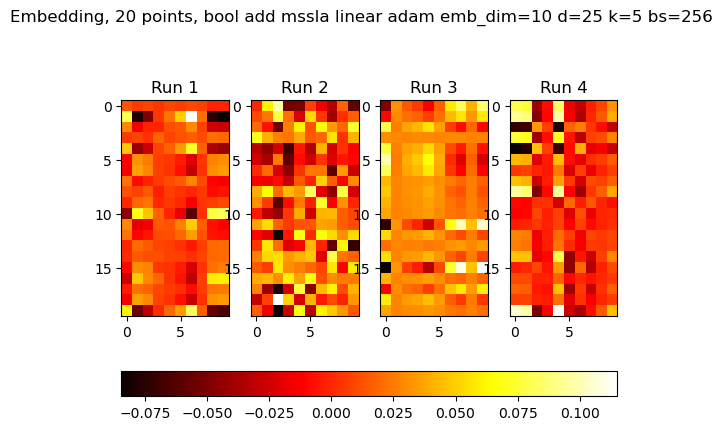

Average Frobenius norm of differences in covariances (4 runs): 0.001541726989671588, embed dim = 10


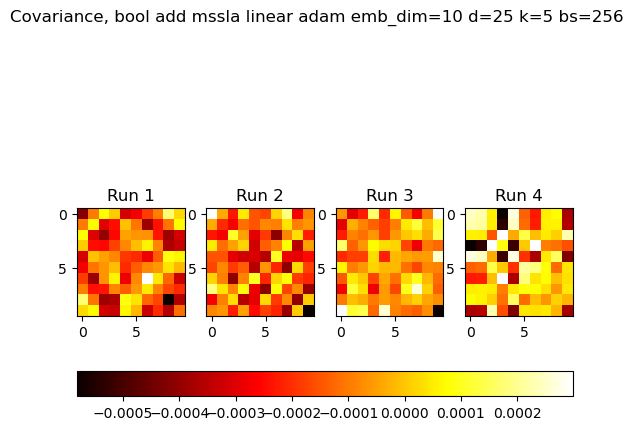

In [ ]:
# MSSL ADD
dirs = [
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)

## Hyperparam Tuning for Normal Aug (d=5, K=5, embd=5)

In [124]:
dir = './outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_bs=512_run1'
rd = torch.load(os.path.join(dir, 'run_dict'))

In [126]:
rd['args'].num_feats

5

In [18]:
gt_vecs = rd['data']['gt_vecs']
gt_vecs

[tensor([-0.9454, -0.7279, -1.4119, -0.1642, -0.3678]),
 tensor([-0.4729,  0.6644,  0.3818, -0.5983, -0.3819]),
 tensor([ 0.4089,  0.9149, -0.2711,  0.3261,  0.5041]),
 tensor([ 0.0336, -1.0274, -0.9307,  0.5766, -0.0280]),
 tensor([-0.7800, -1.5868, -0.7724,  1.5600, -0.5496])]

In [19]:
d = gt_vecs[0].shape[0] # dimension of single feature
K = len(gt_vecs) # number of features
std_mvn = MultivariateNormal(torch.zeros(K*d), torch.eye(K*d))
# label of any datum depends on only the first gt feature (gt_vecs[0])
label_vec = torch.zeros(K*d)
label_vec[:d] = gt_vecs[0]
val_data = std_mvn.sample((5,))
val_data @ label_vec

tensor([ 1.7936,  2.2091, -0.1100, -0.1650, -0.3310])

In [4]:
# for any run, use the first feature to determine the label
def evalaute_normal_downstream(dirs, n_val, n_test, gt_idx=0, plot_train=False, print_stats=False):
    """
    Given a list `dir` of run directories (presumed to be on 'normal' augmented data), evaluate the downstream performance of the learned representations by training a binary linear classifier on validation data, and testing classification accuracy on test data.

    Natural/unagumented test/validation data is assumed to be distributed according to an isotropic normal with dimensions equal to the number of features * dimension of each feature. The label for test and validation is determined by a single feature indicated by `gt_idx`, which indexes the feature in gt_vecs list from the run's saved output.

    `n_val`, `n_test` indicate how many points of validation/test data in the procedure described above.
    """
    test_scores = [] # downstream/test classification accuracy score for linear(emb_dim, 1) classifier fit onto validation data
    for idx, dir in enumerate(dirs):
        run_dict = torch.load(os.path.join(dir, 'run_dict'))
        gt_vecs = run_dict['data']['gt_vecs']
        d = gt_vecs[0].shape[0] # dimension of single feature
        K = len(gt_vecs) # number of features
        std_mvn = MultivariateNormal(torch.zeros(K*d), torch.eye(K*d))
        # have label of any datum depend only on the gt feature given by gt_idx
        label_vec = torch.zeros(K*d)
        label_vec[gt_idx*d:(gt_idx+1)*d] = gt_vecs[gt_idx]
        # Print true feature (that determines labels)
        if print_stats:
            print(f"Run {idx+1} label feature: {gt_vecs[gt_idx]}")
        weights = run_dict['model_weights']['weight']
        # Print weights corresponding to the labeling feature that have been learnt (to see if they are similar/well learnt)
        # print(f"Run {idx+1} feature weights: {weights[gt_idx, gt_idx*d:(gt_idx+1)*d]}")
        # TODO: reevaluate whether the learnt feature weights must necessarily be the same (or only need to be similar in some way to get good linear classif performance..)
        val_data = std_mvn.sample((n_val,))
        val_y = (torch.sign(val_data @ label_vec) + 1)/2
        test_data = std_mvn.sample((n_test,))
        test_y = (torch.sign(test_data @ label_vec) + 1)/2
        backbones, classifiers = fit_classifiers([dir], val_data, val_y, plot_train=plot_train)
        _, avg_acc = evaluate_classifiers(backbones, classifiers, test_data, test_y, print_stats=print_stats)
        test_scores.append(avg_acc) # since only one dir used
    avg_score = sum(test_scores) / len(test_scores)
    return test_scores, avg_score

def get_feature_downstream_scores(dirs, plot_train=False, print_stats=False):
    """
    Calls evaluate_normal_downstream for all possible features that define the label, for all directories in `dirs`. Assumes all runs in dirs are run on data with the same number of features.

    Returns an array of shape (len(dirs), num_features), where the (i, j)th entry denotes the downstream accuracy for run i, for downstream task based on feature j. Rows represent runs and columns represent features. A good representation should (at least) get good scores across the entire row.
    """
    run_dict = torch.load(os.path.join(dirs[0], 'run_dict'))
    num_feats = run_dict['args'].num_feats
    scores_array = np.zeros((len(dirs), num_feats)) # one row per run, one col per feature
    for i in range(num_feats):
        print(f"Feature {i+1}")
        test_scores, _ = evalaute_normal_downstream(dirs, n_val=10000, n_test=10000, gt_idx=i, plot_train=plot_train, print_stats=print_stats)
        test_scores_arr = np.array([score.item() for score in test_scores])
        scores_array[:, i] = test_scores_arr
    return scores_array
    

def generate_dotprod_correlation_matrix(dirs, n_samples=10000, plot=True, title=None):
    """
    Denote K = num features, d = dim of a feature.

    For each run in dirs, calculate the correlation matrix of the dimensions of embedding due to learnt weights and those of the 'ideal' weight matrix. The ideal matrix (with embedding dimension K) would have in its kth row the kth ground-truth vector in positions where it would be dot-producted with the kth feature in the data, and zeros everywhere else in the row - essentially a block diagonal with the blocks being row vectors.

    Correlation matrix calculated using `n_samples` natural data, which we define as distributed according to the standard normal distribution (in K*d dimensions)

    Note that since the embedding dimension of a run doesn't have to be K, the correlation matrix isn't necessarily square.
    """
    corr_matrices = []
    for dir in dirs:
        # load embedding weights, create ideal weight matrix
        run_dict = torch.load(os.path.join(dir, 'run_dict'))
        weights = run_dict['model_weights']['weight'] # (emb_dim, K*d)
        emb_dim = run_dict['args'].emb_dim
        gt_vecs = run_dict['data']['gt_vecs']
        d = gt_vecs[0].shape[0]
        K = len(gt_vecs)
        ideal_weights = torch.zeros(K, K*d) # ideal case where weight matrix has exactly learnt the corresponding feature
        for i in range(K):
            ideal_weights[i, i*d:(i+1)*d] = gt_vecs[i]
        # generate downstream (normal) data
        std_mvn = MultivariateNormal(torch.zeros(K*d), torch.eye(K*d))
        samples = std_mvn.sample((n_samples,)) # (n_samples, K*d)
        embeds = samples @ weights.T # (n_samples, emb_dim)
        ideal_embeds = samples @ ideal_weights.T # (n_samples, K)
        # obtain correlation matrix
        stdized_embeds = (embeds - torch.mean(embeds, dim=0)) / torch.std(embeds, dim=0)
        stdized_ideal_embeds = (ideal_embeds - torch.mean(ideal_embeds, dim=0)) / torch.std(ideal_embeds, dim=0)
        corr_matrix = (stdized_embeds.T @ stdized_ideal_embeds) / (n_samples - 1) # (emb_dim, K)
        corr_matrices.append(corr_matrix)
    if plot:
        subplot_width = 3
        subplot_height = 3
        fig, ax = plt.subplots(1, len(dirs), figsize=(subplot_width*len(dirs), subplot_height), constrained_layout=True)
        for i in range(len(corr_matrices)):
            curr_ax = ax if len(dirs) == 1 else ax[i]
            im = curr_ax.imshow(corr_matrices[i], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
            curr_ax.set_xticks([])
            curr_ax.set_yticks([])

            for j in range(corr_matrices[i].shape[0]):
                for k in range(corr_matrices[i].shape[1]):
                    text = curr_ax.text(k, j, f"{corr_matrices[i][j, k]:.2f}",
                       ha="center", va="center", color="w")
        cbar_ax = ax if len(dirs) == 1 else ax[:]
        fig.colorbar(im, ax=cbar_ax, location='bottom', orientation='horizontal')
        # fig.add_axes[]
        if title:
            fig.suptitle(title)
        plt.subplot(1, len(dirs), 1)
        plt.text(-0.1, 0.5, 'Embedding Prods', transform=plt.gca().transAxes, rotation=90, ha='center', va='center')
        plt.text(0.5, 1.1, 'Ideal Prods', transform=plt.gca().transAxes, ha='center', va='center')
        plt.show()
    else:
        return corr_matrices

### Second round hyperparam tuning

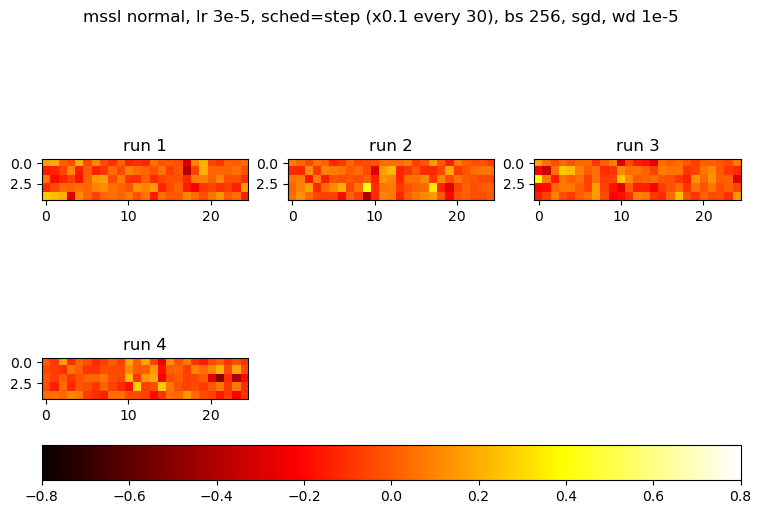

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


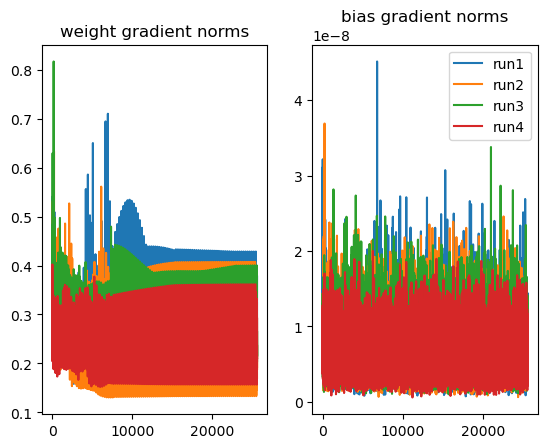

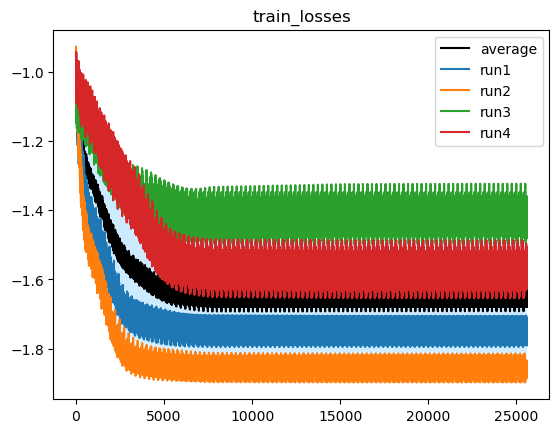

array([[0.95310003, 0.52380002, 0.6476    , 0.94580001, 0.55080003],
       [0.7008    , 0.9429    , 0.92839998, 0.85780001, 0.5722    ],
       [0.9181    , 0.77289999, 0.9436    , 0.68080002, 0.69459999],
       [0.56169999, 0.53920001, 0.95539999, 0.58920002, 0.93809998]])

In [9]:
# fixed transpose problem in mssl... lr = 3e-4 sgd sched step
dirs = [
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run1',
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run2',
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run3',
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 3e-5, sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr

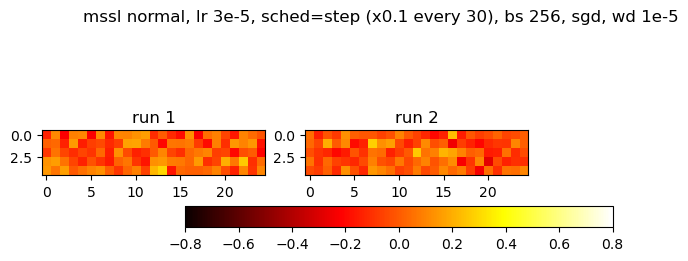

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


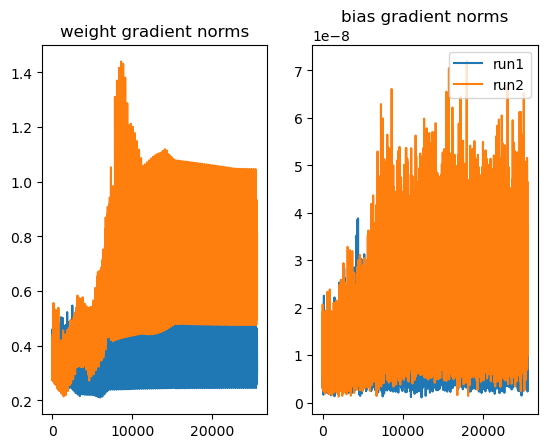

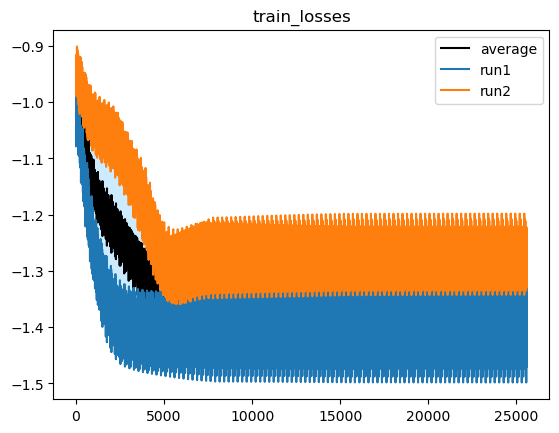

array([[0.63660002, 0.61220002, 0.74529999, 0.58969998, 0.84399998],
       [0.64770001, 0.55140001, 0.59530002, 0.69520003, 0.60659999]])

In [6]:
# fixed transpose problem in mssl... lr = 1e-4 sgd sched step
dirs = [
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0001_sched=step_run1',
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0001_sched=step_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 3e-5, sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr

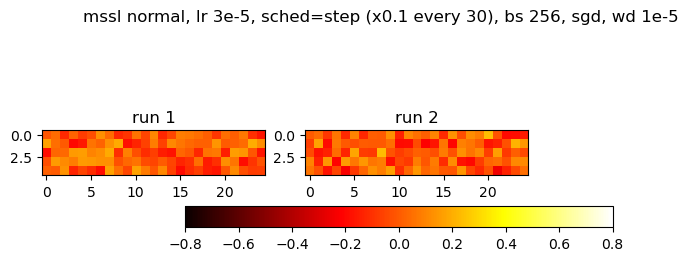

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


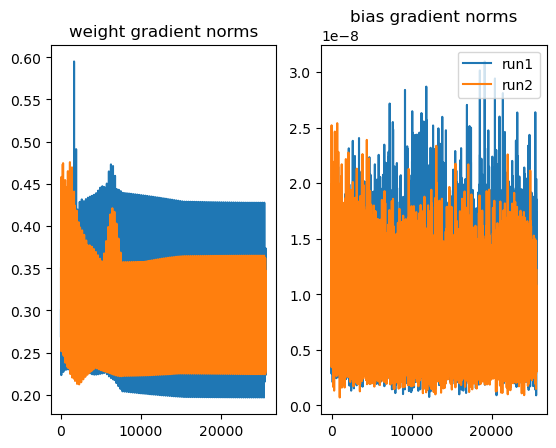

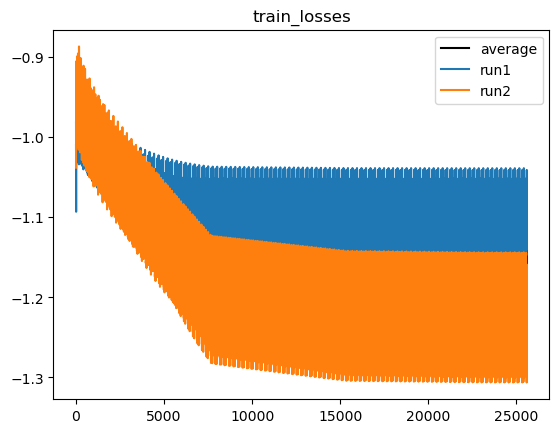

array([[0.64569998, 0.65640002, 0.64420003, 0.6807    , 0.67290002],
       [0.6961    , 0.68220001, 0.57480001, 0.58459997, 0.68440002]])

In [5]:
# fixed transpose problem in mssl...
dirs = [
'./outputs/normal_mssl_lossfix/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=3e-05_sched=step_run1',
'./outputs/normal_mssl_lossfix/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=3e-05_sched=step_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 3e-5, sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr

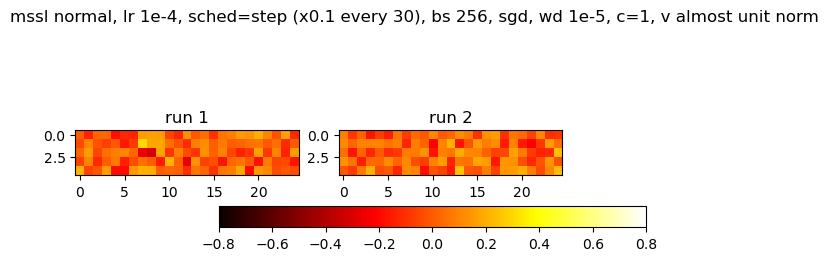

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


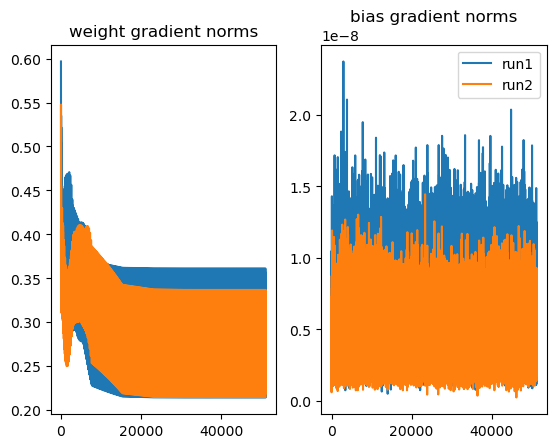

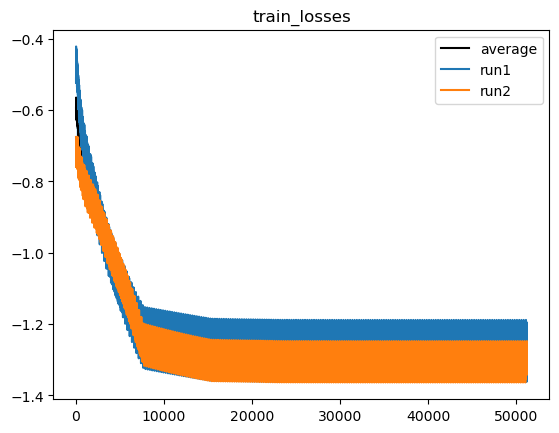

array([[0.65530002, 0.84280002, 0.62129998, 0.60039997, 0.60049999],
       [0.60460001, 0.64960003, 0.71490002, 0.6652    , 0.71160001]])

In [11]:
# lr 3e-5 sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5, epochs 200,  c = 1, v almost unit norm
dirs = [
'./outputs/unitvec_cnear1_torch_cholesky/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=3e-05_sched=step_run1',
'./outputs/unitvec_cnear1_torch_cholesky/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=3e-05_sched=step_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 1e-4, sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5, c=1, v almost unit norm')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr

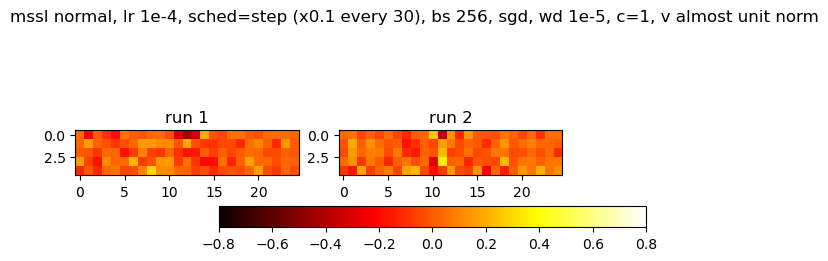

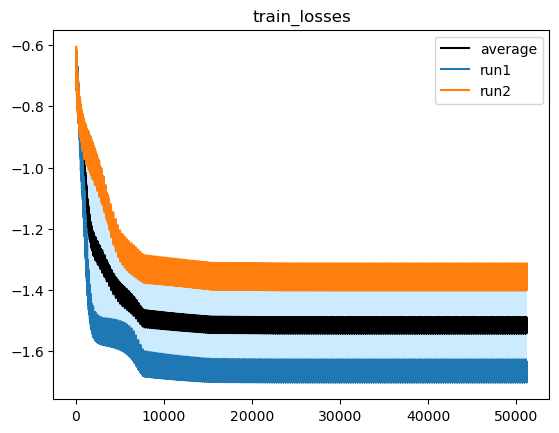

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


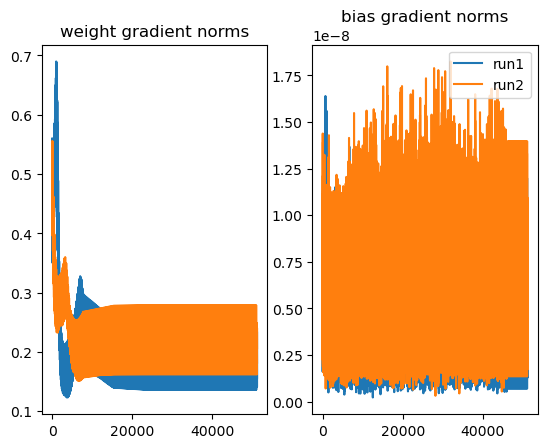

array([[0.65039998, 0.85720003, 0.86860001, 0.56599998, 0.57840002],
       [0.7062    , 0.61140001, 0.87900001, 0.70709997, 0.63480002]])

In [9]:
# lr 1e-4 sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5, epochs 200, c = 1 v almost unit norm
dirs = [
'outputs/unitvec_cnear1_torch_cholesky/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=0.0001_sched=step_run1',
'outputs/unitvec_cnear1_torch_cholesky/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=0.0001_sched=step_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 1e-4, sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5, c=1, v almost unit norm')
plot_metrics(dirs, plotall=True)
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
score_arr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


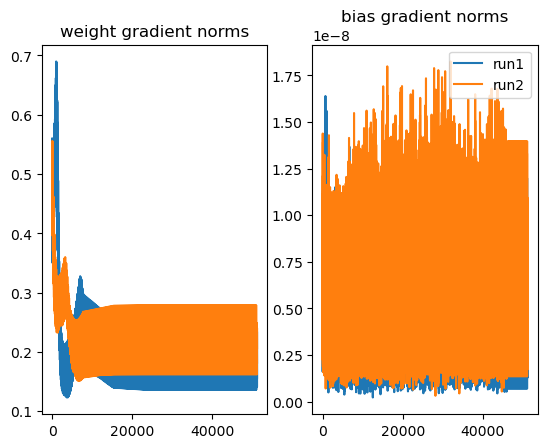

In [8]:
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)

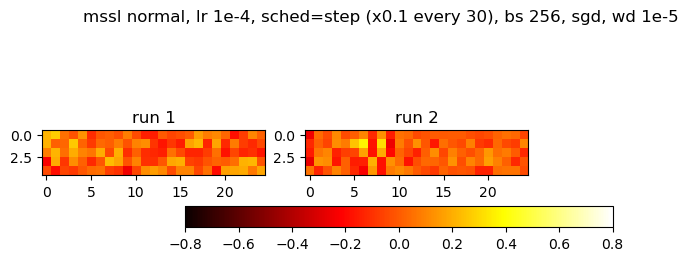

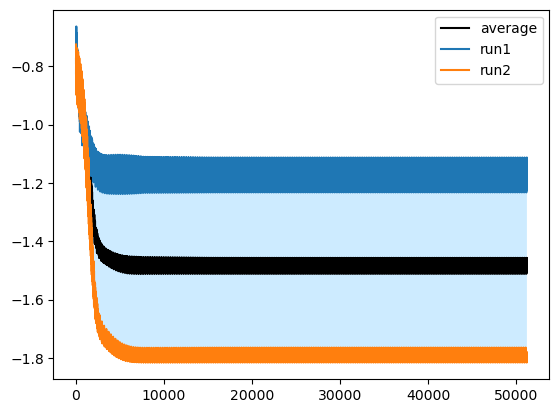

array([[0.78329998, 0.78750002, 0.63739997, 0.72259998, 0.65530002],
       [0.81809998, 0.95749998, 0.64039999, 0.57029998, 0.55500001]])

In [14]:
# lr 1e-4 sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5, epochs 200, 
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=0.0001_sched=step_run1',
'./outputs/normal_hparam_tuning/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=0.0001_sched=step_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 1e-4, sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5')
plot_metrics(dirs, plotall=True)
score_arr

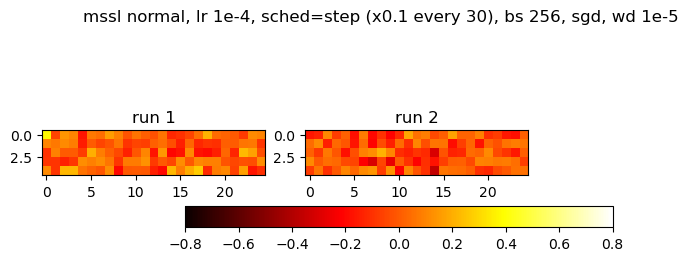

In [5]:
# lr 1e-4 sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5, epochs 200, 
# again but with gradient norm plots
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=0.0001_sched=step_run3',
'./outputs/normal_hparam_tuning/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=0.0001_sched=step_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 1e-4, sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5')
# plot_metrics(dirs, toplot='gradient_norms', plotall=True, aggregate=False)


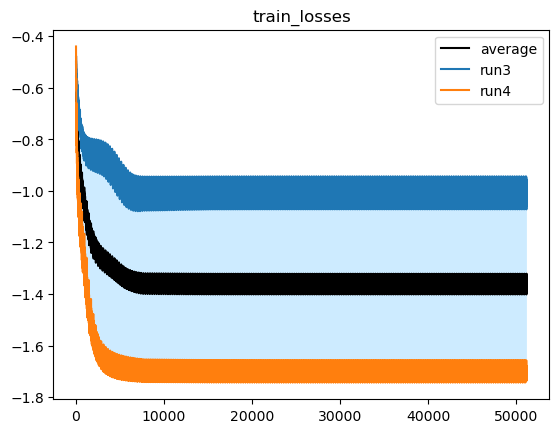

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


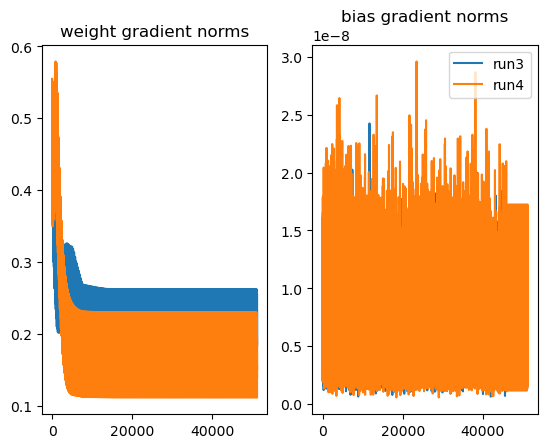

array([[0.85900003, 0.6645    , 0.50910002, 0.5916    , 0.55989999],
       [0.64880002, 0.96829998, 0.96689999, 0.65600002, 0.58719999]])

In [6]:
plot_metrics(dirs, toplot='train_losses', plotall=True)
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
score_arr

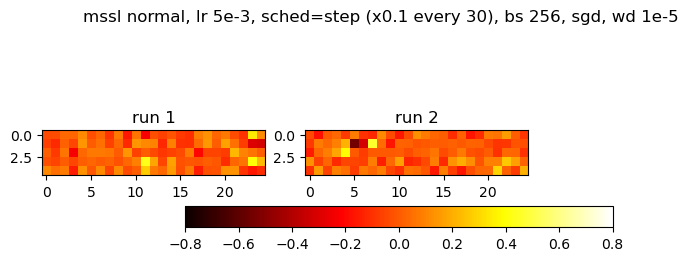

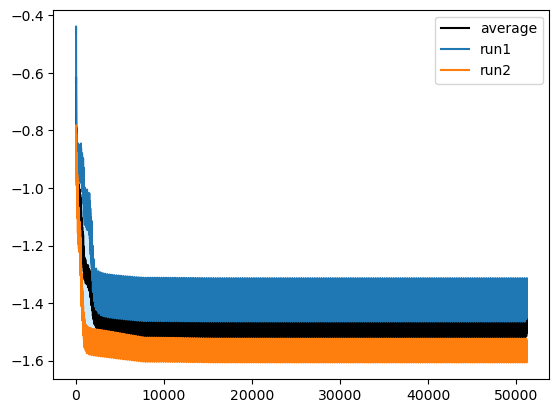

array([[0.59420002, 0.53240001, 0.95200002, 0.62809998, 0.96640003],
       [0.93989998, 0.94520003, 0.57359999, 0.62660003, 0.91759998]])

In [11]:
# lr 1e-3 sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5, epochs 200, 
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_sched=step_run1',
'./outputs/normal_hparam_tuning/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_sched=step_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 5e-3, sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5')
plot_metrics(dirs, plotall=True)
score_arr

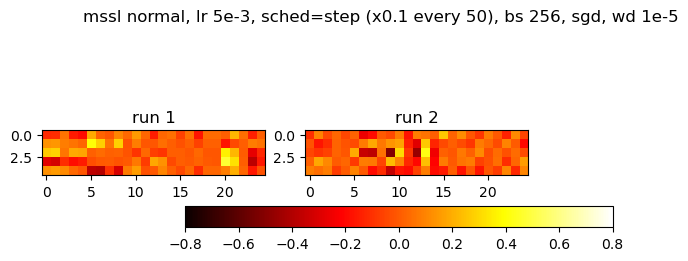

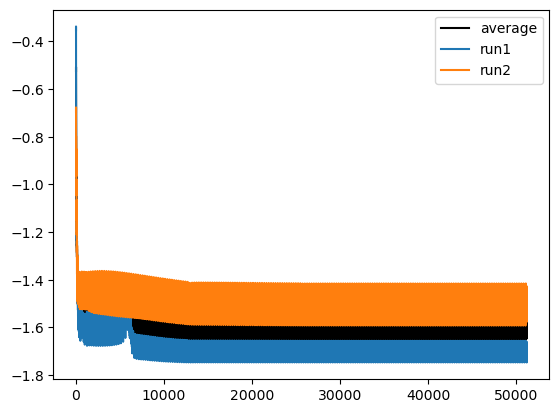

array([[0.9418    , 0.97589999, 0.85339999, 0.51880002, 0.97000003],
       [0.6771    , 0.96249998, 0.96280003, 0.56400001, 0.5654    ]])

In [9]:
# lr 5e-3 sched=step (x0.1 every 50), bs 256, sgd, wd 1e-5, epochs 200, 
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=0.005_sched=step_run1',
'./outputs/normal_hparam_tuning/normal/mssla_linear_sgd_emb_dim=5_aug=normal_epochs=200_lr=0.005_sched=step_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 5e-3, sched=step (x0.1 every 50), bs 256, sgd, wd 1e-5')
plot_metrics(dirs, plotall=True)
score_arr

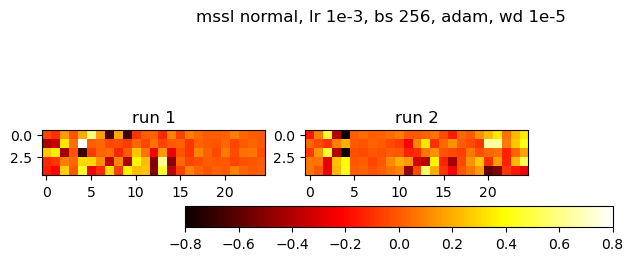

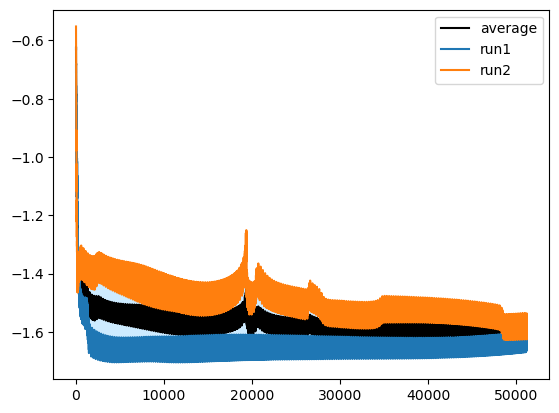

array([[0.9824    , 0.99129999, 0.98449999, 0.65329999, 0.50950003],
       [0.9874    , 0.51279998, 0.98549998, 0.51609999, 0.98640001]])

In [13]:
# lr 1e-3, bs 256, adam, wd 1e-5, epochs 200
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_epochs=200_run1',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_epochs=200_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 1e-3, bs 256, adam, wd 1e-5')
plot_metrics(dirs, plotall=True)
score_arr

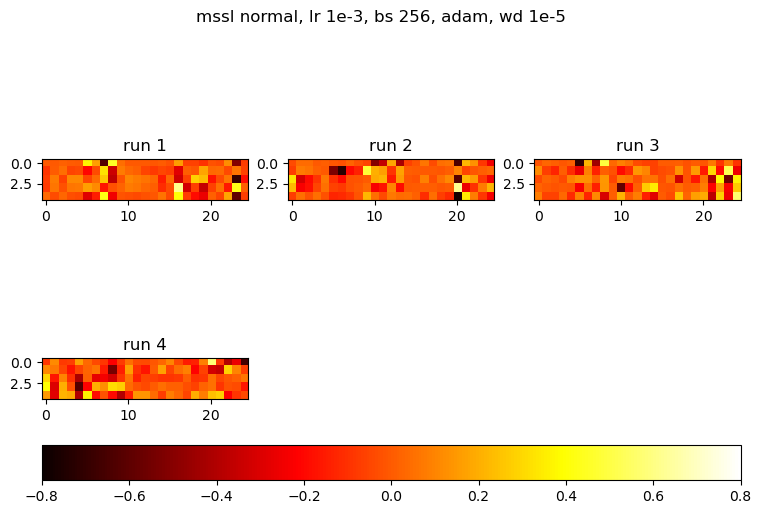

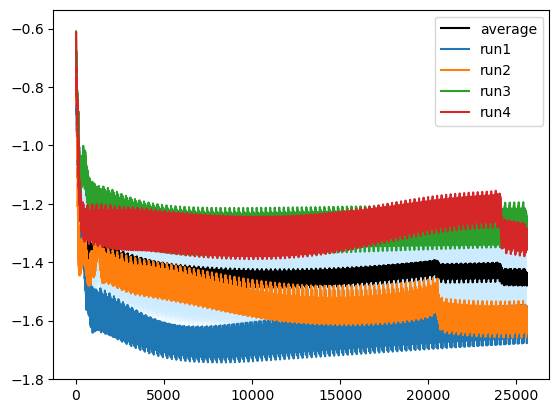

array([[0.61080003, 0.97689998, 0.583     , 0.98369998, 0.9849    ],
       [0.93550003, 0.97979999, 0.96679997, 0.51279998, 0.98830003],
       [0.51380002, 0.97909999, 0.97490001, 0.5402    , 0.98100001],
       [0.98839998, 0.98229998, 0.51599997, 0.58050001, 0.92430001]])

In [11]:
# lr 1e-3, bs 256, adam, wd 1e-5
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_run1',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_run2',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_run3',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 1e-3, bs 256, adam, wd 1e-5')
plot_metrics(dirs, plotall=True)
score_arr

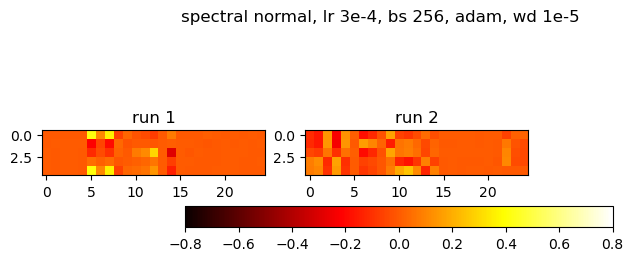

array([[0.50760001, 0.99129999, 0.98930001, 0.4878    , 0.4928    ],
       [0.98940003, 0.98390001, 0.99059999, 0.50129998, 0.96469998]])

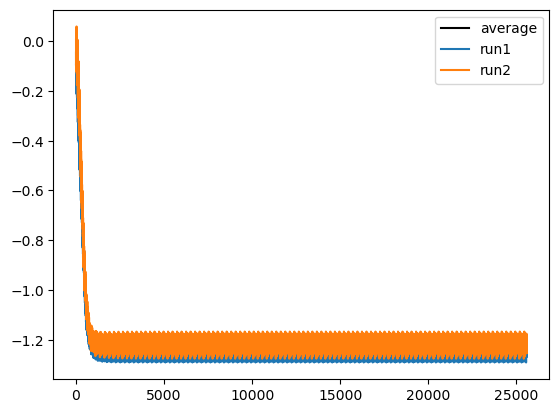

In [5]:
# spectral lr 3e-4, bs 256, adam, wd 1e-5
dirs = [
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_lr=0.0003_run1',
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_lr=0.0003_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral normal, lr 3e-4, bs 256, adam, wd 1e-5')
plot_metrics(dirs, plotall=True)
score_arr

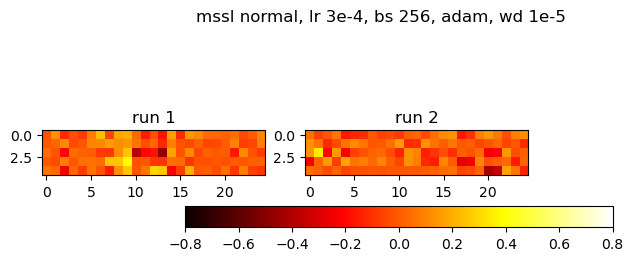

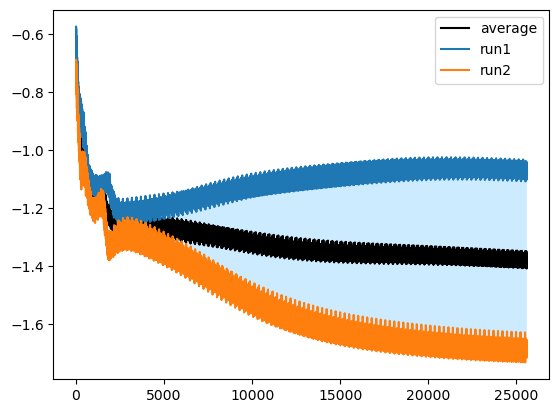

array([[0.57429999, 0.94230002, 0.94679999, 0.51660001, 0.5607    ],
       [0.89139998, 0.5262    , 0.53899997, 0.91759998, 0.93489999]])

In [6]:
# mssl lr 3e-4, bs 256, adam, wd 1e-5 
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_lr=0.0003_run1',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_lr=0.0003_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 3e-4, bs 256, adam, wd 1e-5')
plot_metrics(dirs, plotall=True)
score_arr

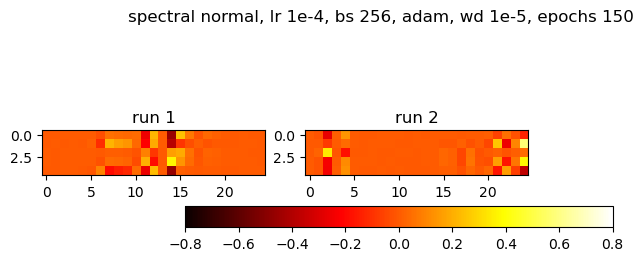

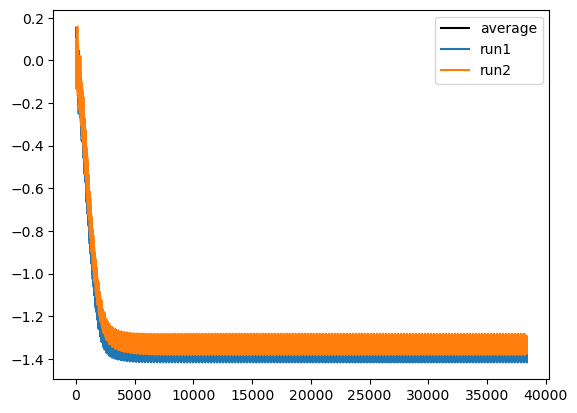

In [52]:
# spectral lr 1e-4, bs 256, adam, wd 1e-5, epochs 150
dirs = [
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_epochs=150_lr=0.0001_run1',
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_epochs=150_lr=0.0001_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral normal, lr 1e-4, bs 256, adam, wd 1e-5, epochs 150')
plot_metrics(dirs, plotall=True)
score_arr

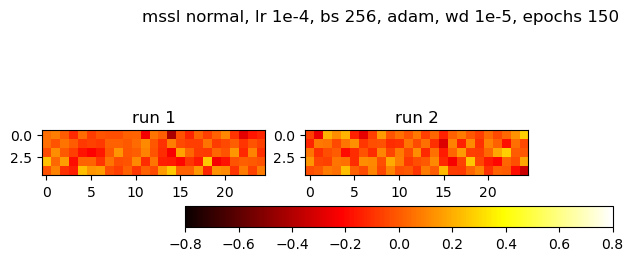

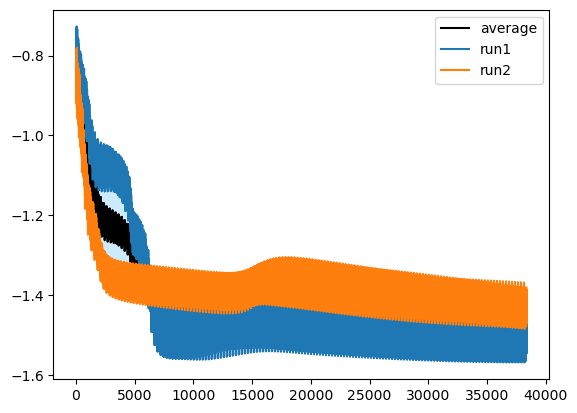

array([[0.90319997, 0.57309997, 0.8664    , 0.6268    , 0.76709998],
       [0.82300001, 0.69859999, 0.55809999, 0.90619999, 0.90030003]])

In [7]:
# mssl lr 1e-4, bs 256, adam, wd 1e-5, epochs 150
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_epochs=150_lr=0.0001_run1',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_epochs=150_lr=0.0001_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 1e-4, bs 256, adam, wd 1e-5, epochs 150')
plot_metrics(dirs, plotall=True)
score_arr

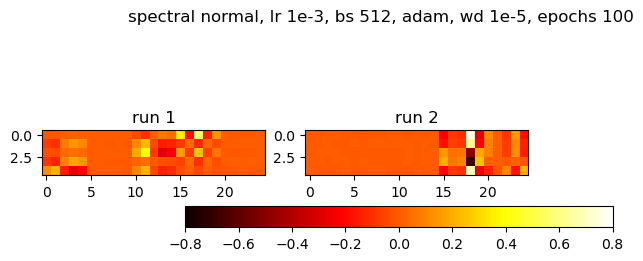

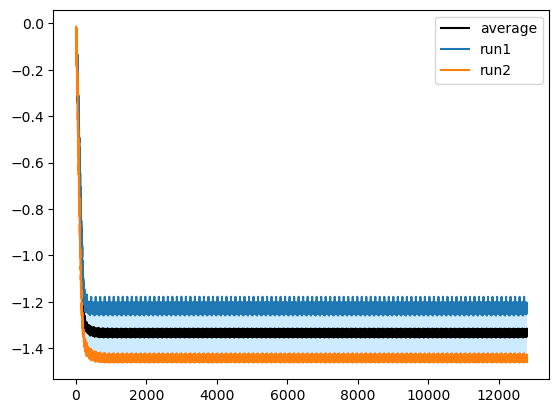

array([[0.9853    , 0.50190002, 0.991     , 0.9921    , 0.50449997],
       [0.51899999, 0.49689999, 0.5126    , 0.9946    , 0.9878    ]])

In [8]:
# spectral lr 1e-3, bs 512, adam, wd 1e-5, epochs 100
dirs = [
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_bs=512_run1',
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_bs=512_run2',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral normal, lr 1e-3, bs 512, adam, wd 1e-5, epochs 100')
plot_metrics(dirs, plotall=True)
score_arr

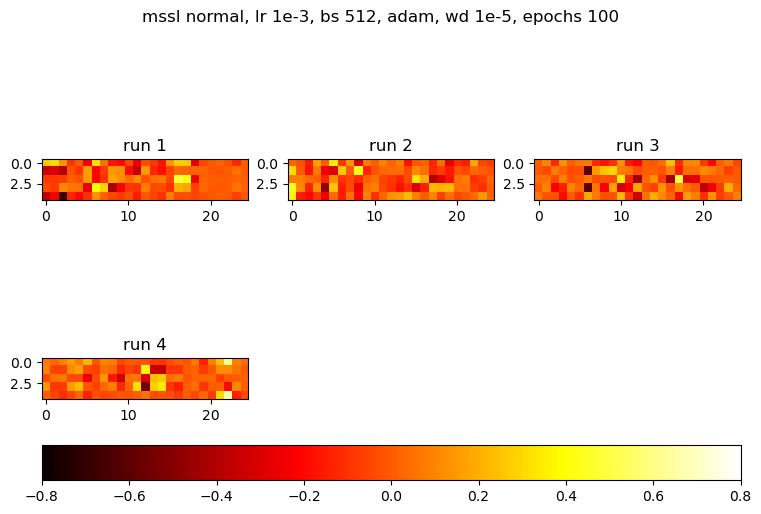

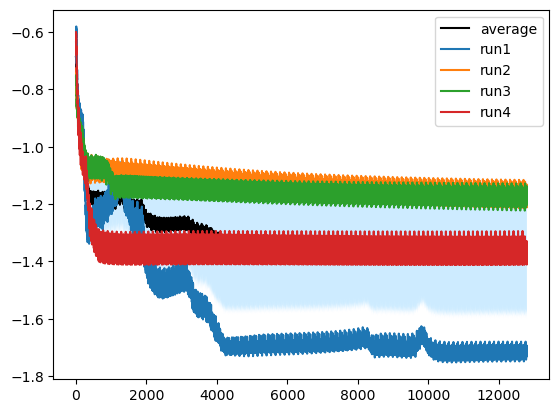

array([[0.95279998, 0.9637    , 0.9447    , 0.98199999, 0.5693    ],
       [0.9777    , 0.97659999, 0.62120003, 0.98079997, 0.55790001],
       [0.66180003, 0.9777    , 0.9447    , 0.97229999, 0.53320003],
       [0.75300002, 0.95719999, 0.96020001, 0.65020001, 0.9702    ]])

In [9]:
# mssl lr 1e-3, bs 512, adam, wd 1e-5, epochs 100
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_bs=512_run1',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_bs=512_run2',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_bs=512_run3',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_bs=512_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 1e-3, bs 512, adam, wd 1e-5, epochs 100')
plot_metrics(dirs, plotall=True)
score_arr

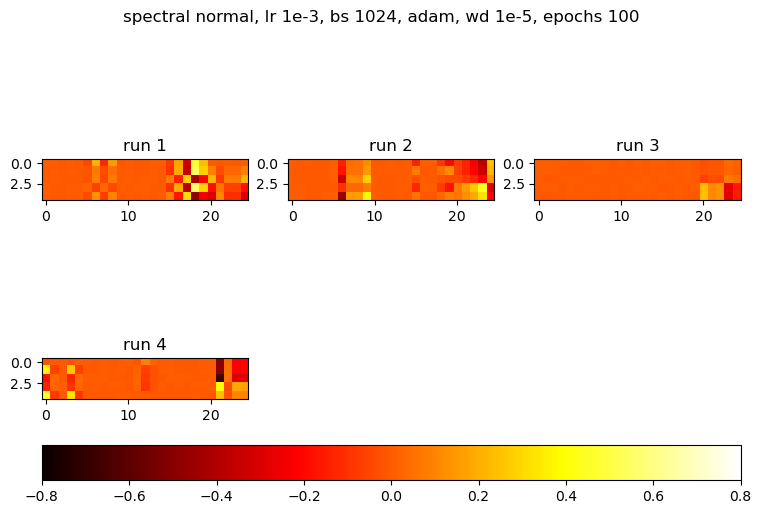

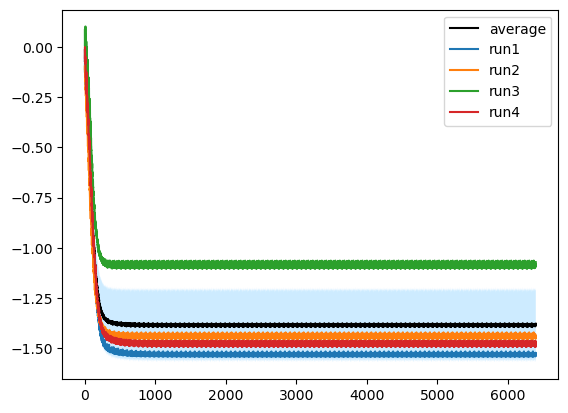

array([[0.50040001, 0.9878    , 0.49399999, 0.9957    , 0.99199998],
       [0.50389999, 0.98890001, 0.49149999, 0.98589998, 0.99379998],
       [0.4756    , 0.51389998, 0.49860001, 0.50220001, 0.98970002],
       [0.99040002, 0.49489999, 0.95169997, 0.50279999, 0.99510002]])

In [10]:
# spectral lr 1e-3, bs 1024, adam, wd 1e-5, epochs 100
dirs = [
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_bs=1024_run1',
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_bs=1024_run2',
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_bs=1024_run3',
'./outputs/normal_hparam_tuning/normal/spectral_linear_adam_emb_dim=5_bs=1024_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral normal, lr 1e-3, bs 1024, adam, wd 1e-5, epochs 100')
plot_metrics(dirs, plotall=True)
score_arr

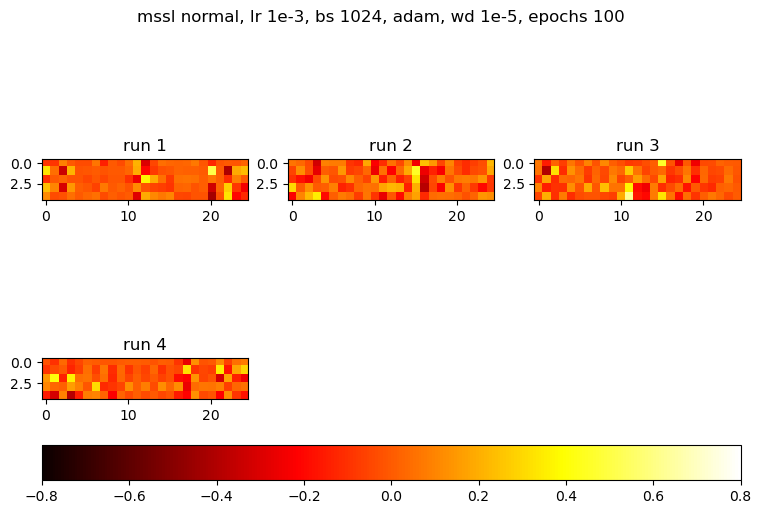

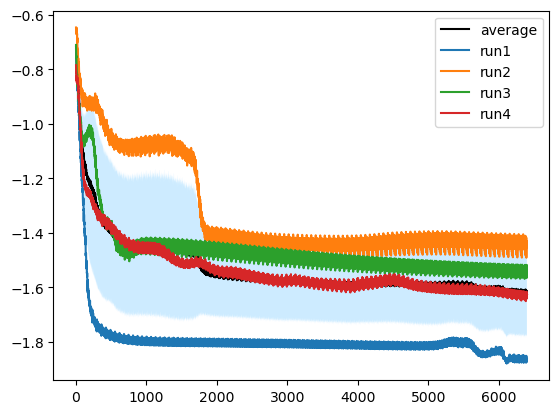

In [113]:
# mssl lr 1e-3, bs 1024, adam, wd 1e-5, epochs 100
dirs = [
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_bs=1024_run1',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_bs=1024_run2',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_bs=1024_run3',
'./outputs/normal_hparam_tuning/normal/mssla_linear_adam_emb_dim=5_bs=1024_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 1e-3, bs 1024, adam, wd 1e-5, epochs 100')
plot_metrics(dirs, plotall=True)
score_arr

## Weights + Test Accs for Normal Aug

Not entirely sure how we would define labels for this type of augmentation just yet, so don't really have a way to measure downstream accuracies. For now just plot assumptions, and repeat for runs with different embedding dimensions (data d = 25)

In [ ]:
# TODO: NEED TO RETRAIN TO GET LOWER TRAIN SCORES. SEE WHAT LOWEST SCORES CAN BE...
    

In [16]:
rd = torch.load(os.path.join('./outputs/correlated_normal_runs/normal/mssla_linear_adam_run1', 'run_dict'))
rd['model_weights']['weight'].shape

torch.Size([10, 25])

In [8]:
d = './outputs/correlated_normal_runs/normal/mssla_linear_adam_run1'
rd = torch.load(os.path.join(d, 'run_dict'))
# rd['data']['gt_vecs'][0].shape[0]
rd['args'].emb_dim

10

In [17]:
mvn = MultivariateNormal(torch.zeros(2), torch.eye(2))
a = mvn.sample((500,))
torch.std(a, dim=0).shape

torch.Size([2])

### embd=5 (d=5, K=5, total=25)

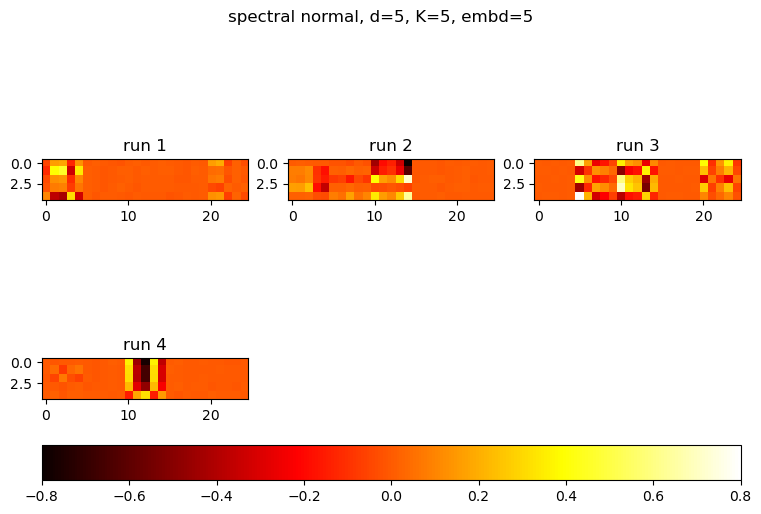

In [9]:
dirs = [
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=5_run1',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=5_run2',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=5_run3',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=5_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral normal, d=5, K=5, embd=5')
# plot_embeddings(dirs, toplot='embds', diff=True, n=20)
# plot_embeddings(dirs, toplot='cov', diff=True, n=100)

In [6]:
test_scores, avg_score = evalaute_normal_downstream(dirs, n_val=10000, n_test=10000)
print(f'Average test accuracy: {avg_score}')

NameError: name 'evalaute_normal_downstream' is not defined

In [24]:
rd = torch.load(os.path.join('./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=5_run1', 'run_dict'))
rd.keys()

dict_keys(['model_weights', 'data', 'optim', 'args', 'essential_args', 'train_losses'])

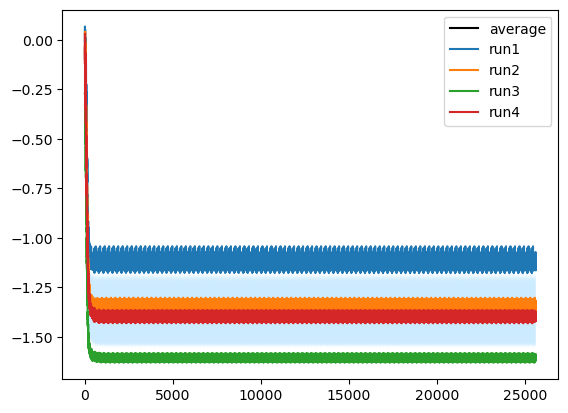

In [5]:
plot_metrics(dirs, plotall=True)

Difference from eye: 1.9626238346099854; norm of wwT: 1.3249002695083618
Difference from eye: 2.701441526412964; norm of wwT: 3.0599260330200195
Difference from eye: 2.4653451442718506; norm of wwT: 3.4833619594573975
Difference from eye: 3.280353307723999; norm of wwT: 3.610332489013672


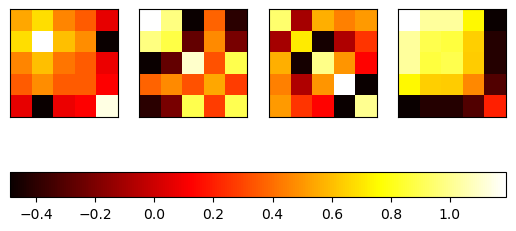

In [21]:
# plot W @ W.T for each (to see how close to identity it is; the uniformity loss encourages this)
to_plot = []
for dir in dirs:
    rd = torch.load(os.path.join(dir, 'run_dict'))
    w = rd['model_weights']['weight']
    embdim = w.shape[0]
    to_plot.append(w @ w.T)
    print(f"Difference from eye: {torch.norm((w @ w.T) - torch.eye(embdim))}; norm of wwT: {torch.norm(w @ w.T)}")
fig, ax = plt.subplots(1, len(to_plot))
for i in range(len(to_plot)):
    curr_ax = ax if len(to_plot) == 1 else ax[i]
    im = curr_ax.imshow(to_plot[i], cmap='hot', interpolation='nearest')
    curr_ax.set_xticks([])
    curr_ax.set_yticks([])
cbar_ax = ax if len(to_plot) == 1 else ax[:]
fig.colorbar(im, ax=cbar_ax, location='bottom', orientation='horizontal')
plt.show()

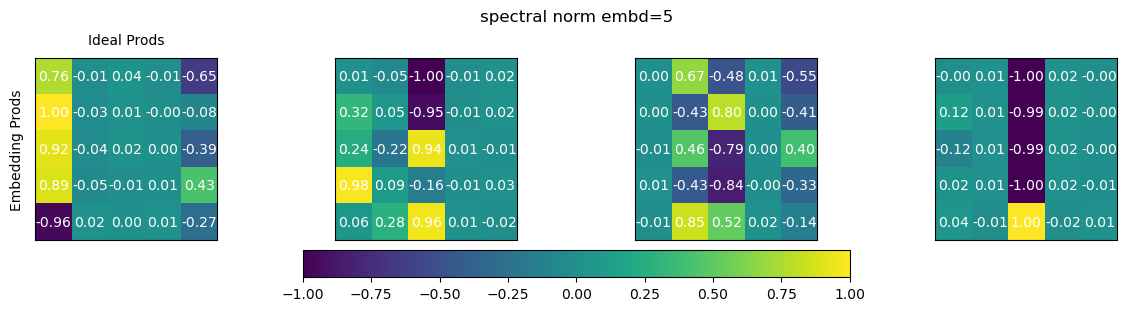

In [20]:
generate_dotprod_correlation_matrix(dirs, title='spectral norm embd=5')

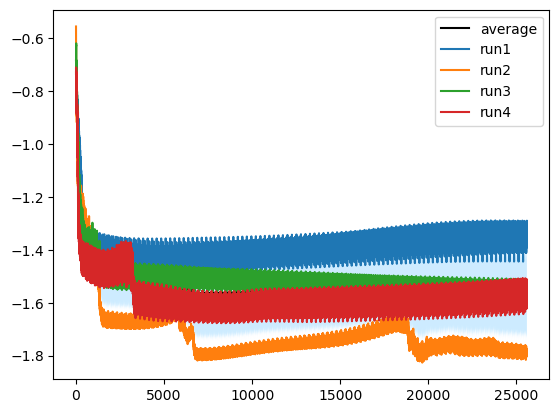

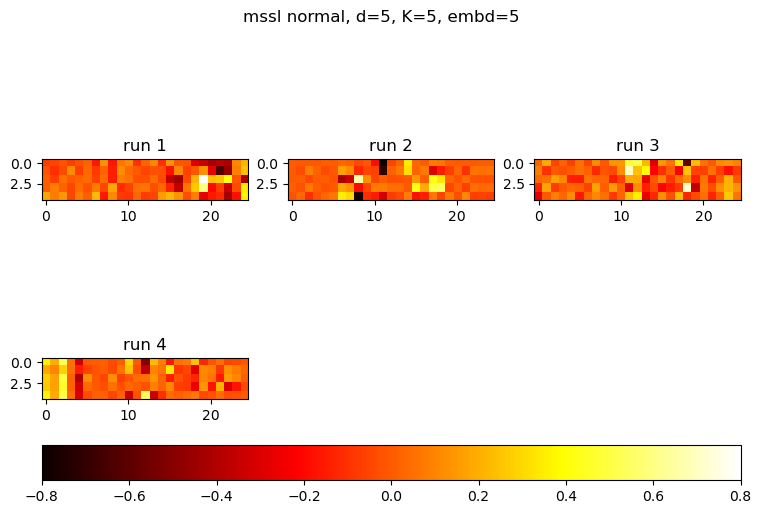

In [23]:
dirs = [
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=5_run1',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=5_run2',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=5_run3',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=5_run4',
]
plot_metrics(dirs, plotall=True)
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, d=5, K=5, embd=5')
# plot_embeddings(dirs, toplot='embds', diff=True, n=20)
# plot_embeddings(dirs, toplot='cov', diff=True, n=100)

In [13]:
test_scores, avg_score = evalaute_normal_downstream(dirs, n_val=10000, n_test=10000)
print(f'Average test accuracy: {avg_score}')

Correct: 2703.0 out of 10000 = 0.2703000009059906
Correct: 3082.0 out of 10000 = 0.30820000171661377
Correct: 530.0 out of 10000 = 0.05299999937415123
Correct: 3533.0 out of 10000 = 0.353300005197525
Average test accuracy: 0.24619999527931213


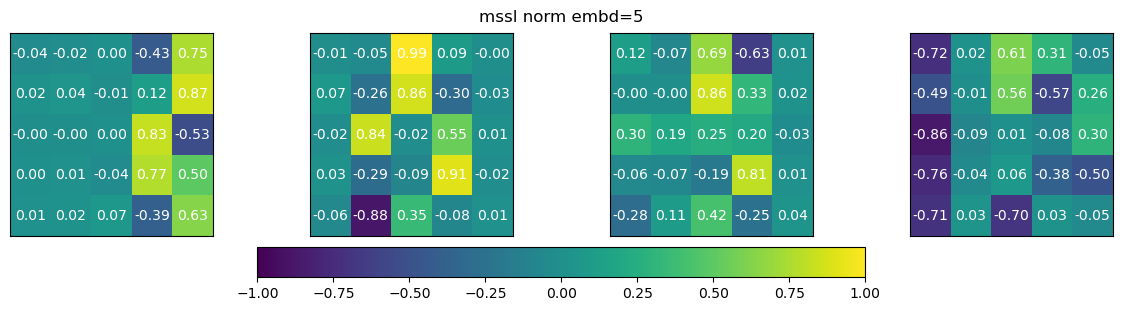

In [12]:
generate_dotprod_correlation_matrix(dirs, title='mssl norm embd=5')

### embd=10 (d=5, K=5, total=25)

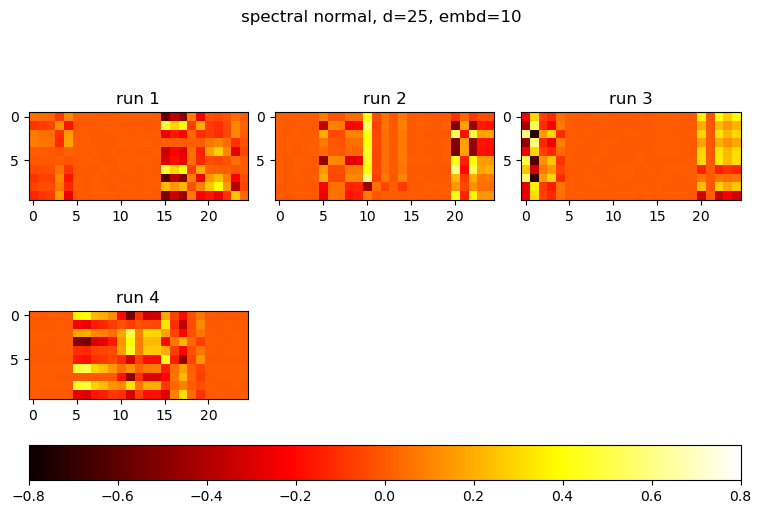

Norm of 20 rows of Z1 for run 1: tensor([0.6894, 7.5056, 1.7002, 1.2258, 1.6075, 2.4950, 2.5101, 2.7746, 1.8282,
        1.5084, 1.5963, 1.8154, 3.5062, 1.5104, 1.1251, 1.9579, 1.7059, 0.5333,
        3.2058, 3.4304]), average = 2.2115681171417236
Average norm of differences in embeddings (4 runs): 1.1466786861419678, embed dim = 10


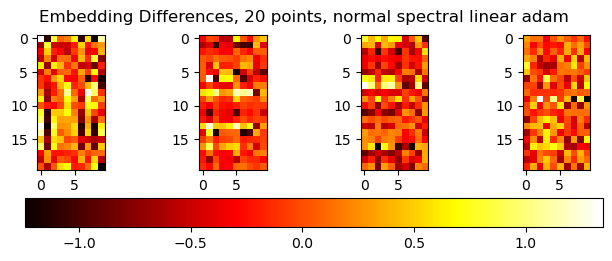

Norm of 100 rows of Z1 for run 1: tensor([4.0660, 1.0535, 1.2226, 2.1431, 0.6589, 0.9779, 2.9972, 0.8990, 3.9496,
        1.1230, 1.5347, 0.9560, 0.7229, 1.7986, 1.3477, 1.7717, 0.7464, 3.4005,
        2.0968, 2.5392, 2.5883, 2.5350, 2.4815, 1.4765, 2.2047, 3.3887, 1.7421,
        0.8030, 2.0366, 1.8186, 1.2414, 1.7393, 2.5349, 1.8342, 2.2402, 2.0328,
        1.5508, 0.5037, 0.6659, 3.0180, 1.8145, 1.8121, 4.5196, 2.6274, 2.8075,
        1.3684, 2.2257, 2.8508, 3.0583, 3.0605, 2.8378, 1.3302, 1.3690, 0.7099,
        2.8177, 0.3467, 2.2164, 2.8536, 2.0191, 0.7872, 2.0760, 1.7797, 1.2266,
        2.5515, 1.3218, 2.0542, 0.8831, 1.1344, 1.0112, 1.4032, 1.7814, 1.0327,
        1.1418, 2.0716, 0.5508, 0.8402, 1.2196, 1.0191, 3.2140, 1.5882, 2.8595,
        2.5075, 1.4672, 2.0079, 1.3093, 2.2513, 2.7443, 2.3121, 2.8838, 3.1131,
        2.0667, 2.5602, 2.4965, 3.2525, 3.2434, 3.2820, 1.6852, 2.1667, 4.5066,
        1.4339]), average = 1.979241132736206
Average Frobenius norm of differences in

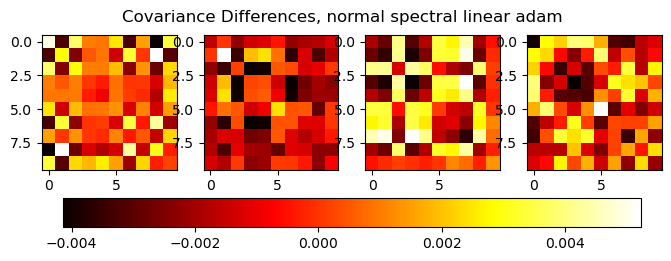

In [6]:
dirs = [
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_run1',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_run2',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_run3',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral normal, d=25, embd=10')
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

### embd=15 (d=5*5)

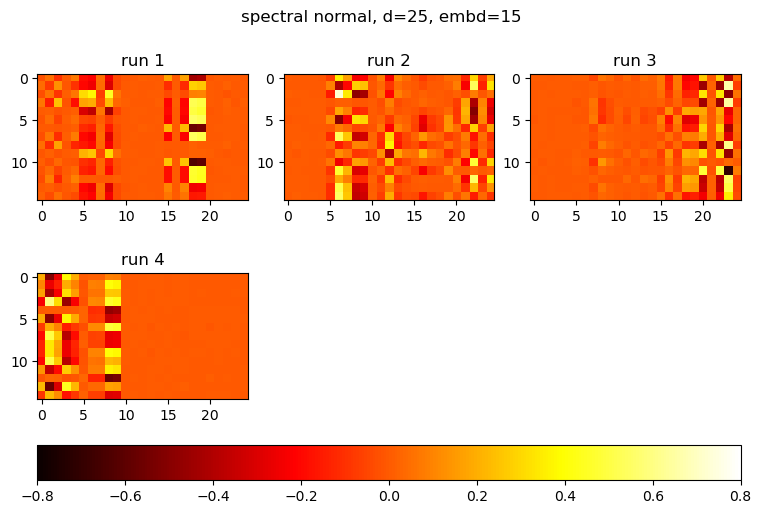

Norm of 20 rows of Z1 for run 1: tensor([5.7667, 1.0651, 1.4440, 3.4501, 1.3012, 2.8422, 2.3251, 1.5119, 1.8494,
        3.0167, 5.2170, 2.5801, 1.5315, 3.6570, 1.5180, 1.7886, 1.2338, 4.0350,
        2.3572, 4.3276]), average = 2.6409034729003906
Average norm of differences in embeddings (4 runs): 1.3925788402557373, embed dim = 15


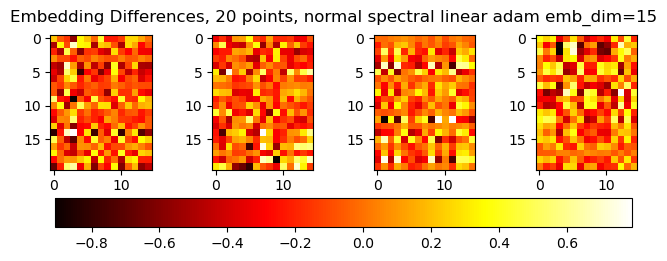

Norm of 100 rows of Z1 for run 1: tensor([2.0430, 2.7078, 1.8795, 6.7770, 1.4904, 0.7009, 0.8440, 2.7894, 2.0060,
        4.3370, 4.2212, 4.9495, 1.5213, 3.6038, 3.1065, 4.3411, 3.6178, 1.1336,
        1.1978, 3.1807, 1.2797, 2.7321, 1.5130, 2.0474, 1.8742, 1.6698, 3.1309,
        2.1689, 3.2173, 2.5285, 3.7798, 0.5514, 1.2577, 1.4640, 2.2910, 4.8650,
        0.7578, 2.4539, 1.0432, 4.4594, 2.4349, 1.3188, 2.2846, 2.0798, 3.1795,
        3.1338, 3.9306, 5.5982, 4.8116, 0.8044, 3.4801, 1.5538, 1.7533, 2.4655,
        2.9146, 5.4251, 1.2292, 0.7763, 3.4004, 2.5432, 2.2509, 2.0585, 3.3917,
        2.2769, 5.1317, 3.7101, 1.4940, 3.2461, 2.4705, 3.8008, 2.2600, 2.3292,
        5.2208, 2.1832, 4.1067, 3.9719, 1.8877, 4.1867, 1.1533, 4.7716, 1.4869,
        1.2812, 2.8374, 3.8714, 2.6823, 2.4514, 0.9739, 1.4762, 3.6635, 2.1297,
        0.8761, 1.5670, 3.3404, 1.8143, 3.5468, 3.1879, 1.1591, 2.0593, 3.8523,
        3.1232]), average = 2.659334182739258
Average Frobenius norm of differences in

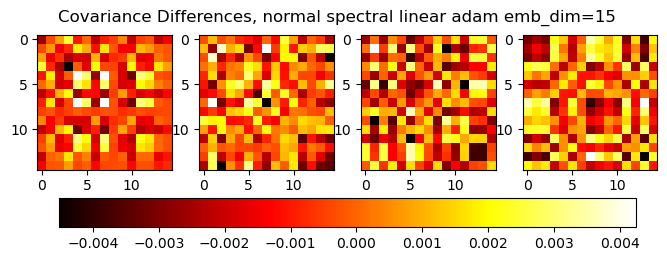

In [ ]:
dirs = [
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=15_run1',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=15_run2',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=15_run3',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=15_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral normal, d=25, embd=15')
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

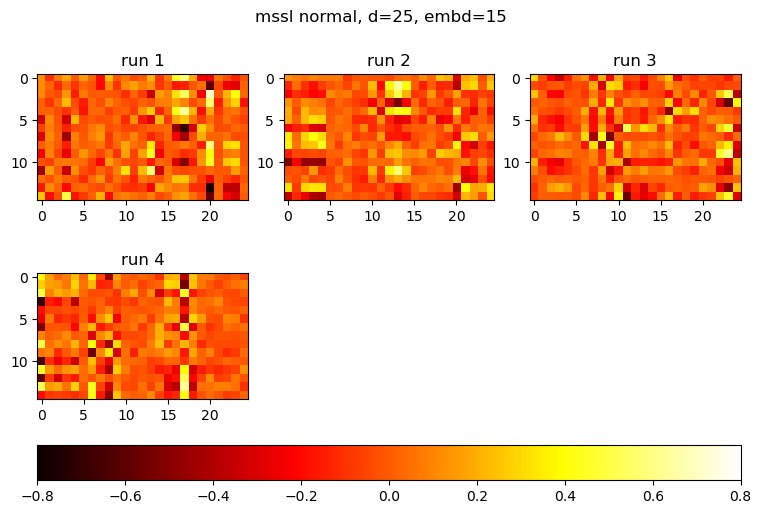

Norm of 20 rows of Z1 for run 1: tensor([3.7786, 4.6087, 3.5505, 6.7117, 3.6936, 4.9237, 3.7691, 3.5136, 5.1199,
        3.1874, 1.6811, 4.5227, 3.4345, 4.3502, 3.0490, 3.2361, 4.0463, 3.7790,
        1.2528, 2.7745]), average = 3.749164581298828
Average norm of differences in embeddings (4 runs): 2.8918557167053223, embed dim = 15


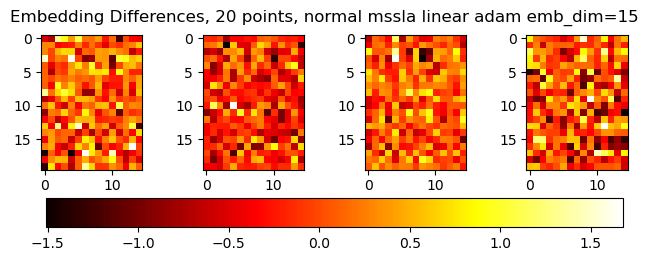

Norm of 100 rows of Z1 for run 1: tensor([1.9814, 5.2316, 3.2892, 4.0292, 3.6244, 3.2394, 3.7191, 4.6653, 3.3386,
        4.5710, 5.5175, 3.7467, 4.5498, 3.2332, 2.4783, 2.8898, 3.7964, 3.3406,
        5.3445, 5.2794, 2.6715, 3.5030, 2.3022, 4.2689, 4.8942, 5.5940, 3.6240,
        2.3521, 1.4332, 4.4231, 3.1869, 1.7997, 2.4099, 6.3582, 5.1363, 2.9683,
        3.6973, 4.8814, 3.6816, 2.3141, 5.3948, 2.6780, 3.6444, 2.4913, 2.1153,
        3.9907, 4.7165, 5.1056, 1.8147, 5.9228, 3.7971, 4.4820, 1.8300, 4.4887,
        2.9690, 2.8719, 5.4409, 4.2260, 5.8176, 3.7462, 2.4713, 4.2805, 2.6876,
        2.1718, 3.3789, 4.2252, 4.3699, 5.7984, 2.4810, 3.9849, 2.1751, 2.5055,
        1.4837, 3.7053, 2.6486, 3.9725, 3.4883, 3.1771, 4.1299, 3.4018, 2.9222,
        2.3386, 2.5624, 3.9862, 2.7398, 4.0045, 5.9387, 2.1356, 2.0404, 2.5864,
        1.6644, 1.7899, 2.3063, 3.5461, 5.2261, 4.4138, 2.8495, 4.6930, 4.7843,
        4.6798]), average = 3.606539726257324
Average Frobenius norm of differences in

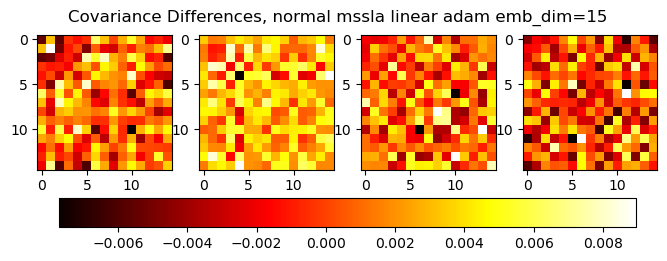

In [ ]:
dirs = [
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=15_run1',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=15_run2',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=15_run3',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=15_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, d=25, embd=15')
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

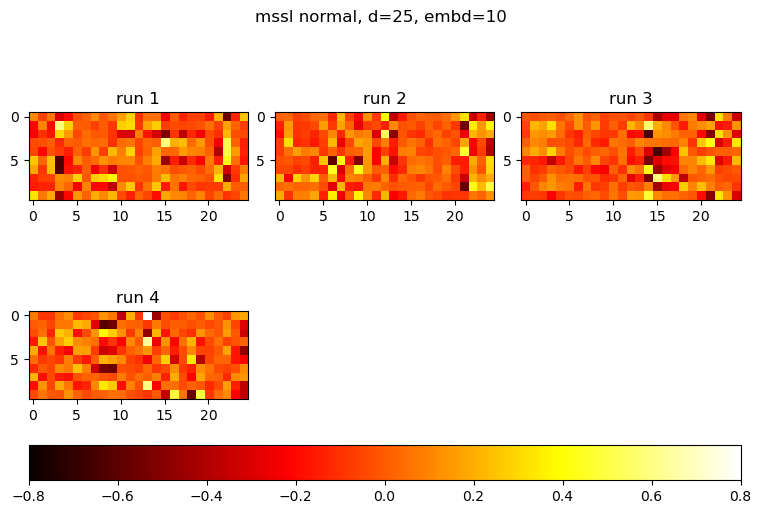

Norm of 20 rows of Z1 for run 1: tensor([2.6836, 3.1003, 2.7571, 3.1638, 2.9567, 2.3298, 1.6860, 1.8040, 3.0284,
        2.3320, 2.7721, 3.0798, 3.5703, 2.4424, 4.2078, 1.4901, 1.8535, 2.3676,
        2.8290, 1.8094]), average = 2.613180637359619
Average norm of differences in embeddings (4 runs): 2.515265941619873, embed dim = 10


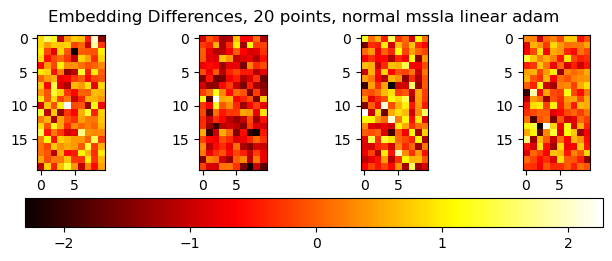

Norm of 100 rows of Z1 for run 1: tensor([2.6919, 2.5173, 1.7126, 3.1927, 4.5188, 2.6815, 2.9002, 2.6953, 3.0423,
        2.1768, 2.7936, 2.9702, 3.4826, 3.4044, 1.8629, 1.8852, 3.1358, 3.7485,
        2.7324, 2.6589, 3.6777, 1.8662, 4.0662, 1.7187, 3.1262, 3.1085, 2.2440,
        1.6772, 3.4241, 2.8739, 2.6461, 1.2814, 1.9590, 3.0726, 2.0069, 1.4447,
        2.6213, 4.3471, 2.5794, 3.5950, 1.4078, 2.4040, 3.4976, 2.9834, 2.2548,
        2.1810, 2.4633, 3.1180, 3.6840, 3.2984, 6.4169, 2.5138, 3.4457, 2.4491,
        3.3185, 3.3018, 1.8236, 4.0029, 4.2618, 2.1509, 3.7504, 2.2890, 2.3982,
        3.1394, 4.5414, 4.9573, 3.6179, 1.9278, 2.3207, 2.3954, 3.7143, 3.7427,
        4.9872, 3.0138, 2.3494, 3.1638, 4.1405, 2.4334, 3.6359, 2.2216, 2.6406,
        2.0826, 2.5719, 3.6496, 2.4171, 1.6597, 3.3915, 3.8840, 2.1589, 2.2474,
        2.0373, 3.0436, 3.3066, 1.4028, 1.7178, 2.2077, 1.9209, 3.8098, 2.9008,
        2.4614]), average = 2.873699903488159
Average Frobenius norm of differences in

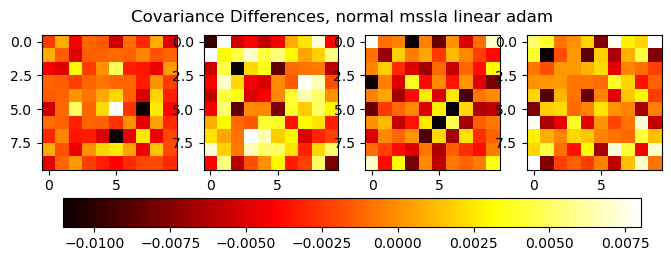

In [8]:
dirs = [
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_run1',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_run2',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_run3',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, d=25, embd=10')
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

### embd=15 (d=5*5)

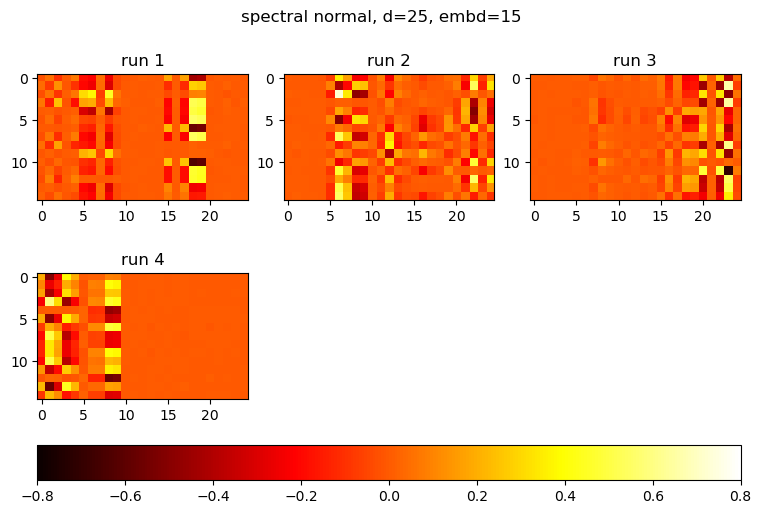

Norm of 20 rows of Z1 for run 1: tensor([5.7667, 1.0651, 1.4440, 3.4501, 1.3012, 2.8422, 2.3251, 1.5119, 1.8494,
        3.0167, 5.2170, 2.5801, 1.5315, 3.6570, 1.5180, 1.7886, 1.2338, 4.0350,
        2.3572, 4.3276]), average = 2.6409034729003906
Average norm of differences in embeddings (4 runs): 1.3925788402557373, embed dim = 15


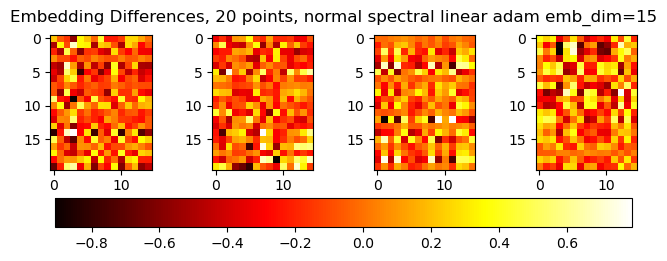

Norm of 100 rows of Z1 for run 1: tensor([2.0430, 2.7078, 1.8795, 6.7770, 1.4904, 0.7009, 0.8440, 2.7894, 2.0060,
        4.3370, 4.2212, 4.9495, 1.5213, 3.6038, 3.1065, 4.3411, 3.6178, 1.1336,
        1.1978, 3.1807, 1.2797, 2.7321, 1.5130, 2.0474, 1.8742, 1.6698, 3.1309,
        2.1689, 3.2173, 2.5285, 3.7798, 0.5514, 1.2577, 1.4640, 2.2910, 4.8650,
        0.7578, 2.4539, 1.0432, 4.4594, 2.4349, 1.3188, 2.2846, 2.0798, 3.1795,
        3.1338, 3.9306, 5.5982, 4.8116, 0.8044, 3.4801, 1.5538, 1.7533, 2.4655,
        2.9146, 5.4251, 1.2292, 0.7763, 3.4004, 2.5432, 2.2509, 2.0585, 3.3917,
        2.2769, 5.1317, 3.7101, 1.4940, 3.2461, 2.4705, 3.8008, 2.2600, 2.3292,
        5.2208, 2.1832, 4.1067, 3.9719, 1.8877, 4.1867, 1.1533, 4.7716, 1.4869,
        1.2812, 2.8374, 3.8714, 2.6823, 2.4514, 0.9739, 1.4762, 3.6635, 2.1297,
        0.8761, 1.5670, 3.3404, 1.8143, 3.5468, 3.1879, 1.1591, 2.0593, 3.8523,
        3.1232]), average = 2.659334182739258
Average Frobenius norm of differences in

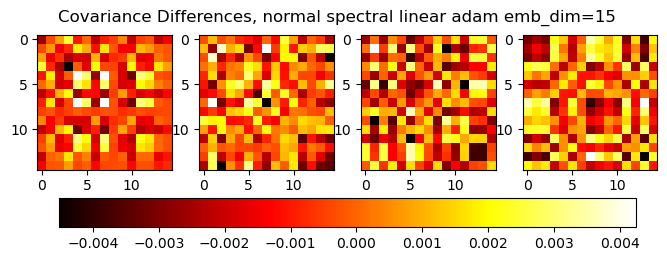

In [11]:
dirs = [
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=15_run1',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=15_run2',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=15_run3',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=15_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral normal, d=25, embd=15')
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

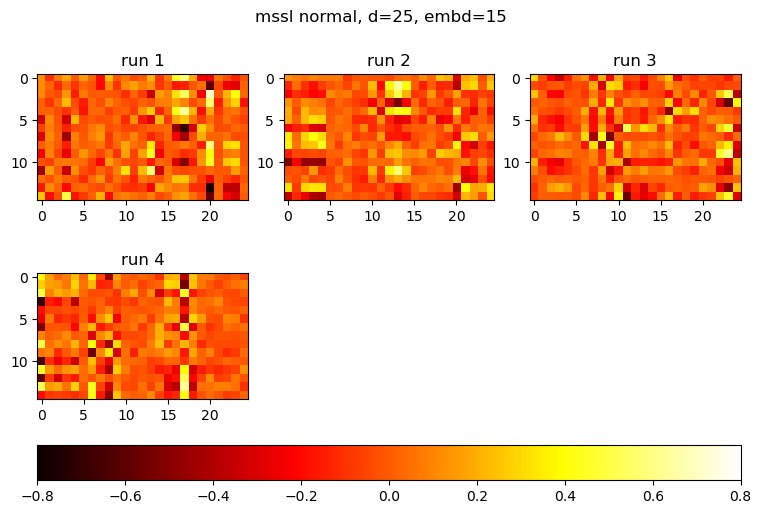

Norm of 20 rows of Z1 for run 1: tensor([3.7786, 4.6087, 3.5505, 6.7117, 3.6936, 4.9237, 3.7691, 3.5136, 5.1199,
        3.1874, 1.6811, 4.5227, 3.4345, 4.3502, 3.0490, 3.2361, 4.0463, 3.7790,
        1.2528, 2.7745]), average = 3.749164581298828
Average norm of differences in embeddings (4 runs): 2.8918557167053223, embed dim = 15


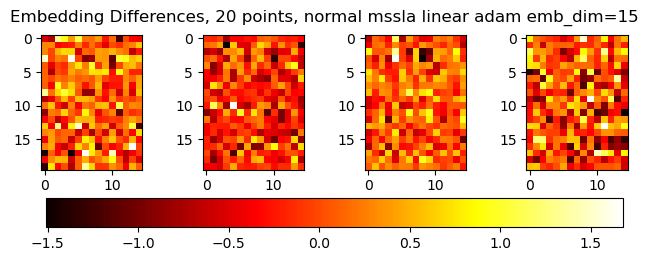

Norm of 100 rows of Z1 for run 1: tensor([1.9814, 5.2316, 3.2892, 4.0292, 3.6244, 3.2394, 3.7191, 4.6653, 3.3386,
        4.5710, 5.5175, 3.7467, 4.5498, 3.2332, 2.4783, 2.8898, 3.7964, 3.3406,
        5.3445, 5.2794, 2.6715, 3.5030, 2.3022, 4.2689, 4.8942, 5.5940, 3.6240,
        2.3521, 1.4332, 4.4231, 3.1869, 1.7997, 2.4099, 6.3582, 5.1363, 2.9683,
        3.6973, 4.8814, 3.6816, 2.3141, 5.3948, 2.6780, 3.6444, 2.4913, 2.1153,
        3.9907, 4.7165, 5.1056, 1.8147, 5.9228, 3.7971, 4.4820, 1.8300, 4.4887,
        2.9690, 2.8719, 5.4409, 4.2260, 5.8176, 3.7462, 2.4713, 4.2805, 2.6876,
        2.1718, 3.3789, 4.2252, 4.3699, 5.7984, 2.4810, 3.9849, 2.1751, 2.5055,
        1.4837, 3.7053, 2.6486, 3.9725, 3.4883, 3.1771, 4.1299, 3.4018, 2.9222,
        2.3386, 2.5624, 3.9862, 2.7398, 4.0045, 5.9387, 2.1356, 2.0404, 2.5864,
        1.6644, 1.7899, 2.3063, 3.5461, 5.2261, 4.4138, 2.8495, 4.6930, 4.7843,
        4.6798]), average = 3.606539726257324
Average Frobenius norm of differences in

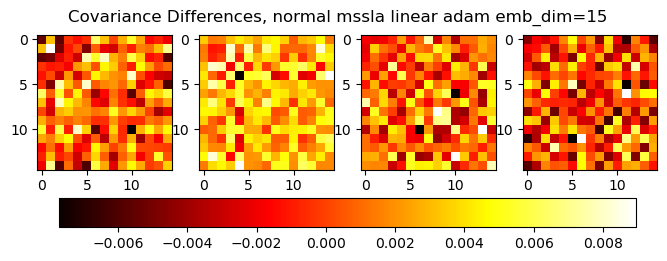

In [12]:
dirs = [
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=15_run1',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=15_run2',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=15_run3',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=15_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, d=25, embd=15')
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

### embd=20 (d=5*5)

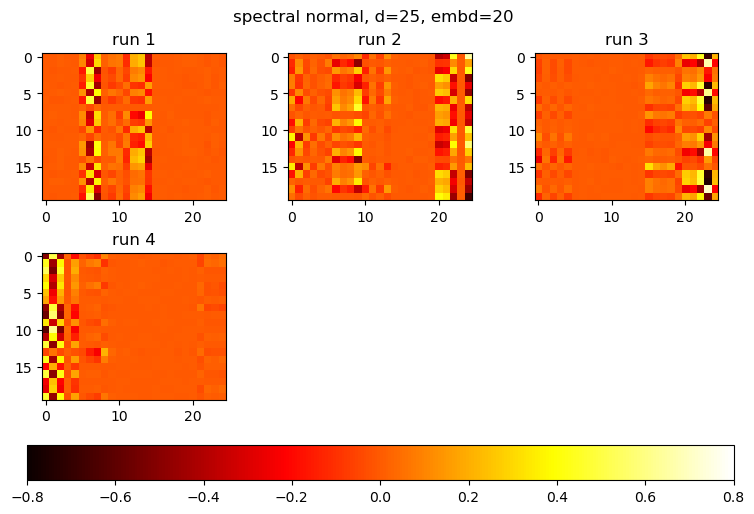

Norm of 20 rows of Z1 for run 1: tensor([1.6605, 2.7116, 1.6068, 3.2645, 1.4743, 1.9418, 1.4961, 4.4206, 4.1030,
        2.8620, 1.2774, 4.6082, 2.2333, 1.6140, 3.9634, 2.3399, 0.5878, 4.9413,
        5.3135, 1.8003]), average = 2.7110238075256348
Average norm of differences in embeddings (4 runs): 1.5433670282363892, embed dim = 20


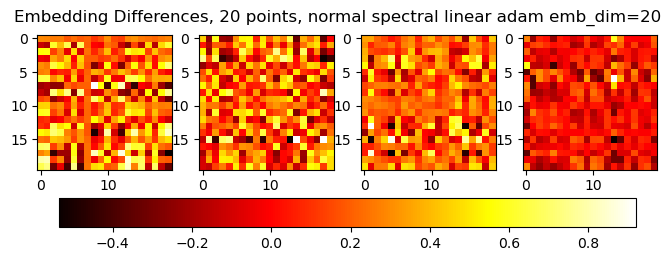

Norm of 100 rows of Z1 for run 1: tensor([3.2339, 1.7614, 3.2848, 4.9896, 2.1530, 5.1552, 2.1784, 0.3349, 1.9809,
        2.0917, 4.7294, 1.8508, 2.0739, 2.7784, 1.7883, 4.0531, 2.1328, 2.1974,
        1.3664, 1.7308, 0.1904, 1.6810, 0.5399, 1.8476, 0.7134, 1.5694, 3.2825,
        0.6597, 3.4087, 3.0040, 1.0784, 1.9128, 2.9175, 4.0284, 3.8447, 1.6147,
        0.9204, 3.1784, 4.3815, 5.7155, 3.1494, 1.7650, 3.4418, 1.9568, 1.2619,
        3.8212, 3.3959, 1.3964, 5.2848, 3.5996, 1.7440, 1.1699, 2.9639, 0.2007,
        2.4933, 2.8337, 3.0508, 1.1240, 0.7024, 0.7843, 2.8773, 1.4291, 1.4528,
        2.0160, 2.4187, 2.1544, 1.7812, 3.0027, 2.1328, 2.4319, 2.5981, 3.3398,
        3.9751, 1.7304, 5.4479, 3.0246, 3.3617, 0.8969, 4.2520, 2.8102, 0.9021,
        2.1535, 0.3257, 1.2934, 3.0011, 3.3600, 1.8645, 3.8991, 1.7148, 4.1261,
        4.0761, 2.0188, 4.6438, 2.5485, 2.5252, 3.3899, 1.5833, 1.2759, 2.3358,
        0.8145]), average = 2.4547922611236572
Average Frobenius norm of differences i

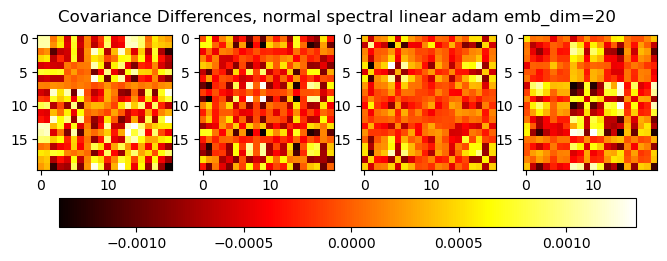

In [13]:
dirs = [
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=20_run1',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=20_run2',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=20_run3',
'./outputs/correlated_normal_runs/normal/spectral_linear_adam_emb_dim=20_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='spectral normal, d=25, embd=20')
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

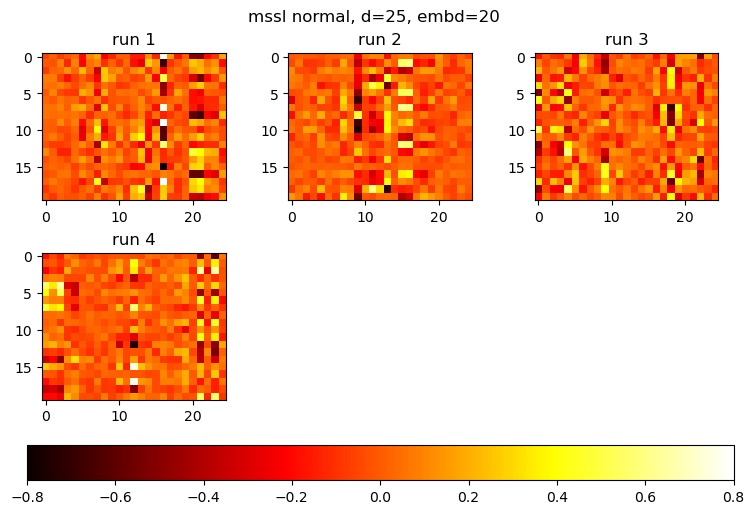

Norm of 20 rows of Z1 for run 1: tensor([2.8121, 5.2614, 5.0798, 8.2643, 4.0272, 6.0640, 2.9003, 5.3088, 3.6390,
        4.9043, 5.5553, 3.6118, 3.4624, 4.3971, 2.3139, 8.5408, 4.3936, 4.9259,
        1.5064, 5.7901]), average = 4.637921333312988
Average norm of differences in embeddings (4 runs): 3.253737688064575, embed dim = 20


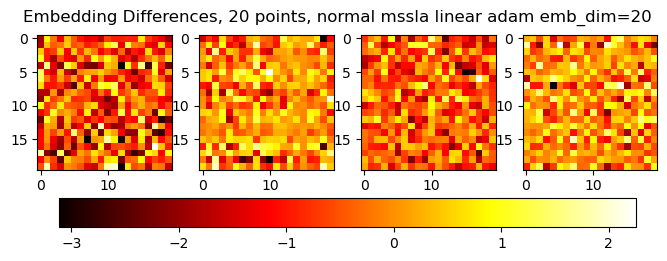

Norm of 100 rows of Z1 for run 1: tensor([5.4439, 4.4677, 2.3566, 4.5468, 4.1465, 2.2405, 4.7552, 4.0219, 2.9202,
        2.5981, 2.6475, 2.9471, 4.6603, 2.3803, 6.4190, 3.7703, 3.9402, 2.5599,
        6.4607, 5.2705, 3.8533, 2.8599, 3.6461, 4.6916, 4.7546, 5.0323, 3.7052,
        4.3279, 1.7696, 4.9912, 1.6826, 3.6559, 7.8729, 4.3714, 4.8114, 3.9712,
        4.6632, 3.3187, 6.1837, 2.6192, 3.1834, 2.4788, 6.4461, 2.9096, 2.8760,
        3.7468, 2.0800, 6.1343, 4.7619, 4.9474, 4.2818, 2.8757, 3.3586, 2.8194,
        4.8868, 2.3816, 4.2010, 7.3828, 5.9518, 7.2777, 5.2172, 5.6026, 3.1504,
        4.5108, 5.1165, 3.3002, 5.4195, 3.6556, 4.3967, 2.5693, 2.4280, 6.1036,
        4.3829, 2.2121, 1.9931, 3.3314, 3.2351, 5.7452, 2.4550, 3.5369, 4.8593,
        3.8604, 4.8500, 2.2731, 5.9399, 4.1649, 5.1512, 2.7472, 3.3976, 4.9949,
        3.4413, 3.1604, 2.2395, 6.8425, 3.3369, 6.7170, 1.7741, 3.9887, 3.6170,
        2.9908]), average = 4.050252914428711
Average Frobenius norm of differences in

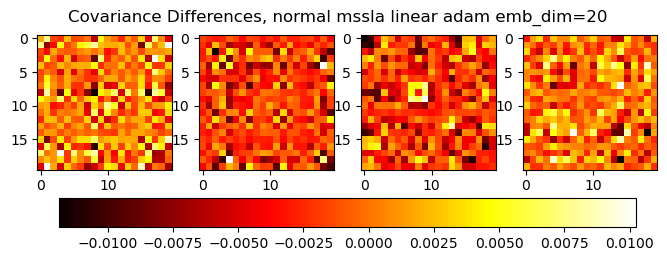

In [14]:
dirs = [
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=20_run1',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=20_run2',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=20_run3',
'./outputs/correlated_normal_runs/normal/mssla_linear_adam_emb_dim=20_run4',
]
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, d=25, embd=20')
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True, n=100)

In [ ]:
for dir in dirs:
    run_dict = torch.load(os.path.join(dir, 'run_dict'))
    data = run_dict['data']
    gt_keys = ['alphas', 'gt_vecs', 'gt_covs']
    gt_dict = {key:data[key] for key in gt_keys}
# LAST SEEN
# TODO: finish writing code to generate validation, test data for each directory, and get downstream classif performance
# TODO: check that plot_embeddings is correct (reason: embedding difference norms seem to be unusually large!!)
    

In [ ]:
rd = torch.load(os.path.join('./outputs/correlated_normal_runs/normal/mssla_linear_adam_run1', 'run_dict'))
rd['data'].keys()


dict_keys(['train', 'alphas', 'gt_vecs', 'gt_covs'])

## Meta: Checks to see validity of test accuracy code
Since spurious sum can give 0, we by convention set label to be 1 if the sum of natural data is 0. Wanted to see if this would lead to weird issues along the way..

In [33]:
# Look into how often incorrect predictions were due to spursum = 0 cases
# MSSLA
spsum_is0_mask = (torch.sum(spur_test[:, 5:], dim=1) == 0)
print("Wrong test predictions due to spurious sum = 0 in labeling function:")
for idx, (backbone, linear) in enumerate(zip(backbones, classifiers)):
    out = linear(backbone(spur_test)).flatten()
    out[out == 0] = 1 # also included same 'convention' in labeling - not sure if this makes sense or not.
    pred = (torch.sign(out) + 1)/2
    wrongs = (spur_test_labels != pred)
    wrong_for_spsum0 = torch.sum(wrongs[spsum_is0_mask]).item()
    total_wrong = torch.sum(wrongs).item()
    total_spsum_is0 = torch.sum(spsum_is0_mask)
    
    # print(f'Run {idx + 1}, out of total wrong: {wrong_for_spsum0} / {total_wrong} = {wrong_for_spsum0/total_wrong}')
    print(f'Run {idx + 1}, out of total spsum=0: {wrong_for_spsum0} / {total_spsum_is0} = {wrong_for_spsum0/total_spsum_is0}')
    
    

Wrong test predictions due to spurious sum = 0 in labeling function:
Run 1, out of total spsum=0: 1767 / 4416 = 0.40013587474823
Run 2, out of total spsum=0: 724 / 4416 = 0.16394928097724915
Run 3, out of total spsum=0: 1981 / 4416 = 0.4485960304737091
Run 4, out of total spsum=0: 2778 / 4416 = 0.6290761232376099
Run 5, out of total spsum=0: 2108 / 4416 = 0.47735509276390076
Run 6, out of total spsum=0: 378 / 4416 = 0.08559782803058624


In [15]:
spursums_test = torch.sum(spur_test[:, 5:], dim=1)
torch.sum(spursums_test == 0)/spur_test.shape[0]

tensor(0.1766)

In [9]:
# MSSL BOOL CORR SINGLE TAU
dirs = [
'./outputs/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run5'
]
test_accs, avg_acc = evaluate_embeddings(dirs, val=spur_val, val_labels=spur_val_labels, test=spur_test, test_labels=spur_test_labels)

FileNotFoundError: [Errno 2] No such file or directory: './outputs/bool_corr_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run5/run_dict'